In [2]:
%matplotlib inline

In [3]:
import datetime
from tqdm import tqdm
import random
import sys

In [4]:
def get_day(dates):
    day = [(date - datetime.datetime(2017, 4, 1)).days for date in dates]
    return np.array(day)

In [5]:
def feature_engineering(df, dmm, mv, admm):
    if dmm:
         df['diff_moving_mean'] = df['水準'] - df['水準'].rolling(window=7, min_periods=1, center=True).median()
    if mv:
        df['moving_variance'] = df['水準'].rolling(window=7, min_periods=1, center=True).kurt()
    if admm:
        df['accumulation_diff_moving_mean'] = np.cumsum(
            abs(df['水準'].rolling(window=3, min_periods=1, center=True).median() -
                df['水準'].rolling(window=15, min_periods=1, center=False).median()))
    return df

In [6]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

In [7]:
def scaling(df, w1, w2, w3, w4):
    df['day'] = ss.fit_transform(df['day'].astype(float).values.reshape(len(df), 1))
    if w1 != 0:
        df['水準'] = ss.fit_transform(df['水準'].values.reshape(len(df), 1))*w1
    if w2 != 0:
        df['diff_moving_mean'] = ss.fit_transform(df['diff_moving_mean'].values.reshape(len(df), 1))*w2
    if w3 != 0:
        df['moving_variance'] = df['moving_variance'].fillna(0) #rollingした水準が全部同じ値のときはNANになる
        df['moving_variance'] = ss.fit_transform(df['moving_variance'].values.reshape(len(df), 1))*w3
    if w4 != 0:
        df['accumulation_diff_moving_mean'] = \
        ss.fit_transform(df['accumulation_diff_moving_mean'].values.reshape(len(df), 1))*w4
    return df

In [8]:
from sklearn.neighbors import KernelDensity
bandwidth = [0.1, 1, 10, 50, 100]
kernel = ['gaussian', 'tophat', 'epanechnikov', 'exponential', 'linear', 'cosine']
metric = ['minkowski', 'cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan']
leaf_size = [10, 40, 400, 4000]
kd = KernelDensity(bandwidth=bandwidth[3], kernel=kernel[0], metric=metric[0], leaf_size=leaf_size[1])

In [9]:
def kd_outliers(raw):
    df = raw.copy()
    df = feature_engineering(df, True, True, True)
    df = scaling(df, 50, 50, 0.5, 50)
    kd.fit(df)
    score_pred = kd.score_samples(df)
    normal_id = df[np.where(score_pred <= np.average(score_pred)*0.99999, False, True)].index.values
    return normal_id

In [10]:
def kd_outliers1(raw):
    df = raw.copy()
    df = feature_engineering(df, True, True, True)
    df = scaling(df, 50, 50, 0.5, 50)
    kd.fit(df)
    score_pred = kd.score_samples(df)
    normal_id = df[np.where(score_pred <= np.average(score_pred)*0.999, False, True)].index.values
    return normal_id

In [11]:
def kd_outliers2(raw):
    df = raw.copy()
    df = feature_engineering(df, True, True, True)
    df = scaling(df, 50, 50, 0.5, 50)
    kd.fit(df)
    score_pred = kd.score_samples(df)
    normal_id = df[np.where(score_pred <= np.average(score_pred)*0.99998, False, True)].index.values
    return normal_id

In [12]:
from scipy.cluster.hierarchy import linkage, fcluster

In [13]:
def dendrogram_outliers(raw):
    df = raw.copy()
    df = feature_engineering(df, True, False, True)
    df = scaling(df, 10, 50, 0, 100)

    linkage_result = linkage(df, method='ward', metric='euclidean')
    threshold = 0.95 * np.max(linkage_result[:, 2])
    clustered = fcluster(linkage_result, threshold, criterion='distance')

    df['label'] = clustered
    normal_label = df['label'].mode()[0]
    normal_id = df[df['label'] == normal_label].index.values
    return normal_id

In [14]:
def remove_outliers(raw):
    local_global = [[[], []], [[], []], [[], []], [[], []]]
    local_global[0][1].extend(raw.index.values)
    df1 = raw.copy()
    local_global[1][1].extend(kd_outliers(df1))

    df2 = raw.loc[local_global[1][1]]
    df2 = df2.reset_index(drop=True)
    local_global[2][0].extend(dendrogram_outliers(df2))
    local_global[2][1].extend([local_global[1][1][i] for i in local_global[2][0]])

    df3 = raw.loc[local_global[2][1]]
    df3 = df3.reset_index(drop=True)
    local_global[3][0].extend(kd_outliers2(df3))
    local_global[3][1].extend([local_global[2][1][i] for i in local_global[3][0]])
    return local_global[3][1]

In [15]:
def flag_outliers(raw):
    local_global = [[[], []], [[], []], [[], []], [[], []]]
    local_global[0][1].extend(raw.index.values)
    df1 = raw.copy()
    local_global[1][1].extend(kd_outliers(df1))

    df2 = raw.loc[local_global[1][1]]
    df2 = df2.reset_index(drop=True)
    local_global[2][0].extend(dendrogram_outliers(df2))
    local_global[2][1].extend([local_global[1][1][i] for i in local_global[2][0]])

    df3 = raw.loc[local_global[2][1]]
    df3 = df3.reset_index(drop=True)
    local_global[3][0].extend(kd_outliers2(df3))
    local_global[3][1].extend([local_global[2][1][i] for i in local_global[3][0]])

    out1 = set(local_global[0][1]) - set(local_global[1][1])
    out2 = set(local_global[1][1]) - set(local_global[2][1])
    out3 = set(local_global[2][1]) - set(local_global[3][1])
    normal = local_global[3][1]
    return out1, out2, out3, normal

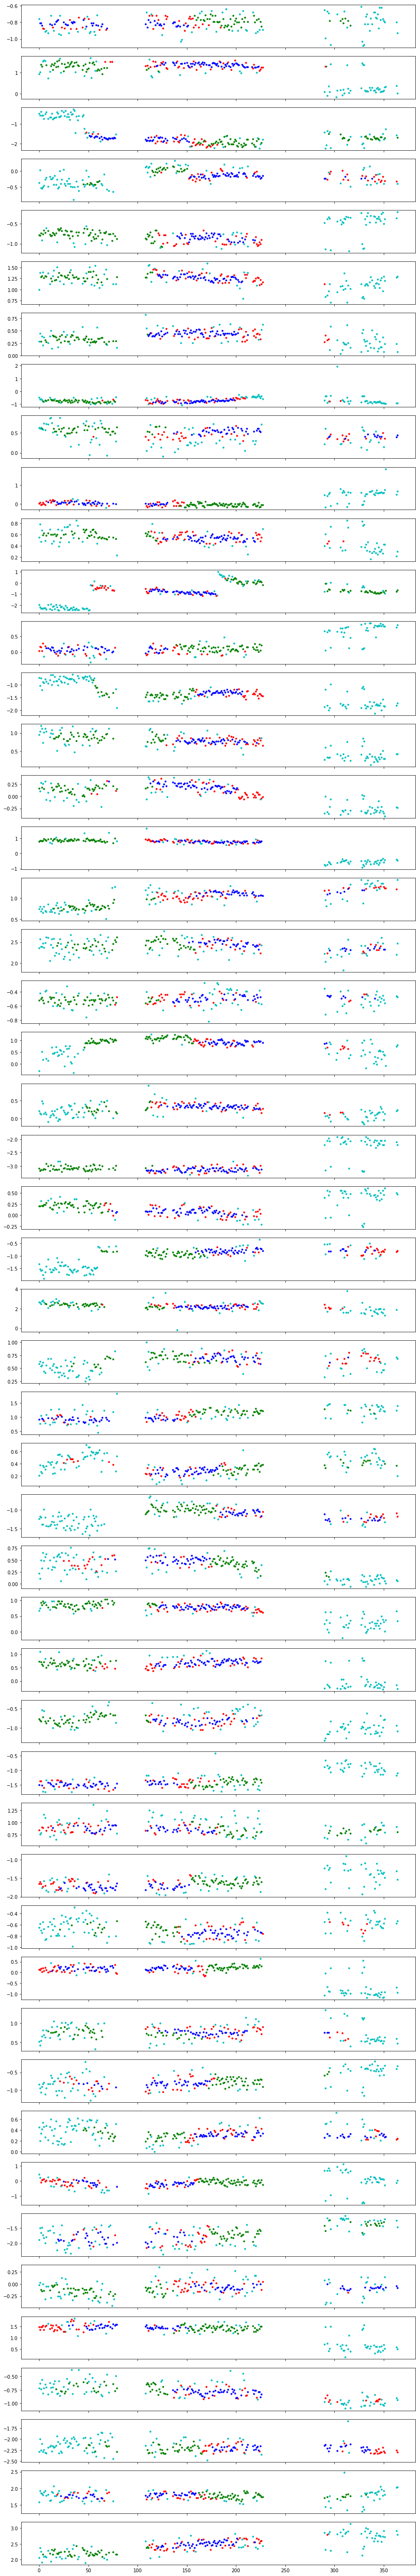

In [16]:
fig, axes = plt.subplots(50, 1, figsize=(15, 100), sharex=True)
random.seed(110)
track = tracks['C']
kilos = track['キロ程'].unique()

for i, kilo in enumerate(random.sample(list(kilos), 50)):
    data = track.loc[track['キロ程'] == kilo, ['date', '水準']]
    data = data.dropna(subset=['水準'])
    data = data.reset_index(drop=True)
    data['day'] = get_day(data['date'])
    data = data.drop(['date'], axis=1)
    if len(data) < 20:
        print(i)
        continue
    out1, out2, out3, normal = flag_outliers(data)

    datao1 = data.loc[out1]
    datao2 = data.loc[out2]
    datao3 = data.loc[out3]
    datal = data.loc[normal]

    axes[i].plot(datao1['day'], datao1['水準'], marker='.', linewidth=0, c='c')
    axes[i].plot(datao2['day'], datao2['水準'], marker='.', linewidth=0, c='g')
    axes[i].plot(datao3['day'], datao3['水準'], marker='.', linewidth=0, c='r')
    axes[i].plot(datal['day'], datal['水準'], marker='.', linewidth=0, c='b')

In [15]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

In [16]:
def get_slope_variance(X, y):
    if len(X) < 10:
        slope = 100
        variance = 100
    else:
        data = np.array([X, y]).T
        pca.fit(data)
        cmp = pca.components_
        cov = pca.get_covariance()

        slope = cmp[0, 1] / cmp[0, 0]
        variance = cov[1, 1] / cov[0, 0]

    return slope, variance

In [17]:
def get_intercept(raw):
    data = raw.copy()
    if sum(data['date'] >= "2018-03-01") == 0:
        print('sum(data["date"] >= "2018-03-01") == 0')
        intercept = np.median(data['水準'].values[-10:])

    else:
        data = data.loc[data['date'] >= "2018-03-01"]
        data = data.reset_index(drop=True)
        data = data.drop('date', axis=1)
        if len(data) < 4:
            print('sum(data["date"] >= "2018-03-01") < 4')
            intercept = np.median(data['水準'].values)

        else:
            normal_id = kd_outliers1(data)
            data = data.loc[normal_id]
            intercept = np.median(data['水準'].values)

    return intercept

In [18]:
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [19]:
%%time
random.seed(0)

summarys = {}
for no in tqdm(['A', 'B', 'C', 'D']):
    track = tracks[no]
    kilos = track['キロ程'].unique()
#    kilos = track['キロ程'].unique()[:10]
#    kilos = track['キロ程'].unique()[-10:]
    summary = pd.DataFrame(columns=['路線', 'キロ程', '傾き', '切片', '分散比', '測定回数', 'データ数'])

    for i, kilo in enumerate(tqdm(kilos)):
        data = track.loc[track['キロ程'] == kilo, ['date', '水準']]
        data = data.dropna()
        data = data.reset_index(drop=True)

        n_raw_data = len(data)
        data['day'] = get_day(data['date'])
        intercept = get_intercept(data)
        data = data.drop('date', axis=1)

        if len(data) < 10:
            print("len(data) < 10")
            n_data = 0
            slope = 100
            variance = 100
        else:
            normal_id = remove_outliers(data)
            data = data.loc[normal_id]
            data = data.reset_index(drop=True)
            n_data = len(data)
            slope, variance = get_slope_variance(data['day'].values, data['水準'].values)

        summary.loc[i, '路線'] = no
        summary.loc[i, 'キロ程'] = kilo
        summary.loc[i, '傾き'] = slope
        summary.loc[i, '切片'] = intercept
        summary.loc[i, '分散比'] = variance
        summary.loc[i, '測定回数'] = n_raw_data
        summary.loc[i, 'データ数'] = n_data

        summary['路線'] = summary['路線'].astype('category')
        summary[['傾き', '切片', '分散比']] = summary[['傾き', '切片', '分散比']].astype('float64')
        summary[['キロ程', '測定回数', 'データ数']] = summary[['キロ程', '測定回数', 'データ数']].astype('int32')

    summary.to_csv(f'summary12_refine_level_{no}.csv')

  1%|          | 293/27906 [00:47<1:28:31,  5.20it/s]


  1%|          | 313/27906 [00:51<1:04:52,  7.09it/s]

sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0



  1%|          | 315/27906 [00:51<1:00:52,  7.55it/s]

sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0



  2%|▏         | 680/27906 [01:41<56:22,  8.05it/s]


  4%|▍         | 1226/27906 [02:29<34:44, 12.80it/s]


  5%|▍         | 1317/27906 [02:37<32:17, 13.72it/s]

len(data) < 10
len(data) < 10
len(data) < 10
len(data) < 10
len(data) < 10
len(data) < 10



  5%|▍         | 1323/27906 [02:37<25:38, 17.27it/s]

len(data) < 10
len(data) < 10
len(data) < 10
len(data) < 10
len(data) < 10



  5%|▍         | 1329/27906 [02:38<20:50, 21.25it/s]

len(data) < 10
len(data) < 10
len(data) < 10
len(data) < 10
len(data) < 10
len(data) < 10



  5%|▍         | 1332/27906 [02:38<21:19, 20.77it/s]

len(data) < 10
len(data) < 10



  5%|▍         | 1366/27906 [02:41<42:35, 10.39it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0



  5%|▍         | 1368/27906 [02:41<42:44, 10.35it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)

  5%|▍         | 1371/27906 [02:42<34:36, 12.78it/s]

sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



  5%|▍         | 1381/27906 [02:42<22:30, 19.64it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



  5%|▍         | 1389/27906 [02:42<17:36, 25.10it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0



  5%|▍         | 1393/27906 [02:42<17:54, 24.67it/s]

sum(data["date"] >= "2018-03-01") == 0



  7%|▋         | 1884/27906 [03:32<48:39,  8.91it/s]


  9%|▉         | 2442/27906 [04:21<33:49, 12.55it/s]


  9%|▉         | 2562/27906 [04:30<28:45, 14.69it/s]


sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") == 0


  9%|▉         | 2566/27906 [04:30<26:20, 16.03it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



  9%|▉         | 2577/27906 [04:31<16:56, 24.91it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



  9%|▉         | 2581/27906 [04:31<15:04, 28.01it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



  9%|▉         | 2590/27906 [04:31<14:11, 29.73it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0



 11%|█         | 3051/27906 [05:16<1:00:10,  6.88it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 11%|█         | 3054/27906 [05:17<48:50,  8.48it/s]

sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10



 11%|█         | 3059/27906 [05:17<34:58, 11.84it/s]

sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10



 11%|█         | 3063/27906 [05:17<31:44, 13.04it/s]

sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10



 11%|█         | 3067/27906 [05:17<26:53, 15.39it/s]

sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10



 11%|█         | 3071/27906 [05:17<23:08, 17.88it/s]

sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 11%|█         | 3074/27906 [05:18<28:29, 14.53it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 11%|█         | 3076/27906 [05:18<34:14, 12.09it/s]

sum(data["date"] >= "2018-03-01") < 4



 13%|█▎        | 3553/27906 [06:07<31:34, 12.85it/s]


 15%|█▍        | 4059/27906 [06:51<23:42, 16.76it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)

 15%|█▍        | 4063/27906 [06:52<20:15, 19.62it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 15%|█▍        | 4073/27906 [06:52<14:56, 26.58it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 15%|█▍        | 4082/27906 [06:52<12:40, 31.33it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 15%|█▍        | 4086/27906 [06:52<12:34, 31.56it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0



 15%|█▍        | 4090/27906 [06:52<14:44, 26.92it/s]

sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") < 4



 15%|█▌        | 4316/27906 [07:15<33:24, 11.77it/s]

sum(data["date"] >= "2018-03-01") == 0



 16%|█▋        | 4565/27906 [07:37<28:30, 13.64it/s]

sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0



 16%|█▋        | 4567/27906 [07:37<26:28, 14.69it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)

 16%|█▋        | 4571/27906 [07:37<22:05, 17.61it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 16%|█▋        | 4577/27906 [07:38<18:06, 21.46it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 16%|█▋        | 4584/27906 [07:38<15:11, 25.59it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 16%|█▋        | 4591/27906 [07:38<13:34, 28.63it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10



 16%|█▋        | 4599/27906 [07:38<12:58, 29.96it/s]

sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10



 16%|█▋        | 4603/27906 [07:38<13:32, 28.68it/s]


sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10


 17%|█▋        | 4612/27906 [07:39<13:58, 27.77it/s]

sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4



 17%|█▋        | 4615/27906 [07:39<16:41, 23.25it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 17%|█▋        | 4618/27906 [07:39<17:49, 21.77it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 19%|█▊        | 5190/27906 [08:30<42:45,  8.86it/s]


 21%|██        | 5733/27906 [09:19<37:09,  9.95it/s]


 22%|██▏       | 6136/27906 [10:13<1:16:27,  4.75it/s]


 23%|██▎       | 6432/27906 [10:48<30:11, 11.86it/s]

sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0



 23%|██▎       | 6434/27906 [10:48<35:57,  9.95it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)

 23%|██▎       | 6437/27906 [10:48<29:49, 12.00it/s]

sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 23%|██▎       | 6439/27906 [10:48<28:34, 12.52it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 23%|██▎       | 6444/27906 [10:49<22:43, 15.73it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 23%|██▎       | 6450/27906 [10:49<17:40, 20.23it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 23%|██▎       | 6456/27906 [10:49<15:17, 23.38it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 23%|██▎       | 6462/27906 [10:49<14:02, 25.46it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 23%|██▎       | 6468/27906 [10:50<16:05, 22.20it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 23%|██▎       | 6471/27906 [10:50<16:38, 21.46it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 23%|██▎       | 6474/27906 [10:50<16:20, 21.86it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0



 23%|██▎       | 6479/27906 [10:50<20:32, 17.38it/s]

sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0



 23%|██▎       | 6483/27906 [10:50<20:37, 17.31it/s]

sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") < 4



 23%|██▎       | 6507/27906 [10:53<36:55,  9.66it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 23%|██▎       | 6510/27906 [10:53<30:11, 11.81it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)

 23%|██▎       | 6514/27906 [10:53<24:26, 14.58it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 23%|██▎       | 6521/27906 [10:53<18:13, 19.55it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 23%|██▎       | 6527/27906 [10:54<15:35, 22.86it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 23%|██▎       | 6530/27906 [10:54<16:14, 21.93it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0



 23%|██▎       | 6533/27906 [10:54<21:15, 16.76it/s]

sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 23%|██▎       | 6536/27906 [10:54<24:59, 14.25it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 23%|██▎       | 6538/27906 [10:55<25:33, 13.93it/s]

sum(data["date"] >= "2018-03-01") < 4



 25%|██▍       | 6925/27906 [11:31<25:56, 13.48it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10



 25%|██▍       | 6931/27906 [11:31<19:25, 17.99it/s]

sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10



 25%|██▍       | 6939/27906 [11:31<14:55, 23.42it/s]

sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10



 25%|██▍       | 6946/27906 [11:32<14:35, 23.95it/s]

sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 25%|██▍       | 6949/27906 [11:32<16:22, 21.33it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 25%|██▍       | 6952/27906 [11:32<17:35, 19.85it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 25%|██▍       | 6957/27906 [11:32<20:36, 16.94it/s]

sum(data["date"] >= "2018-03-01") < 4



 27%|██▋       | 7458/27906 [12:24<35:40,  9.56it/s]


 28%|██▊       | 7825/27906 [13:16<1:03:17,  5.29it/s]


 29%|██▉       | 8152/27906 [13:56<34:09,  9.64it/s]


 30%|███       | 8498/27906 [14:35<36:51,  8.78it/s]


 32%|███▏      | 8965/27906 [15:20<35:30,  8.89it/s]


 34%|███▍      | 9420/27906 [16:07<30:16, 10.18it/s]

len(data) < 10
len(data) < 10
len(data) < 10
len(data) < 10



 34%|███▍      | 9424/27906 [16:07<25:53, 11.90it/s]

len(data) < 10
len(data) < 10
len(data) < 10



 34%|███▍      | 9426/27906 [16:07<24:10, 12.74it/s]

len(data) < 10
len(data) < 10
len(data) < 10



 34%|███▍      | 9428/27906 [16:08<26:09, 11.77it/s]

len(data) < 10
len(data) < 10



 34%|███▍      | 9430/27906 [16:08<27:48, 11.07it/s]

len(data) < 10
len(data) < 10



 34%|███▍      | 9589/27906 [16:30<32:19,  9.45it/s]

sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0



 34%|███▍      | 9593/27906 [16:31<29:58, 10.18it/s]

sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 34%|███▍      | 9599/27906 [16:31<21:01, 14.52it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)

 34%|███▍      | 9605/27906 [16:31<15:57, 19.12it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 34%|███▍      | 9608/27906 [16:31<16:21, 18.64it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 34%|███▍      | 9611/27906 [16:32<16:58, 17.96it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0



 34%|███▍      | 9613/27906 [16:32<18:49, 16.20it/s]

sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0



 34%|███▍      | 9617/27906 [16:32<23:56, 12.73it/s]

sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 36%|███▌      | 9972/27906 [17:18<39:48,  7.51it/s]


 36%|███▋      | 10146/27906 [17:39<32:33,  9.09it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10



 36%|███▋      | 10152/27906 [17:40<22:11, 13.34it/s]

sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10



 36%|███▋      | 10155/27906 [17:40<19:04, 15.51it/s]

sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10



 36%|███▋      | 10161/27906 [17:40<16:59, 17.41it/s]

sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 36%|███▋      | 10163/27906 [17:40<19:06, 15.47it/s]


sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4


 36%|███▋      | 10167/27906 [17:41<20:59, 14.08it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 36%|███▋      | 10169/27906 [17:41<22:57, 12.88it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 38%|███▊      | 10465/27906 [18:17<37:56,  7.66it/s]


 39%|███▊      | 10751/27906 [18:51<32:24,  8.82it/s]


 40%|███▉      | 11037/27906 [19:29<32:39,  8.61it/s]


 41%|████      | 11325/27906 [20:06<35:34,  7.77it/s]


 42%|████▏     | 11637/27906 [20:56<58:58,  4.60it/s]


 43%|████▎     | 12093/27906 [21:47<35:06,  7.51it/s]


 44%|████▍     | 12343/27906 [22:16<21:02, 12.33it/s]

sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0



 44%|████▍     | 12346/27906 [22:16<18:05, 14.33it/s]

sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 44%|████▍     | 12351/27906 [22:16<15:49, 16.38it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 44%|████▍     | 12357/27906 [22:16<12:19, 21.02it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 44%|████▍     | 12363/27906 [22:17<11:31, 22.46it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0



 44%|████▍     | 12366/27906 [22:17<13:17, 19.49it/s]

sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 44%|████▍     | 12397/27906 [22:19<21:22, 12.09it/s]


sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0


 44%|████▍     | 12401/27906 [22:20<23:14, 11.12it/s]

sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0


sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0


 44%|████▍     | 12406/27906 [22:20<21:17, 12.13it/s]

sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 44%|████▍     | 12414/27906 [22:20<14:22, 17.95it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 45%|████▍     | 12421/27906 [22:21<11:16, 22.88it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 45%|████▍     | 12424/27906 [22:21<10:28, 24.63it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)

 45%|████▍     | 12428/27906 [22:21<09:42, 26.58it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 45%|████▍     | 12435/27906 [22:21<09:12, 27.99it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 45%|████▍     | 12443/27906 [22:21<08:24, 30.66it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 45%|████▍     | 12447/27906 [22:21<08:21, 30.85it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 45%|████▍     | 12455/27906 [22:22<08:27, 30.44it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0



 45%|████▍     | 12459/27906 [22:22<11:01, 23.35it/s]

sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") < 4



 45%|████▍     | 12462/27906 [22:22<12:44, 20.21it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 46%|████▋     | 12925/27906 [23:08<21:42, 11.51it/s]

sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0



 46%|████▋     | 12927/27906 [23:08<20:16, 12.32it/s]

sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0



 46%|████▋     | 12933/27906 [23:09<17:55, 13.92it/s]

sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 46%|████▋     | 12937/27906 [23:09<14:44, 16.93it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 46%|████▋     | 12944/27906 [23:09<12:48, 19.48it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0


sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0


 46%|████▋     | 12949/27906 [23:09<15:38, 15.94it/s]

sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 47%|████▋     | 13002/27906 [23:15<26:59,  9.20it/s]

sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0



 47%|████▋     | 13006/27906 [23:15<21:11, 11.72it/s]

sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0



 47%|████▋     | 13012/27906 [23:15<15:42, 15.80it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 47%|████▋     | 13019/27906 [23:16<13:40, 18.15it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 47%|████▋     | 13023/27906 [23:16<11:46, 21.06it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 47%|████▋     | 13030/27906 [23:16<10:08, 24.44it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10



 47%|████▋     | 13059/27906 [23:19<20:30, 12.07it/s]

sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0



 47%|████▋     | 13063/27906 [23:19<19:38, 12.59it/s]

sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0



 47%|████▋     | 13070/27906 [23:19<14:15, 17.34it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 47%|████▋     | 13073/27906 [23:19<14:00, 17.64it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0



 47%|████▋     | 13080/27906 [23:20<11:14, 21.97it/s]

len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 47%|████▋     | 13083/27906 [23:20<11:44, 21.05it/s]

sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0



 47%|████▋     | 13088/27906 [23:20<16:43, 14.77it/s]

sum(data["date"] >= "2018-03-01") < 4



 48%|████▊     | 13397/27906 [24:03<28:34,  8.46it/s]


 49%|████▉     | 13684/27906 [24:37<28:27,  8.33it/s]


 50%|█████     | 13972/27906 [25:14<26:54,  8.63it/s]


 51%|█████     | 14258/27906 [25:50<26:28,  8.59it/s]


 51%|█████▏    | 14312/27906 [25:57<32:54,  6.89it/s]

sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0



 51%|█████▏    | 14315/27906 [25:58<27:22,  8.27it/s]

sum(data["date"] >= "2018-03-01") == 0



 53%|█████▎    | 14755/27906 [26:46<21:27, 10.22it/s]


 54%|█████▍    | 15167/27906 [27:34<30:37,  6.93it/s]


 56%|█████▌    | 15665/27906 [28:24<16:10, 12.61it/s]


 57%|█████▋    | 15891/27906 [28:43<12:21, 16.19it/s]

sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10



 57%|█████▋    | 15899/27906 [28:43<09:04, 22.04it/s]

sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10



 57%|█████▋    | 15906/27906 [28:44<08:31, 23.44it/s]

sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 57%|█████▋    | 15909/27906 [28:44<09:16, 21.55it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 57%|█████▋    | 16004/27906 [28:52<25:30,  7.78it/s]

sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0



 57%|█████▋    | 16006/27906 [28:52<22:29,  8.82it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 57%|█████▋    | 16011/27906 [28:53<16:50, 11.77it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 57%|█████▋    | 16019/27906 [28:53<11:36, 17.07it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 57%|█████▋    | 16022/27906 [28:53<11:07, 17.81it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 57%|█████▋    | 16028/27906 [28:53<10:35, 18.68it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0



 57%|█████▋    | 16033/27906 [28:54<11:30, 17.20it/s]

sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0



 57%|█████▋    | 16035/27906 [28:54<11:52, 16.66it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 59%|█████▉    | 16453/27906 [29:32<16:04, 11.88it/s]

sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 59%|█████▉    | 16460/27906 [29:32<11:02, 17.27it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 59%|█████▉    | 16464/27906 [29:32<09:27, 20.16it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)

 59%|█████▉    | 16468/27906 [29:33<08:22, 22.77it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 59%|█████▉    | 16476/27906 [29:33<07:02, 27.06it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 59%|█████▉    | 16480/27906 [29:33<06:36, 28.79it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 59%|█████▉    | 16488/27906 [29:33<06:18, 30.18it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 59%|█████▉    | 16496/27906 [29:33<05:58, 31.85it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 59%|█████▉    | 16504/27906 [29:34<05:50, 32.57it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 59%|█████▉    | 16508/27906 [29:34<05:48, 32.71it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 59%|█████▉    | 16512/27906 [29:34<05:48, 32.73it/s]

sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10



 61%|██████    | 17089/27906 [30:25<15:46, 11.43it/s]


 63%|██████▎   | 17646/27906 [31:15<15:21, 11.14it/s]


 65%|██████▌   | 18146/27906 [31:59<11:35, 14.02it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 65%|██████▌   | 18152/27906 [31:59<08:54, 18.26it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 65%|██████▌   | 18156/27906 [31:59<07:40, 21.16it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)

 65%|██████▌   | 18160/27906 [31:59<06:51, 23.68it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 65%|██████▌   | 18168/27906 [32:00<05:55, 27.39it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 65%|██████▌   | 18176/27906 [32:00<05:26, 29.78it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 65%|██████▌   | 18180/27906 [32:00<05:24, 29.98it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4



 65%|██████▌   | 18184/27906 [32:00<06:37, 24.43it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 65%|██████▌   | 18187/27906 [32:00<07:40, 21.09it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 65%|██████▌   | 18193/27906 [32:01<08:46, 18.45it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 65%|██████▌   | 18197/27906 [32:01<09:25, 17.16it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 65%|██████▌   | 18202/27906 [32:01<08:59, 17.98it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4



 65%|██████▌   | 18206/27906 [32:01<09:37, 16.79it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 65%|██████▌   | 18210/27906 [32:02<09:50, 16.43it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 65%|██████▌   | 18214/27906 [32:02<09:53, 16.33it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 65%|██████▌   | 18218/27906 [32:02<10:15, 15.74it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 65%|██████▌   | 18222/27906 [32:02<10:17, 15.67it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 65%|██████▌   | 18226/27906 [32:03<10:10, 15.86it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 65%|██████▌   | 18230/27906 [32:03<10:29, 15.36it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 66%|██████▋   | 18514/27906 [32:27<11:02, 14.18it/s]

sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 66%|██████▋   | 18518/27906 [32:27<09:17, 16.84it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10


 66%|██████▋   | 18526/27906 [32:28<06:59, 22.36it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 66%|██████▋   | 18533/27906 [32:28<06:15, 24.95it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 66%|██████▋   | 18541/27906 [32:28<05:33, 28.06it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 66%|██████▋   | 18545/27906 [32:28<05:21, 29.13it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 66%|██████▋   | 18549/27906 [32:28<05:16, 29.53it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0



 66%|██████▋   | 18556/27906 [32:29<07:26, 20.96it/s]

sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0



 67%|██████▋   | 18559/27906 [32:29<08:30, 18.33it/s]

sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0



 67%|██████▋   | 18564/27906 [32:29<08:58, 17.36it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 69%|██████▊   | 19127/27906 [33:19<12:31, 11.68it/s]


 71%|███████   | 19699/27906 [34:10<12:04, 11.32it/s]


 73%|███████▎  | 20266/27906 [35:01<11:59, 10.62it/s]


 73%|███████▎  | 20312/27906 [35:05<11:02, 11.46it/s]

sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0



 75%|███████▍  | 20883/27906 [35:55<10:14, 11.42it/s]


 77%|███████▋  | 21455/27906 [36:47<09:38, 11.16it/s]


 79%|███████▉  | 22017/27906 [37:37<08:47, 11.15it/s]


 80%|███████▉  | 22247/27906 [37:58<07:30, 12.56it/s]

sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 80%|███████▉  | 22254/27906 [37:58<05:20, 17.61it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 80%|███████▉  | 22257/27906 [37:58<04:42, 19.97it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)

 80%|███████▉  | 22261/27906 [37:58<04:09, 22.61it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 80%|███████▉  | 22269/27906 [37:59<03:30, 26.78it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 80%|███████▉  | 22276/27906 [37:59<03:15, 28.80it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10



 80%|███████▉  | 22280/27906 [37:59<03:23, 27.60it/s]

sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4



 80%|███████▉  | 22289/27906 [38:00<05:31, 16.96it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)

 80%|███████▉  | 22293/27906 [38:00<04:45, 19.68it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 80%|███████▉  | 22300/27906 [38:00<03:50, 24.29it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 80%|███████▉  | 22307/27906 [38:00<03:28, 26.90it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0



 80%|███████▉  | 22310/27906 [38:00<03:23, 27.46it/s]

len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 80%|███████▉  | 22318/27906 [38:00<03:07, 29.76it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 80%|████████  | 22326/27906 [38:01<03:04, 30.26it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 80%|████████  | 22334/27906 [38:01<03:04, 30.16it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 80%|████████  | 22338/27906 [38:01<03:03, 30.31it/s]

sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10



 80%|████████  | 22346/27906 [38:01<03:02, 30.39it/s]

sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 80%|████████  | 22354/27906 [38:02<02:58, 31.04it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 80%|████████  | 22362/27906 [38:02<02:55, 31.61it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 80%|████████  | 22366/27906 [38:02<03:01, 30.54it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 80%|████████  | 22374/27906 [38:02<02:58, 31.03it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 80%|████████  | 22378/27906 [38:02<02:56, 31.38it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10



 80%|████████  | 22394/27906 [38:03<05:21, 17.12it/s]

sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0



 80%|████████  | 22398/27906 [38:04<05:29, 16.72it/s]

sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 80%|████████  | 22405/27906 [38:04<04:18, 21.29it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 80%|████████  | 22411/27906 [38:04<03:58, 23.07it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0



 80%|████████  | 22417/27906 [38:04<03:50, 23.81it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0



 80%|████████  | 22420/27906 [38:05<04:28, 20.44it/s]

sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0



 80%|████████  | 22423/27906 [38:05<04:46, 19.13it/s]

sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 80%|████████  | 22428/27906 [38:05<05:39, 16.14it/s]

sum(data["date"] >= "2018-03-01") < 4



 82%|████████▏ | 22872/27906 [38:44<07:06, 11.79it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0



 82%|████████▏ | 22874/27906 [38:44<06:45, 12.42it/s]

sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0



 82%|████████▏ | 22878/27906 [38:45<05:56, 14.12it/s]

sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0



 82%|████████▏ | 22882/27906 [38:45<05:28, 15.28it/s]

sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 82%|████████▏ | 22889/27906 [38:45<04:15, 19.67it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 82%|████████▏ | 22897/27906 [38:45<03:23, 24.56it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 82%|████████▏ | 22903/27906 [38:46<03:17, 25.29it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 82%|████████▏ | 22928/27906 [38:47<05:09, 16.06it/s]

len(data) < 10
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10



 82%|████████▏ | 22936/27906 [38:48<03:54, 21.16it/s]

sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 82%|████████▏ | 22943/27906 [38:48<03:17, 25.11it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 82%|████████▏ | 22950/27906 [38:48<03:05, 26.71it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 82%|████████▏ | 22954/27906 [38:48<02:58, 27.70it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0



 82%|████████▏ | 22960/27906 [38:49<03:58, 20.72it/s]

sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0



 82%|████████▏ | 22963/27906 [38:49<04:21, 18.93it/s]

sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0



 82%|████████▏ | 22968/27906 [38:49<04:51, 16.96it/s]

sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0



 82%|████████▏ | 22972/27906 [38:49<05:02, 16.29it/s]

sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") < 4



 84%|████████▎ | 23312/27906 [39:19<06:02, 12.67it/s]

sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0



 86%|████████▌ | 23884/27906 [40:06<05:29, 12.22it/s]


 88%|████████▊ | 24454/27906 [40:53<04:47, 12.01it/s]


 90%|████████▉ | 25019/27906 [41:40<03:58, 12.09it/s]


 91%|█████████ | 25313/27906 [42:05<03:25, 12.63it/s]

sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0



 93%|█████████▎| 25885/27906 [42:53<03:01, 11.13it/s]


 95%|█████████▍| 26454/27906 [43:41<02:03, 11.78it/s]


 97%|█████████▋| 27026/27906 [44:29<01:21, 10.81it/s]


 99%|█████████▉| 27593/27906 [45:17<00:26, 11.75it/s]


  1%|          | 267/21531 [00:19<25:59, 13.63it/s]


  4%|▍         | 859/21531 [01:02<25:19, 13.60it/s]


  7%|▋         | 1445/21531 [01:45<24:51, 13.47it/s]


  8%|▊         | 1624/21531 [01:57<17:55, 18.51it/s]

len(data) < 10
len(data) < 10
len(data) < 10
len(data) < 10
len(data) < 10
len(data) < 10



  8%|▊         | 1630/21531 [01:57<14:35, 22.73it/s]

len(data) < 10
len(data) < 10
len(data) < 10
len(data) < 10
len(data) < 10
len(data) < 10
len(data) < 10



  8%|▊         | 1637/21531 [01:58<12:48, 25.90it/s]

len(data) < 10
len(data) < 10
len(data) < 10
len(data) < 10
len(data) < 10



  8%|▊         | 1644/21531 [01:58<12:15, 27.03it/s]

len(data) < 10
len(data) < 10
len(data) < 10
len(data) < 10
len(data) < 10
len(data) < 10
len(data) < 10



  8%|▊         | 1651/21531 [01:58<12:15, 27.03it/s]

len(data) < 10
len(data) < 10
len(data) < 10
len(data) < 10
len(data) < 10



  8%|▊         | 1673/21531 [02:00<19:15, 17.19it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)

  8%|▊         | 1677/21531 [02:00<16:24, 20.16it/s]

sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



  8%|▊         | 1686/21531 [02:00<12:08, 27.23it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



  8%|▊         | 1696/21531 [02:00<09:45, 33.85it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



  8%|▊         | 1701/21531 [02:00<09:06, 36.27it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 11%|█         | 2294/21531 [02:41<21:01, 15.25it/s]


 13%|█▎        | 2878/21531 [03:22<20:23, 15.24it/s]


 16%|█▌        | 3462/21531 [04:04<21:31, 13.99it/s]


 19%|█▉        | 4046/21531 [04:46<21:37, 13.47it/s]


 22%|██▏       | 4630/21531 [05:29<20:03, 14.04it/s]


 24%|██▍       | 5214/21531 [06:11<19:17, 14.10it/s]


 27%|██▋       | 5798/21531 [06:54<19:26, 13.48it/s]


 28%|██▊       | 5982/21531 [07:07<18:03, 14.35it/s]

sum(data["date"] >= "2018-03-01") == 0



 30%|███       | 6566/21531 [07:50<16:37, 15.00it/s]


 31%|███       | 6576/21531 [07:51<15:48, 15.77it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)

 31%|███       | 6581/21531 [07:51<12:48, 19.46it/s]

sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 31%|███       | 6590/21531 [07:51<09:33, 26.07it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 31%|███       | 6600/21531 [07:51<07:38, 32.57it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 31%|███       | 6609/21531 [07:51<06:47, 36.66it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 31%|███       | 6613/21531 [07:52<08:30, 29.24it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 31%|███       | 6637/21531 [07:53<15:10, 16.36it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)

 31%|███       | 6645/21531 [07:53<11:01, 22.52it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 31%|███       | 6655/21531 [07:54<08:19, 29.76it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 31%|███       | 6664/21531 [07:54<07:17, 33.94it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 31%|███       | 6669/21531 [07:54<06:54, 35.87it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 31%|███       | 6674/21531 [07:54<06:35, 37.59it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 34%|███▎      | 7265/21531 [08:37<17:37, 13.48it/s]


 34%|███▍      | 7395/21531 [08:46<16:24, 14.36it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)

 34%|███▍      | 7398/21531 [08:46<13:52, 16.97it/s]

sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 34%|███▍      | 7408/21531 [08:47<09:39, 24.37it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 34%|███▍      | 7417/21531 [08:47<07:41, 30.57it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 34%|███▍      | 7426/21531 [08:47<06:45, 34.81it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 35%|███▍      | 7430/21531 [08:47<08:19, 28.23it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") < 4



 35%|███▌      | 7539/21531 [08:55<15:38, 14.91it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 35%|███▌      | 7548/21531 [08:55<10:35, 22.01it/s]


sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10


 35%|███▌      | 7558/21531 [08:55<07:58, 29.18it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 35%|███▌      | 7568/21531 [08:56<06:46, 34.38it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10



 38%|███▊      | 8159/21531 [09:38<16:00, 13.92it/s]


 41%|████      | 8743/21531 [10:20<15:26, 13.80it/s]


 41%|████      | 8881/21531 [10:30<14:35, 14.45it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0



 41%|████▏     | 8883/21531 [10:30<13:35, 15.51it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)

 41%|████▏     | 8888/21531 [10:30<11:01, 19.11it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 41%|████▏     | 8898/21531 [10:31<07:58, 26.43it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 41%|████▏     | 8907/21531 [10:31<06:40, 31.53it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 41%|████▏     | 8916/21531 [10:31<05:58, 35.21it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10



 41%|████▏     | 8924/21531 [10:31<05:39, 37.12it/s]

sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10



 41%|████▏     | 8932/21531 [10:32<05:32, 37.87it/s]

sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10



 42%|████▏     | 8957/21531 [10:33<12:20, 16.98it/s]

sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 42%|████▏     | 8967/21531 [10:33<08:36, 24.34it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 42%|████▏     | 8977/21531 [10:34<06:43, 31.12it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 42%|████▏     | 8986/21531 [10:34<06:04, 34.45it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 42%|████▏     | 8991/21531 [10:34<06:03, 34.50it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 42%|████▏     | 9000/21531 [10:34<05:33, 37.55it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 42%|████▏     | 9010/21531 [10:34<05:16, 39.55it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 42%|████▏     | 9020/21531 [10:35<05:08, 40.50it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 42%|████▏     | 9025/21531 [10:35<05:51, 35.54it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 43%|████▎     | 9267/21531 [10:53<14:24, 14.18it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)

 43%|████▎     | 9274/21531 [10:53<10:19, 19.78it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 43%|████▎     | 9284/21531 [10:53<07:34, 26.95it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 43%|████▎     | 9294/21531 [10:53<06:12, 32.83it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 43%|████▎     | 9298/21531 [10:53<05:53, 34.63it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10



 43%|████▎     | 9311/21531 [10:54<05:26, 37.44it/s]

sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10



 43%|████▎     | 9315/21531 [10:54<06:41, 30.39it/s]

sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10



 44%|████▍     | 9560/21531 [11:11<12:30, 15.95it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)

 44%|████▍     | 9568/21531 [11:11<09:03, 22.01it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 44%|████▍     | 9578/21531 [11:12<06:52, 29.00it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 45%|████▍     | 9586/21531 [11:12<06:00, 33.18it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 45%|████▍     | 9590/21531 [11:12<05:42, 34.88it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 45%|████▌     | 9786/21531 [11:25<10:48, 18.11it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10



 45%|████▌     | 9794/21531 [11:26<07:53, 24.80it/s]

sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10



 46%|████▌     | 9802/21531 [11:26<06:39, 29.34it/s]

sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10



 46%|████▌     | 9810/21531 [11:26<05:52, 33.23it/s]

sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10



 46%|████▌     | 9845/21531 [11:28<11:43, 16.61it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 46%|████▌     | 9855/21531 [11:28<08:07, 23.94it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 46%|████▌     | 9865/21531 [11:29<06:26, 30.21it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 46%|████▌     | 9874/21531 [11:29<05:40, 34.20it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 46%|████▌     | 9879/21531 [11:29<05:24, 35.90it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10



 49%|████▊     | 10460/21531 [12:10<13:55, 13.25it/s]


 51%|█████     | 10980/21531 [12:46<11:45, 14.96it/s]

sum(data["date"] >= "2018-03-01") == 0



 54%|█████▎    | 11552/21531 [13:27<11:33, 14.39it/s]


 56%|█████▋    | 12124/21531 [14:07<11:09, 14.06it/s]


 59%|█████▉    | 12696/21531 [14:47<10:22, 14.19it/s]


 62%|██████▏   | 13268/21531 [15:28<09:53, 13.91it/s]


 64%|██████▍   | 13742/21531 [16:11<15:27,  8.40it/s]


 65%|██████▍   | 13978/21531 [16:45<19:21,  6.50it/s]

sum(data["date"] >= "2018-03-01") == 0



 67%|██████▋   | 14480/21531 [17:32<09:03, 12.98it/s]


 70%|██████▉   | 14980/21531 [18:10<08:03, 13.54it/s]

sum(data["date"] >= "2018-03-01") == 0



 72%|███████▏  | 15552/21531 [18:55<08:04, 12.33it/s]


 75%|███████▍  | 16124/21531 [19:40<07:01, 12.82it/s]


 78%|███████▊  | 16696/21531 [20:25<06:12, 12.97it/s]


 80%|████████  | 17268/21531 [21:10<05:36, 12.66it/s]


 83%|████████▎ | 17840/21531 [21:55<04:49, 12.75it/s]


 84%|████████▎ | 17980/21531 [22:06<04:26, 13.32it/s]

sum(data["date"] >= "2018-03-01") == 0



 85%|████████▍ | 18253/21531 [22:28<03:24, 16.07it/s]

len(data) < 10
len(data) < 10
len(data) < 10
len(data) < 10
len(data) < 10



 85%|████████▍ | 18259/21531 [22:28<02:49, 19.34it/s]

len(data) < 10
len(data) < 10
len(data) < 10
len(data) < 10
len(data) < 10
len(data) < 10



 85%|████████▍ | 18266/21531 [22:28<02:22, 22.88it/s]

len(data) < 10
len(data) < 10
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10



 85%|████████▍ | 18274/21531 [22:28<02:00, 27.11it/s]

sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10



 85%|████████▍ | 18278/21531 [22:29<01:52, 28.80it/s]

sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
len(data) < 10



 85%|████████▍ | 18285/21531 [22:29<02:08, 25.23it/s]

len(data) < 10
len(data) < 10
len(data) < 10
len(data) < 10
len(data) < 10



 85%|████████▍ | 18288/21531 [22:29<02:11, 24.69it/s]

len(data) < 10
len(data) < 10
len(data) < 10
len(data) < 10
len(data) < 10
len(data) < 10



 85%|████████▍ | 18294/21531 [22:29<02:10, 24.82it/s]

len(data) < 10
len(data) < 10
len(data) < 10
len(data) < 10
len(data) < 10
len(data) < 10



 85%|████████▍ | 18297/21531 [22:29<02:09, 24.90it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)

 85%|████████▍ | 18301/21531 [22:30<01:59, 27.08it/s]

sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 85%|████████▌ | 18309/21531 [22:30<01:43, 31.04it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 85%|████████▌ | 18317/21531 [22:30<01:38, 32.64it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 85%|████████▌ | 18329/21531 [22:30<01:30, 35.24it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 88%|████████▊ | 18907/21531 [23:18<03:42, 11.80it/s]


 89%|████████▉ | 19164/21531 [23:39<02:27, 16.00it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)

 89%|████████▉ | 19168/21531 [23:39<02:05, 18.85it/s]

len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 89%|████████▉ | 19175/21531 [23:39<01:37, 24.23it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 89%|████████▉ | 19179/21531 [23:39<01:29, 26.29it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0



 89%|████████▉ | 19187/21531 [23:40<01:20, 29.25it/s]

len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 89%|████████▉ | 19191/21531 [23:40<01:15, 30.87it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0



 89%|████████▉ | 19195/21531 [23:40<01:29, 25.98it/s]

sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") < 4



 89%|████████▉ | 19201/21531 [23:40<02:09, 17.96it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 89%|████████▉ | 19204/21531 [23:41<02:14, 17.27it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 89%|████████▉ | 19208/21531 [23:41<02:33, 15.08it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 89%|████████▉ | 19212/21531 [23:41<02:36, 14.84it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 89%|████████▉ | 19214/21531 [23:41<02:36, 14.81it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 89%|████████▉ | 19222/21531 [23:42<01:52, 20.60it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 89%|████████▉ | 19230/21531 [23:42<01:28, 25.90it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 89%|████████▉ | 19237/21531 [23:42<01:22, 27.84it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 89%|████████▉ | 19245/21531 [23:42<01:16, 29.91it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 89%|████████▉ | 19249/21531 [23:42<01:27, 26.06it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 89%|████████▉ | 19252/21531 [23:43<01:48, 20.96it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 89%|████████▉ | 19255/21531 [23:43<02:10, 17.38it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 89%|████████▉ | 19260/21531 [23:43<02:26, 15.51it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 89%|████████▉ | 19264/21531 [23:44<02:35, 14.53it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 89%|████████▉ | 19266/21531 [23:44<02:37, 14.37it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 89%|████████▉ | 19270/21531 [23:44<02:47, 13.52it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 90%|████████▉ | 19274/21531 [23:44<02:45, 13.65it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 90%|████████▉ | 19276/21531 [23:44<02:46, 13.54it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 90%|████████▉ | 19280/21531 [23:45<02:43, 13.75it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 90%|████████▉ | 19282/21531 [23:45<02:49, 13.29it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 90%|████████▉ | 19286/21531 [23:45<02:45, 13.53it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 90%|████████▉ | 19288/21531 [23:45<02:48, 13.34it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 90%|████████▉ | 19292/21531 [23:46<02:43, 13.73it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 90%|████████▉ | 19294/21531 [23:46<02:47, 13.33it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 90%|████████▉ | 19298/21531 [23:46<02:46, 13.42it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 90%|████████▉ | 19300/21531 [23:46<02:43, 13.67it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 90%|████████▉ | 19304/21531 [23:46<02:41, 13.80it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 90%|████████▉ | 19306/21531 [23:47<02:42, 13.65it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 90%|████████▉ | 19310/21531 [23:47<02:47, 13.30it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 90%|████████▉ | 19314/21531 [23:47<02:40, 13.79it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 90%|████████▉ | 19316/21531 [23:47<02:43, 13.53it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 90%|████████▉ | 19320/21531 [23:48<02:38, 13.94it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 90%|████████▉ | 19322/21531 [23:48<02:47, 13.19it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 90%|████████▉ | 19326/21531 [23:48<02:42, 13.56it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 90%|████████▉ | 19328/21531 [23:48<02:42, 13.57it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 90%|████████▉ | 19332/21531 [23:49<02:41, 13.64it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 90%|████████▉ | 19334/21531 [23:49<02:38, 13.89it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 90%|████████▉ | 19338/21531 [23:49<02:41, 13.60it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 90%|████████▉ | 19340/21531 [23:49<02:41, 13.55it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 90%|████████▉ | 19344/21531 [23:49<02:39, 13.71it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 90%|████████▉ | 19346/21531 [23:50<02:40, 13.62it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 90%|████████▉ | 19348/21531 [23:50<02:45, 13.15it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 90%|████████▉ | 19352/21531 [23:50<02:43, 13.31it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 90%|████████▉ | 19356/21531 [23:50<02:43, 13.32it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 90%|████████▉ | 19358/21531 [23:50<02:39, 13.58it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 90%|████████▉ | 19360/21531 [23:51<02:40, 13.56it/s]


sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4


 90%|████████▉ | 19364/21531 [23:51<02:42, 13.30it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 90%|████████▉ | 19368/21531 [23:51<02:40, 13.48it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 90%|████████▉ | 19370/21531 [23:51<02:39, 13.57it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 90%|████████▉ | 19374/21531 [23:52<02:36, 13.74it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 90%|████████▉ | 19376/21531 [23:52<02:41, 13.31it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 90%|█████████ | 19380/21531 [23:52<02:40, 13.39it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 90%|█████████ | 19382/21531 [23:52<02:37, 13.62it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 90%|█████████ | 19386/21531 [23:53<02:34, 13.84it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 90%|█████████ | 19388/21531 [23:53<02:34, 13.87it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 90%|█████████ | 19392/21531 [23:53<02:39, 13.38it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 90%|█████████ | 19394/21531 [23:53<02:36, 13.69it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 90%|█████████ | 19398/21531 [23:53<02:37, 13.54it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 90%|█████████ | 19400/21531 [23:54<02:36, 13.60it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 90%|█████████ | 19402/21531 [23:54<02:36, 13.60it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 90%|█████████ | 19406/21531 [23:54<02:41, 13.16it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 90%|█████████ | 19410/21531 [23:54<02:39, 13.33it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 90%|█████████ | 19412/21531 [23:55<02:36, 13.56it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 90%|█████████ | 19414/21531 [23:55<02:35, 13.58it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 90%|█████████ | 19418/21531 [23:55<02:39, 13.22it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 90%|█████████ | 19420/21531 [23:55<02:35, 13.56it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 90%|█████████ | 19424/21531 [23:55<02:38, 13.31it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 90%|█████████ | 19428/21531 [23:56<02:33, 13.66it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 90%|█████████ | 19430/21531 [23:56<02:39, 13.16it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 90%|█████████ | 19434/21531 [23:56<02:33, 13.64it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 90%|█████████ | 19436/21531 [23:56<02:33, 13.63it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 90%|█████████ | 19440/21531 [23:57<02:31, 13.81it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 90%|█████████ | 19442/21531 [23:57<02:30, 13.85it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 90%|█████████ | 19446/21531 [23:57<02:32, 13.63it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 90%|█████████ | 19450/21531 [23:57<02:23, 14.47it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)

 90%|█████████ | 19458/21531 [23:58<01:41, 20.41it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 90%|█████████ | 19462/21531 [23:58<01:29, 23.08it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 90%|█████████ | 19473/21531 [23:58<01:12, 28.41it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 90%|█████████ | 19477/21531 [23:58<01:09, 29.60it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 90%|█████████ | 19485/21531 [23:58<01:08, 29.92it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 91%|█████████ | 19489/21531 [23:59<01:26, 23.60it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 91%|█████████ | 19492/21531 [23:59<01:41, 20.06it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 91%|█████████ | 19495/21531 [23:59<01:49, 18.64it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 91%|█████████ | 19500/21531 [23:59<01:57, 17.26it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 91%|█████████ | 19504/21531 [24:00<02:03, 16.35it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 91%|█████████ | 19508/21531 [24:00<02:13, 15.11it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 91%|█████████ | 19512/21531 [24:00<02:19, 14.48it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 91%|█████████ | 19514/21531 [24:00<02:20, 14.33it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 91%|█████████ | 19518/21531 [24:01<02:21, 14.19it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 91%|█████████ | 19520/21531 [24:01<02:20, 14.29it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 91%|█████████ | 19524/21531 [24:01<02:25, 13.76it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 91%|█████████ | 19526/21531 [24:01<02:24, 13.89it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 91%|█████████ | 19530/21531 [24:01<02:21, 14.12it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 91%|█████████ | 19532/21531 [24:02<02:23, 13.89it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 91%|█████████ | 19534/21531 [24:02<02:23, 13.89it/s]


sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4


 91%|█████████ | 19538/21531 [24:02<02:25, 13.69it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 91%|█████████ | 19542/21531 [24:02<02:21, 14.03it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 91%|█████████ | 19544/21531 [24:02<02:22, 13.96it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 91%|█████████ | 19548/21531 [24:03<02:22, 13.89it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 91%|█████████ | 19550/21531 [24:03<02:31, 13.07it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 91%|█████████ | 19554/21531 [24:03<02:27, 13.44it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 91%|█████████ | 19556/21531 [24:03<02:26, 13.44it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 91%|█████████ | 19560/21531 [24:04<02:29, 13.16it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 91%|█████████ | 19562/21531 [24:04<02:35, 12.67it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 91%|█████████ | 19566/21531 [24:04<02:27, 13.32it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 91%|█████████ | 19568/21531 [24:04<02:24, 13.57it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 91%|█████████ | 19572/21531 [24:05<02:20, 13.98it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 91%|█████████ | 19576/21531 [24:05<02:20, 13.89it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 91%|█████████ | 19578/21531 [24:05<02:18, 14.10it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 91%|█████████ | 19582/21531 [24:05<02:21, 13.82it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 91%|█████████ | 19584/21531 [24:05<02:20, 13.84it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 91%|█████████ | 19588/21531 [24:06<02:21, 13.78it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 91%|█████████ | 19590/21531 [24:06<02:25, 13.31it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 91%|█████████ | 19594/21531 [24:06<02:21, 13.67it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 91%|█████████ | 19596/21531 [24:06<02:19, 13.88it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 91%|█████████ | 19600/21531 [24:07<02:19, 13.87it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 91%|█████████ | 19602/21531 [24:07<02:19, 13.83it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 91%|█████████ | 19606/21531 [24:07<02:21, 13.60it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 91%|█████████ | 19608/21531 [24:07<02:21, 13.60it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 91%|█████████ | 19612/21531 [24:07<02:19, 13.77it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 91%|█████████ | 19614/21531 [24:08<02:18, 13.82it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 91%|█████████ | 19616/21531 [24:08<02:18, 13.81it/s]


sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4


 91%|█████████ | 19620/21531 [24:08<02:23, 13.29it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 91%|█████████ | 19624/21531 [24:08<02:24, 13.15it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 91%|█████████ | 19626/21531 [24:09<02:21, 13.46it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 91%|█████████ | 19628/21531 [24:09<02:20, 13.53it/s]


sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4


 91%|█████████ | 19632/21531 [24:09<02:19, 13.58it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 91%|█████████ | 19636/21531 [24:09<02:17, 13.82it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 91%|█████████ | 19638/21531 [24:09<02:17, 13.74it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 91%|█████████ | 19642/21531 [24:10<02:15, 13.97it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 91%|█████████ | 19646/21531 [24:10<02:18, 13.59it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 91%|█████████▏| 19648/21531 [24:10<02:19, 13.48it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 91%|█████████▏| 19652/21531 [24:10<02:16, 13.74it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 91%|█████████▏| 19656/21531 [24:11<02:18, 13.53it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 91%|█████████▏| 19658/21531 [24:11<02:21, 13.27it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 91%|█████████▏| 19660/21531 [24:11<02:21, 13.20it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 91%|█████████▏| 19664/21531 [24:11<02:20, 13.32it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 91%|█████████▏| 19668/21531 [24:12<02:21, 13.21it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 91%|█████████▏| 19670/21531 [24:12<02:18, 13.43it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 91%|█████████▏| 19674/21531 [24:12<02:22, 13.02it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 91%|█████████▏| 19676/21531 [24:12<02:18, 13.40it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 91%|█████████▏| 19680/21531 [24:13<02:14, 13.78it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 91%|█████████▏| 19682/21531 [24:13<02:14, 13.72it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 91%|█████████▏| 19684/21531 [24:13<02:21, 13.03it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 91%|█████████▏| 19688/21531 [24:13<02:16, 13.54it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 91%|█████████▏| 19692/21531 [24:13<02:15, 13.61it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 91%|█████████▏| 19694/21531 [24:14<02:14, 13.68it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4


 91%|█████████▏| 19696/21531 [24:14<02:14, 13.68it/s]


sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 91%|█████████▏| 19700/21531 [24:14<02:23, 12.79it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 92%|█████████▏| 19704/21531 [24:14<02:18, 13.14it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 92%|█████████▏| 19706/21531 [24:14<02:15, 13.51it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 92%|█████████▏| 19710/21531 [24:15<02:10, 13.94it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 92%|█████████▏| 19714/21531 [24:15<02:14, 13.48it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 92%|█████████▏| 19716/21531 [24:15<02:11, 13.85it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 92%|█████████▏| 19720/21531 [24:15<02:09, 13.97it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 92%|█████████▏| 19722/21531 [24:16<02:12, 13.70it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 92%|█████████▏| 19726/21531 [24:16<02:16, 13.26it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 92%|█████████▏| 19730/21531 [24:16<02:13, 13.47it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 92%|█████████▏| 19732/21531 [24:16<02:12, 13.59it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 92%|█████████▏| 19736/21531 [24:17<02:11, 13.66it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 92%|█████████▏| 19738/21531 [24:17<02:15, 13.22it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 92%|█████████▏| 19742/21531 [24:17<02:12, 13.50it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 92%|█████████▏| 19744/21531 [24:17<02:13, 13.41it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 92%|█████████▏| 19748/21531 [24:18<02:09, 13.81it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 92%|█████████▏| 19750/21531 [24:18<02:09, 13.78it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 92%|█████████▏| 19754/21531 [24:18<02:13, 13.32it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 92%|█████████▏| 19756/21531 [24:18<02:09, 13.69it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 92%|█████████▏| 19760/21531 [24:18<02:08, 13.78it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 92%|█████████▏| 19762/21531 [24:19<02:07, 13.86it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 92%|█████████▏| 19764/21531 [24:19<02:08, 13.80it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 92%|█████████▏| 19768/21531 [24:19<02:10, 13.50it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 92%|█████████▏| 19772/21531 [24:19<02:08, 13.72it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 92%|█████████▏| 19774/21531 [24:19<02:07, 13.83it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 92%|█████████▏| 19776/21531 [24:20<02:07, 13.71it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 92%|█████████▏| 19780/21531 [24:20<02:13, 13.10it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 92%|█████████▏| 19784/21531 [24:20<02:08, 13.57it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 92%|█████████▏| 19786/21531 [24:20<02:07, 13.63it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 92%|█████████▏| 19790/21531 [24:21<02:05, 13.84it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 92%|█████████▏| 19792/21531 [24:21<02:12, 13.16it/s]


sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4


 92%|█████████▏| 19796/21531 [24:21<02:09, 13.44it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 92%|█████████▏| 19798/21531 [24:21<02:11, 13.22it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 92%|█████████▏| 19802/21531 [24:22<02:15, 12.76it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 92%|█████████▏| 19804/21531 [24:22<02:12, 13.00it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 92%|█████████▏| 19808/21531 [24:22<02:11, 13.13it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 92%|█████████▏| 19812/21531 [24:22<02:09, 13.24it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 92%|█████████▏| 19814/21531 [24:22<02:06, 13.60it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 92%|█████████▏| 19816/21531 [24:23<02:06, 13.54it/s]


sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4


 92%|█████████▏| 19820/21531 [24:23<02:09, 13.16it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 92%|█████████▏| 19824/21531 [24:23<02:08, 13.31it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 92%|█████████▏| 19826/21531 [24:23<02:04, 13.65it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 92%|█████████▏| 19830/21531 [24:24<02:03, 13.77it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 92%|█████████▏| 19832/21531 [24:24<02:10, 13.00it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 92%|█████████▏| 19836/21531 [24:24<02:06, 13.43it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 92%|█████████▏| 19840/21531 [24:24<02:05, 13.47it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 92%|█████████▏| 19842/21531 [24:25<02:02, 13.73it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 92%|█████████▏| 19844/21531 [24:25<02:03, 13.69it/s]


sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4


 92%|█████████▏| 19848/21531 [24:25<02:05, 13.46it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 92%|█████████▏| 19852/21531 [24:25<02:00, 13.88it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 92%|█████████▏| 19854/21531 [24:25<02:02, 13.72it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 92%|█████████▏| 19858/21531 [24:26<01:59, 13.95it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 92%|█████████▏| 19860/21531 [24:26<02:03, 13.49it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 92%|█████████▏| 19864/21531 [24:26<01:59, 13.97it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 92%|█████████▏| 19866/21531 [24:26<02:00, 13.78it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 92%|█████████▏| 19870/21531 [24:27<02:01, 13.70it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 92%|█████████▏| 19872/21531 [24:27<02:00, 13.79it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 92%|█████████▏| 19876/21531 [24:27<02:05, 13.23it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 92%|█████████▏| 19878/21531 [24:27<02:01, 13.65it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 92%|█████████▏| 19882/21531 [24:27<01:58, 13.91it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 92%|█████████▏| 19884/21531 [24:28<02:00, 13.65it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 92%|█████████▏| 19886/21531 [24:28<02:02, 13.44it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 92%|█████████▏| 19890/21531 [24:28<02:02, 13.43it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 92%|█████████▏| 19894/21531 [24:28<01:59, 13.75it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 92%|█████████▏| 19896/21531 [24:29<01:58, 13.85it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 92%|█████████▏| 19898/21531 [24:29<01:57, 13.87it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 92%|█████████▏| 19902/21531 [24:29<02:00, 13.49it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 92%|█████████▏| 19906/21531 [24:29<01:59, 13.56it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 92%|█████████▏| 19908/21531 [24:29<01:58, 13.65it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 92%|█████████▏| 19912/21531 [24:30<01:56, 13.96it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 92%|█████████▏| 19914/21531 [24:30<02:00, 13.43it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 93%|█████████▎| 19918/21531 [24:30<01:59, 13.52it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 93%|█████████▎| 19920/21531 [24:30<01:57, 13.70it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 93%|█████████▎| 19924/21531 [24:31<01:58, 13.59it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 93%|█████████▎| 19926/21531 [24:31<01:57, 13.66it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 93%|█████████▎| 19930/21531 [24:31<02:01, 13.23it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 93%|█████████▎| 19932/21531 [24:31<01:56, 13.67it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 93%|█████████▎| 19936/21531 [24:31<01:56, 13.68it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 93%|█████████▎| 19940/21531 [24:32<01:54, 13.89it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 93%|█████████▎| 19944/21531 [24:32<01:57, 13.50it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 93%|█████████▎| 19946/21531 [24:32<01:57, 13.46it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 93%|█████████▎| 19950/21531 [24:32<01:54, 13.83it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 93%|█████████▎| 19952/21531 [24:33<01:54, 13.80it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 93%|█████████▎| 19954/21531 [24:33<01:56, 13.50it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 93%|█████████▎| 19958/21531 [24:33<01:54, 13.79it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 93%|█████████▎| 19962/21531 [24:33<01:53, 13.85it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 93%|█████████▎| 19966/21531 [24:34<01:51, 14.00it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 93%|█████████▎| 19968/21531 [24:34<01:55, 13.48it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 93%|█████████▎| 19972/21531 [24:34<01:56, 13.37it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 93%|█████████▎| 19974/21531 [24:34<01:56, 13.37it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)

 93%|█████████▎| 19980/21531 [24:35<01:32, 16.77it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4



 93%|█████████▎| 19982/21531 [24:35<01:39, 15.57it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 93%|█████████▎| 19984/21531 [24:35<01:47, 14.34it/s]


sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4


 93%|█████████▎| 19988/21531 [24:35<01:50, 13.98it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 93%|█████████▎| 19992/21531 [24:35<01:51, 13.80it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 93%|█████████▎| 19994/21531 [24:36<01:52, 13.67it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 93%|█████████▎| 19996/21531 [24:36<01:54, 13.44it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 93%|█████████▎| 20000/21531 [24:36<01:56, 13.19it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 93%|█████████▎| 20004/21531 [24:36<01:50, 13.77it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 93%|█████████▎| 20006/21531 [24:36<01:50, 13.75it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 93%|█████████▎| 20008/21531 [24:37<01:49, 13.86it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 93%|█████████▎| 20012/21531 [24:37<01:55, 13.14it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 93%|█████████▎| 20016/21531 [24:37<01:52, 13.49it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 93%|█████████▎| 20018/21531 [24:37<01:50, 13.63it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 93%|█████████▎| 20022/21531 [24:38<01:50, 13.64it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 93%|█████████▎| 20024/21531 [24:38<01:54, 13.12it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 93%|█████████▎| 20028/21531 [24:38<01:51, 13.48it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 93%|█████████▎| 20030/21531 [24:38<01:50, 13.58it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 93%|█████████▎| 20034/21531 [24:39<01:48, 13.73it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 93%|█████████▎| 20036/21531 [24:39<01:51, 13.43it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 93%|█████████▎| 20038/21531 [24:39<02:00, 12.39it/s]


sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4


 93%|█████████▎| 20042/21531 [24:39<01:52, 13.20it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 93%|█████████▎| 20046/21531 [24:39<01:52, 13.22it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 93%|█████████▎| 20048/21531 [24:40<01:48, 13.64it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 93%|█████████▎| 20050/21531 [24:40<01:55, 12.87it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 93%|█████████▎| 20054/21531 [24:40<01:52, 13.19it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 93%|█████████▎| 20058/21531 [24:40<01:50, 13.31it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 93%|█████████▎| 20060/21531 [24:41<01:49, 13.44it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 93%|█████████▎| 20062/21531 [24:41<01:47, 13.70it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 93%|█████████▎| 20066/21531 [24:41<01:49, 13.44it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 93%|█████████▎| 20070/21531 [24:41<01:46, 13.67it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 93%|█████████▎| 20072/21531 [24:41<01:49, 13.31it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 93%|█████████▎| 20074/21531 [24:42<01:52, 13.00it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4


 93%|█████████▎| 20076/21531 [24:42<02:06, 11.54it/s]


sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 93%|█████████▎| 20080/21531 [24:42<01:56, 12.48it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 93%|█████████▎| 20084/21531 [24:42<01:51, 12.93it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 93%|█████████▎| 20086/21531 [24:43<01:49, 13.14it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 93%|█████████▎| 20088/21531 [24:43<01:47, 13.38it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 93%|█████████▎| 20092/21531 [24:43<01:54, 12.54it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 93%|█████████▎| 20096/21531 [24:43<01:47, 13.34it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 93%|█████████▎| 20098/21531 [24:44<01:58, 12.11it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 93%|█████████▎| 20100/21531 [24:44<01:55, 12.34it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 93%|█████████▎| 20104/21531 [24:44<01:55, 12.30it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 93%|█████████▎| 20108/21531 [24:44<01:50, 12.92it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 93%|█████████▎| 20110/21531 [24:44<01:46, 13.28it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 93%|█████████▎| 20114/21531 [24:45<01:44, 13.53it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 93%|█████████▎| 20116/21531 [24:45<01:47, 13.16it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 93%|█████████▎| 20120/21531 [24:45<01:45, 13.40it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 93%|█████████▎| 20122/21531 [24:45<01:42, 13.72it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 93%|█████████▎| 20124/21531 [24:45<01:44, 13.43it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 93%|█████████▎| 20128/21531 [24:46<01:50, 12.69it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 94%|█████████▎| 20132/21531 [24:46<01:47, 13.03it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 94%|█████████▎| 20134/21531 [24:46<01:44, 13.43it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 94%|█████████▎| 20138/21531 [24:47<01:43, 13.44it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 94%|█████████▎| 20140/21531 [24:47<01:43, 13.42it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 94%|█████████▎| 20144/21531 [24:47<01:45, 13.12it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 94%|█████████▎| 20146/21531 [24:47<01:44, 13.30it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 94%|█████████▎| 20150/21531 [24:47<01:43, 13.31it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 94%|█████████▎| 20152/21531 [24:48<01:43, 13.29it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 94%|█████████▎| 20154/21531 [24:48<01:50, 12.50it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 94%|█████████▎| 20158/21531 [24:48<01:45, 13.01it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 94%|█████████▎| 20162/21531 [24:48<01:41, 13.50it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 94%|█████████▎| 20164/21531 [24:49<01:43, 13.15it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 94%|█████████▎| 20166/21531 [24:49<01:43, 13.25it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 94%|█████████▎| 20170/21531 [24:49<01:45, 12.91it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 94%|█████████▎| 20172/21531 [24:49<01:44, 13.04it/s]


sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4


 94%|█████████▎| 20176/21531 [24:49<01:42, 13.17it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 94%|█████████▎| 20180/21531 [24:50<01:40, 13.50it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 94%|█████████▎| 20182/21531 [24:50<01:45, 12.84it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 94%|█████████▍| 20186/21531 [24:50<01:46, 12.67it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 94%|█████████▍| 20188/21531 [24:50<01:42, 13.08it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 94%|█████████▍| 20192/21531 [24:51<01:40, 13.31it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 94%|█████████▍| 20194/21531 [24:51<01:42, 12.99it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 94%|█████████▍| 20198/21531 [24:51<01:40, 13.26it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 94%|█████████▍| 20200/21531 [24:51<01:39, 13.33it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 94%|█████████▍| 20204/21531 [24:52<01:40, 13.22it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 94%|█████████▍| 20206/21531 [24:52<01:39, 13.34it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 94%|█████████▍| 20210/21531 [24:52<01:39, 13.24it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 94%|█████████▍| 20212/21531 [24:52<01:39, 13.32it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 94%|█████████▍| 20214/21531 [24:52<01:39, 13.26it/s]


sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4


 94%|█████████▍| 20218/21531 [24:53<01:37, 13.50it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 94%|█████████▍| 20220/21531 [24:53<01:40, 13.00it/s]


sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4


 94%|█████████▍| 20224/21531 [24:53<01:36, 13.50it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 94%|█████████▍| 20228/21531 [24:53<01:36, 13.50it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 94%|█████████▍| 20230/21531 [24:54<01:35, 13.61it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 94%|█████████▍| 20232/21531 [24:54<01:36, 13.45it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 94%|█████████▍| 20236/21531 [24:54<01:41, 12.70it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 94%|█████████▍| 20238/21531 [24:54<01:40, 12.88it/s]


sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4


 94%|█████████▍| 20242/21531 [24:55<01:38, 13.05it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 94%|█████████▍| 20244/21531 [24:55<01:36, 13.31it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 94%|█████████▍| 20248/21531 [24:55<01:37, 13.19it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 94%|█████████▍| 20252/21531 [24:55<01:36, 13.20it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 94%|█████████▍| 20254/21531 [24:55<01:35, 13.40it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 94%|█████████▍| 20258/21531 [24:56<01:34, 13.44it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 94%|█████████▍| 20260/21531 [24:56<01:37, 12.98it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 94%|█████████▍| 20264/21531 [24:56<01:34, 13.45it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 94%|█████████▍| 20266/21531 [24:56<01:34, 13.41it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 94%|█████████▍| 20268/21531 [24:56<01:34, 13.39it/s]


sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4


 94%|█████████▍| 20272/21531 [24:57<01:36, 13.07it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 94%|█████████▍| 20276/21531 [24:57<01:38, 12.80it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 94%|█████████▍| 20278/21531 [24:57<01:35, 13.11it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 94%|█████████▍| 20282/21531 [24:58<01:34, 13.26it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 94%|█████████▍| 20284/21531 [24:58<01:33, 13.39it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 94%|█████████▍| 20288/21531 [24:58<01:35, 12.97it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 94%|█████████▍| 20290/21531 [24:58<01:34, 13.09it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 94%|█████████▍| 20294/21531 [24:58<01:31, 13.58it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 94%|█████████▍| 20296/21531 [24:59<01:30, 13.58it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 94%|█████████▍| 20298/21531 [24:59<01:30, 13.56it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 94%|█████████▍| 20302/21531 [24:59<01:32, 13.22it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 94%|█████████▍| 20306/21531 [24:59<01:32, 13.30it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 94%|█████████▍| 20308/21531 [24:59<01:31, 13.38it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 94%|█████████▍| 20310/21531 [25:00<01:30, 13.46it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 94%|█████████▍| 20314/21531 [25:00<01:36, 12.62it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 94%|█████████▍| 20318/21531 [25:00<01:36, 12.53it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 94%|█████████▍| 20320/21531 [25:00<01:35, 12.72it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 94%|█████████▍| 20324/21531 [25:01<01:29, 13.42it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 94%|█████████▍| 20326/21531 [25:01<01:33, 12.86it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 94%|█████████▍| 20330/21531 [25:01<01:30, 13.20it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 94%|█████████▍| 20332/21531 [25:01<01:30, 13.22it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 94%|█████████▍| 20334/21531 [25:02<01:31, 13.11it/s]


sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4


 94%|█████████▍| 20338/21531 [25:02<01:33, 12.81it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 94%|█████████▍| 20342/21531 [25:02<01:30, 13.12it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 94%|█████████▍| 20344/21531 [25:02<01:30, 13.19it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 94%|█████████▍| 20346/21531 [25:02<01:29, 13.28it/s]


sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4


 95%|█████████▍| 20350/21531 [25:03<01:28, 13.37it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 95%|█████████▍| 20352/21531 [25:03<01:30, 12.99it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 95%|█████████▍| 20356/21531 [25:03<01:29, 13.18it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 95%|█████████▍| 20358/21531 [25:03<01:30, 12.94it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 95%|█████████▍| 20360/21531 [25:04<01:51, 10.51it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 95%|█████████▍| 20362/21531 [25:04<02:00,  9.68it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 95%|█████████▍| 20364/21531 [25:04<02:04,  9.35it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 95%|█████████▍| 20367/21531 [25:04<01:59,  9.70it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 95%|█████████▍| 20371/21531 [25:05<01:46, 10.88it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 95%|█████████▍| 20373/21531 [25:05<01:41, 11.36it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 95%|█████████▍| 20377/21531 [25:05<01:33, 12.31it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 95%|█████████▍| 20379/21531 [25:05<01:32, 12.48it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 95%|█████████▍| 20381/21531 [25:05<01:30, 12.68it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 95%|█████████▍| 20385/21531 [25:06<01:31, 12.58it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 95%|█████████▍| 20389/21531 [25:06<01:28, 12.95it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 95%|█████████▍| 20391/21531 [25:06<01:27, 13.01it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 95%|█████████▍| 20393/21531 [25:06<01:25, 13.24it/s]


sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4


 95%|█████████▍| 20397/21531 [25:07<01:24, 13.38it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 95%|█████████▍| 20401/21531 [25:07<01:25, 13.24it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 95%|█████████▍| 20403/21531 [25:07<01:24, 13.34it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 95%|█████████▍| 20407/21531 [25:07<01:22, 13.57it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 95%|█████████▍| 20409/21531 [25:08<01:22, 13.68it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 95%|█████████▍| 20411/21531 [25:08<01:21, 13.71it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 95%|█████████▍| 20415/21531 [25:08<01:23, 13.29it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 95%|█████████▍| 20417/21531 [25:08<01:23, 13.36it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 95%|█████████▍| 20421/21531 [25:09<01:27, 12.73it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 95%|█████████▍| 20423/21531 [25:09<01:25, 12.95it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 95%|█████████▍| 20427/21531 [25:09<01:26, 12.75it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 95%|█████████▍| 20431/21531 [25:09<01:23, 13.25it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 95%|█████████▍| 20433/21531 [25:09<01:23, 13.20it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 95%|█████████▍| 20437/21531 [25:10<01:20, 13.62it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 95%|█████████▍| 20439/21531 [25:10<01:24, 12.96it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 95%|█████████▍| 20443/21531 [25:10<01:21, 13.35it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 95%|█████████▍| 20445/21531 [25:10<01:20, 13.49it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 95%|█████████▍| 20447/21531 [25:10<01:21, 13.32it/s]


sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4


 95%|█████████▍| 20451/21531 [25:11<01:25, 12.69it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 95%|█████████▌| 20455/21531 [25:11<01:27, 12.34it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 95%|█████████▌| 20457/21531 [25:11<01:24, 12.68it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 95%|█████████▌| 20459/21531 [25:11<01:22, 13.06it/s]


sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4


 95%|█████████▌| 20463/21531 [25:12<01:19, 13.48it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 95%|█████████▌| 20465/21531 [25:12<01:22, 12.94it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 95%|█████████▌| 20469/21531 [25:12<01:20, 13.15it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 95%|█████████▌| 20473/21531 [25:12<01:19, 13.30it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 95%|█████████▌| 20475/21531 [25:13<01:19, 13.32it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 95%|█████████▌| 20477/21531 [25:13<01:22, 12.71it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 95%|█████████▌| 20481/21531 [25:13<01:20, 13.09it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 95%|█████████▌| 20485/21531 [25:13<01:19, 13.23it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 95%|█████████▌| 20487/21531 [25:14<01:18, 13.31it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 95%|█████████▌| 20489/21531 [25:14<01:18, 13.31it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 95%|█████████▌| 20493/21531 [25:14<01:24, 12.35it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 95%|█████████▌| 20495/21531 [25:14<01:21, 12.64it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 95%|█████████▌| 20497/21531 [25:14<01:34, 10.89it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 95%|█████████▌| 20499/21531 [25:15<01:38, 10.52it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 95%|█████████▌| 20503/21531 [25:15<01:36, 10.65it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 95%|█████████▌| 20505/21531 [25:15<01:34, 10.91it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 95%|█████████▌| 20509/21531 [25:16<01:32, 11.11it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 95%|█████████▌| 20511/21531 [25:16<01:29, 11.45it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 95%|█████████▌| 20513/21531 [25:16<01:32, 10.97it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 95%|█████████▌| 20517/21531 [25:16<01:29, 11.33it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 95%|█████████▌| 20519/21531 [25:17<01:37, 10.34it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 95%|█████████▌| 20523/21531 [25:17<01:34, 10.69it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 95%|█████████▌| 20525/21531 [25:17<01:28, 11.31it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 95%|█████████▌| 20529/21531 [25:17<01:22, 12.10it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4


sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4


 95%|█████████▌| 20533/21531 [25:18<01:48,  9.16it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 95%|█████████▌| 20534/21531 [25:18<01:47,  9.30it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 95%|█████████▌| 20538/21531 [25:18<01:31, 10.84it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 95%|█████████▌| 20540/21531 [25:18<01:25, 11.65it/s]


sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4


 95%|█████████▌| 20544/21531 [25:19<01:19, 12.46it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 95%|█████████▌| 20546/21531 [25:19<01:20, 12.23it/s]


sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4


 95%|█████████▌| 20550/21531 [25:19<01:17, 12.73it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 95%|█████████▌| 20552/21531 [25:19<01:19, 12.38it/s]


sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4


 95%|█████████▌| 20556/21531 [25:20<01:14, 13.01it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 95%|█████████▌| 20558/21531 [25:20<01:19, 12.29it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 95%|█████████▌| 20562/21531 [25:20<01:18, 12.40it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 96%|█████████▌| 20564/21531 [25:20<01:21, 11.87it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 96%|█████████▌| 20568/21531 [25:21<01:17, 12.38it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 96%|█████████▌| 20570/21531 [25:21<01:17, 12.36it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 96%|█████████▌| 20574/21531 [25:21<01:19, 12.05it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 96%|█████████▌| 20578/21531 [25:21<01:14, 12.85it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 96%|█████████▌| 20580/21531 [25:22<01:14, 12.82it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 96%|█████████▌| 20582/21531 [25:22<01:17, 12.28it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 96%|█████████▌| 20586/21531 [25:22<01:13, 12.78it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 96%|█████████▌| 20590/21531 [25:22<01:11, 13.12it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 96%|█████████▌| 20592/21531 [25:23<01:11, 13.20it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 96%|█████████▌| 20594/21531 [25:23<01:25, 10.91it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 96%|█████████▌| 20596/21531 [25:23<01:25, 10.92it/s]


sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4


 96%|█████████▌| 20600/21531 [25:23<01:16, 12.17it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 96%|█████████▌| 20604/21531 [25:24<01:18, 11.88it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 96%|█████████▌| 20606/21531 [25:24<01:21, 11.40it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 96%|█████████▌| 20610/21531 [25:24<01:14, 12.40it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 96%|█████████▌| 20614/21531 [25:24<01:11, 12.88it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 96%|█████████▌| 20616/21531 [25:25<01:10, 13.07it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 96%|█████████▌| 20618/21531 [25:25<01:08, 13.37it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 96%|█████████▌| 20622/21531 [25:25<01:09, 13.13it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 96%|█████████▌| 20624/21531 [25:25<01:09, 13.13it/s]


sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4


 96%|█████████▌| 20628/21531 [25:25<01:07, 13.37it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 96%|█████████▌| 20630/21531 [25:26<01:08, 13.06it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 96%|█████████▌| 20634/21531 [25:26<01:10, 12.70it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 96%|█████████▌| 20638/21531 [25:26<01:08, 13.01it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 96%|█████████▌| 20640/21531 [25:26<01:07, 13.13it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 96%|█████████▌| 20642/21531 [25:27<01:07, 13.14it/s]


sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4


 96%|█████████▌| 20646/21531 [25:27<01:09, 12.70it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 96%|█████████▌| 20650/21531 [25:27<01:08, 12.95it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 96%|█████████▌| 20652/21531 [25:27<01:06, 13.13it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 96%|█████████▌| 20656/21531 [25:28<01:06, 13.20it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 96%|█████████▌| 20658/21531 [25:28<01:05, 13.41it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 96%|█████████▌| 20662/21531 [25:28<01:06, 13.11it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 96%|█████████▌| 20664/21531 [25:28<01:04, 13.34it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 96%|█████████▌| 20666/21531 [25:28<01:05, 13.23it/s]


sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4


 96%|█████████▌| 20670/21531 [25:29<01:04, 13.38it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 96%|█████████▌| 20672/21531 [25:29<01:05, 13.05it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 96%|█████████▌| 20676/21531 [25:29<01:05, 13.04it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 96%|█████████▌| 20680/21531 [25:29<01:03, 13.33it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 96%|█████████▌| 20682/21531 [25:30<01:03, 13.28it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 96%|█████████▌| 20684/21531 [25:30<01:02, 13.48it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 96%|█████████▌| 20688/21531 [25:30<01:08, 12.39it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 96%|█████████▌| 20690/21531 [25:30<01:09, 12.07it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 96%|█████████▌| 20694/21531 [25:31<01:06, 12.56it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 96%|█████████▌| 20696/21531 [25:31<01:06, 12.52it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 96%|█████████▌| 20700/21531 [25:31<01:05, 12.63it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 96%|█████████▌| 20704/21531 [25:31<01:02, 13.13it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 96%|█████████▌| 20706/21531 [25:32<01:03, 12.95it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 96%|█████████▌| 20708/21531 [25:32<01:01, 13.34it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 96%|█████████▌| 20712/21531 [25:32<01:06, 12.39it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 96%|█████████▌| 20714/21531 [25:32<01:04, 12.67it/s]


sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4


 96%|█████████▌| 20718/21531 [25:32<01:01, 13.18it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 96%|█████████▌| 20722/21531 [25:33<01:01, 13.23it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 96%|█████████▋| 20724/21531 [25:33<01:02, 12.92it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 96%|█████████▋| 20728/21531 [25:33<01:00, 13.20it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 96%|█████████▋| 20730/21531 [25:33<01:00, 13.26it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 96%|█████████▋| 20732/21531 [25:33<00:59, 13.46it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 96%|█████████▋| 20736/21531 [25:34<01:08, 11.56it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 96%|█████████▋| 20738/21531 [25:34<01:07, 11.66it/s]


sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4


 96%|█████████▋| 20742/21531 [25:34<01:03, 12.39it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 96%|█████████▋| 20746/21531 [25:35<01:00, 12.98it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 96%|█████████▋| 20748/21531 [25:35<01:01, 12.65it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 96%|█████████▋| 20752/21531 [25:35<00:59, 13.03it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 96%|█████████▋| 20754/21531 [25:35<00:58, 13.28it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 96%|█████████▋| 20758/21531 [25:36<00:58, 13.33it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 96%|█████████▋| 20760/21531 [25:36<00:57, 13.39it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 96%|█████████▋| 20762/21531 [25:36<01:00, 12.74it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 96%|█████████▋| 20766/21531 [25:36<00:58, 13.09it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 96%|█████████▋| 20770/21531 [25:36<00:57, 13.24it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 96%|█████████▋| 20772/21531 [25:37<00:56, 13.43it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 96%|█████████▋| 20774/21531 [25:37<00:57, 13.16it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 97%|█████████▋| 20778/21531 [25:37<00:57, 12.98it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 97%|█████████▋| 20782/21531 [25:37<00:56, 13.18it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 97%|█████████▋| 20784/21531 [25:38<00:55, 13.38it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 97%|█████████▋| 20786/21531 [25:38<00:55, 13.34it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 97%|█████████▋| 20790/21531 [25:38<00:56, 13.00it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 97%|█████████▋| 20794/21531 [25:38<00:54, 13.45it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 97%|█████████▋| 20796/21531 [25:38<00:55, 13.33it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 97%|█████████▋| 20798/21531 [25:39<00:55, 13.15it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 97%|█████████▋| 20802/21531 [25:39<00:57, 12.73it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 97%|█████████▋| 20806/21531 [25:39<00:55, 13.10it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 97%|█████████▋| 20808/21531 [25:39<00:54, 13.27it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 97%|█████████▋| 20810/21531 [25:40<00:54, 13.16it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 97%|█████████▋| 20814/21531 [25:40<00:56, 12.63it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 97%|█████████▋| 20816/21531 [25:40<01:00, 11.81it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 97%|█████████▋| 20820/21531 [25:40<00:56, 12.53it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 97%|█████████▋| 20824/21531 [25:41<00:54, 13.05it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 97%|█████████▋| 20826/21531 [25:41<00:56, 12.41it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 97%|█████████▋| 20830/21531 [25:41<00:53, 13.02it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 97%|█████████▋| 20832/21531 [25:41<00:52, 13.40it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 97%|█████████▋| 20836/21531 [25:42<00:50, 13.68it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 97%|█████████▋| 20838/21531 [25:42<00:50, 13.60it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 97%|█████████▋| 20842/21531 [25:42<00:50, 13.52it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 97%|█████████▋| 20844/21531 [25:42<00:50, 13.64it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4


 97%|█████████▋| 20848/21531 [25:42<00:49, 13.70it/s]


sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 97%|█████████▋| 20850/21531 [25:43<00:49, 13.65it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 97%|█████████▋| 20852/21531 [25:43<00:48, 13.86it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 97%|█████████▋| 20856/21531 [25:43<00:49, 13.51it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 97%|█████████▋| 20860/21531 [25:43<00:48, 13.80it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 97%|█████████▋| 20862/21531 [25:43<00:48, 13.75it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 97%|█████████▋| 20866/21531 [25:44<00:49, 13.43it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 97%|█████████▋| 20870/21531 [25:44<00:49, 13.42it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 97%|█████████▋| 20872/21531 [25:44<00:48, 13.53it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 97%|█████████▋| 20876/21531 [25:44<00:47, 13.79it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 97%|█████████▋| 20878/21531 [25:45<00:47, 13.89it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 97%|█████████▋| 20882/21531 [25:45<00:48, 13.50it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 97%|█████████▋| 20886/21531 [25:45<00:47, 13.53it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 97%|█████████▋| 20888/21531 [25:45<00:46, 13.77it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 97%|█████████▋| 20892/21531 [25:46<00:46, 13.89it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 97%|█████████▋| 20896/21531 [25:46<00:47, 13.39it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 97%|█████████▋| 20898/21531 [25:46<00:46, 13.62it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 97%|█████████▋| 20902/21531 [25:46<00:46, 13.61it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 97%|█████████▋| 20904/21531 [25:47<00:47, 13.32it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 97%|█████████▋| 20908/21531 [25:47<00:47, 13.13it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 97%|█████████▋| 20912/21531 [25:47<00:45, 13.49it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 97%|█████████▋| 20914/21531 [25:47<00:45, 13.70it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 97%|█████████▋| 20918/21531 [25:48<00:44, 13.79it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 97%|█████████▋| 20920/21531 [25:48<00:44, 13.68it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 97%|█████████▋| 20924/21531 [25:48<00:44, 13.52it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 97%|█████████▋| 20928/21531 [25:48<00:43, 13.95it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 97%|█████████▋| 20932/21531 [25:49<00:44, 13.51it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 97%|█████████▋| 20934/21531 [25:49<00:46, 12.82it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 97%|█████████▋| 20938/21531 [25:49<00:44, 13.24it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 97%|█████████▋| 20940/21531 [25:49<00:45, 13.04it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 97%|█████████▋| 20944/21531 [25:50<00:43, 13.49it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 97%|█████████▋| 20946/21531 [25:50<00:43, 13.58it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 97%|█████████▋| 20950/21531 [25:50<00:43, 13.34it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 97%|█████████▋| 20952/21531 [25:50<00:42, 13.68it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 97%|█████████▋| 20956/21531 [25:50<00:42, 13.59it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 97%|█████████▋| 20958/21531 [25:51<00:41, 13.81it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 97%|█████████▋| 20960/21531 [25:51<00:41, 13.75it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)

 97%|█████████▋| 20963/21531 [25:51<00:35, 16.18it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 97%|█████████▋| 20971/21531 [25:51<00:25, 21.80it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 97%|█████████▋| 20979/21531 [25:51<00:22, 24.64it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 97%|█████████▋| 20982/21531 [25:52<00:28, 19.60it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 97%|█████████▋| 20985/21531 [25:52<00:33, 16.50it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 97%|█████████▋| 20989/21531 [25:52<00:35, 15.17it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 97%|█████████▋| 20991/21531 [25:52<00:36, 14.96it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 98%|█████████▊| 20995/21531 [25:53<00:37, 14.14it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 98%|█████████▊| 20997/21531 [25:53<00:37, 14.24it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 98%|█████████▊| 21001/21531 [25:53<00:38, 13.69it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 98%|█████████▊| 21003/21531 [25:53<00:38, 13.69it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 98%|█████████▊| 21007/21531 [25:53<00:38, 13.53it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 98%|█████████▊| 21009/21531 [25:54<00:38, 13.54it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 98%|█████████▊| 21011/21531 [25:54<00:37, 13.70it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 98%|█████████▊| 21015/21531 [25:54<00:39, 13.12it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 98%|█████████▊| 21019/21531 [25:54<00:37, 13.55it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 98%|█████████▊| 21021/21531 [25:54<00:37, 13.54it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 98%|█████████▊| 21025/21531 [25:55<00:37, 13.43it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 98%|█████████▊| 21029/21531 [25:55<00:37, 13.28it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 98%|█████████▊| 21031/21531 [25:55<00:36, 13.67it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 98%|█████████▊| 21035/21531 [25:56<00:35, 13.88it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 98%|█████████▊| 21037/21531 [25:56<00:35, 13.73it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 98%|█████████▊| 21041/21531 [25:56<00:36, 13.30it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 98%|█████████▊| 21045/21531 [25:56<00:36, 13.37it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 98%|█████████▊| 21047/21531 [25:56<00:35, 13.68it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 98%|█████████▊| 21049/21531 [25:57<00:36, 13.32it/s]


sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4


 98%|█████████▊| 21053/21531 [25:57<00:36, 13.23it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 98%|█████████▊| 21057/21531 [25:57<00:35, 13.39it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 98%|█████████▊| 21059/21531 [25:57<00:34, 13.67it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 98%|█████████▊| 21063/21531 [25:58<00:34, 13.66it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 98%|█████████▊| 21065/21531 [25:58<00:33, 13.79it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 98%|█████████▊| 21069/21531 [25:58<00:34, 13.35it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 98%|█████████▊| 21071/21531 [25:58<00:33, 13.64it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 98%|█████████▊| 21075/21531 [25:58<00:33, 13.60it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 98%|█████████▊| 21077/21531 [25:59<00:36, 12.55it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 98%|█████████▊| 21079/21531 [25:59<00:37, 12.01it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 98%|█████████▊| 21083/21531 [25:59<00:35, 12.80it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 98%|█████████▊| 21087/21531 [25:59<00:33, 13.42it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 98%|█████████▊| 21089/21531 [26:00<00:32, 13.42it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 98%|█████████▊| 21091/21531 [26:00<00:32, 13.54it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 98%|█████████▊| 21095/21531 [26:00<00:32, 13.37it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 98%|█████████▊| 21099/21531 [26:00<00:31, 13.84it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 98%|█████████▊| 21101/21531 [26:00<00:31, 13.78it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 98%|█████████▊| 21105/21531 [26:01<00:30, 14.09it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 98%|█████████▊| 21107/21531 [26:01<00:31, 13.33it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 98%|█████████▊| 21111/21531 [26:01<00:30, 13.85it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 98%|█████████▊| 21113/21531 [26:01<00:30, 13.68it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 98%|█████████▊| 21117/21531 [26:02<00:30, 13.70it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 98%|█████████▊| 21119/21531 [26:02<00:30, 13.32it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 98%|█████████▊| 21123/21531 [26:02<00:30, 13.45it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 98%|█████████▊| 21125/21531 [26:02<00:30, 13.49it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 98%|█████████▊| 21129/21531 [26:03<00:29, 13.63it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 98%|█████████▊| 21131/21531 [26:03<00:29, 13.63it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 98%|█████████▊| 21133/21531 [26:03<00:29, 13.31it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 98%|█████████▊| 21137/21531 [26:03<00:29, 13.45it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 98%|█████████▊| 21141/21531 [26:03<00:28, 13.79it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 98%|█████████▊| 21143/21531 [26:04<00:28, 13.61it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 98%|█████████▊| 21145/21531 [26:04<00:27, 13.93it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 98%|█████████▊| 21149/21531 [26:04<00:28, 13.25it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 98%|█████████▊| 21153/21531 [26:04<00:27, 13.73it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 98%|█████████▊| 21155/21531 [26:04<00:27, 13.66it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 98%|█████████▊| 21159/21531 [26:05<00:26, 13.91it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 98%|█████████▊| 21161/21531 [26:05<00:27, 13.31it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 98%|█████████▊| 21165/21531 [26:05<00:26, 13.77it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 98%|█████████▊| 21167/21531 [26:05<00:26, 13.72it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 98%|█████████▊| 21171/21531 [26:06<00:25, 13.90it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 98%|█████████▊| 21173/21531 [26:06<00:25, 13.79it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 98%|█████████▊| 21177/21531 [26:06<00:25, 13.67it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 98%|█████████▊| 21181/21531 [26:06<00:25, 13.87it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 98%|█████████▊| 21185/21531 [26:07<00:25, 13.80it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 98%|█████████▊| 21187/21531 [26:07<00:26, 13.15it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 98%|█████████▊| 21191/21531 [26:07<00:25, 13.50it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 98%|█████████▊| 21193/21531 [26:07<00:24, 13.55it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 98%|█████████▊| 21197/21531 [26:08<00:24, 13.67it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 98%|█████████▊| 21199/21531 [26:08<00:24, 13.63it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 98%|█████████▊| 21201/21531 [26:08<00:24, 13.39it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 98%|█████████▊| 21205/21531 [26:08<00:24, 13.51it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 99%|█████████▊| 21209/21531 [26:08<00:23, 13.60it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 99%|█████████▊| 21211/21531 [26:09<00:23, 13.78it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 99%|█████████▊| 21213/21531 [26:09<00:23, 13.75it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 99%|█████████▊| 21217/21531 [26:09<00:23, 13.46it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 99%|█████████▊| 21221/21531 [26:09<00:22, 13.48it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 99%|█████████▊| 21223/21531 [26:09<00:22, 13.63it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 99%|█████████▊| 21227/21531 [26:10<00:22, 13.76it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 99%|█████████▊| 21231/21531 [26:10<00:22, 13.40it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 99%|█████████▊| 21233/21531 [26:10<00:22, 13.27it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 99%|█████████▊| 21237/21531 [26:10<00:21, 13.76it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 99%|█████████▊| 21239/21531 [26:11<00:20, 13.98it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 99%|█████████▊| 21241/21531 [26:11<00:21, 13.75it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 99%|█████████▊| 21245/21531 [26:11<00:21, 13.59it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 99%|█████████▊| 21249/21531 [26:11<00:20, 13.57it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 99%|█████████▊| 21253/21531 [26:12<00:20, 13.62it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 99%|█████████▊| 21255/21531 [26:12<00:20, 13.32it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 99%|█████████▊| 21257/21531 [26:12<00:20, 13.31it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 99%|█████████▊| 21261/21531 [26:12<00:20, 13.34it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 99%|█████████▉| 21265/21531 [26:13<00:19, 13.73it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 99%|█████████▉| 21267/21531 [26:13<00:19, 13.71it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 99%|█████████▉| 21271/21531 [26:13<00:19, 13.49it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 99%|█████████▉| 21273/21531 [26:13<00:18, 13.72it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 99%|█████████▉| 21277/21531 [26:13<00:18, 13.95it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 99%|█████████▉| 21281/21531 [26:14<00:18, 13.58it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 99%|█████████▉| 21283/21531 [26:14<00:19, 12.80it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 99%|█████████▉| 21287/21531 [26:14<00:18, 13.20it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 99%|█████████▉| 21289/21531 [26:14<00:18, 13.34it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 99%|█████████▉| 21293/21531 [26:15<00:17, 13.34it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 99%|█████████▉| 21295/21531 [26:15<00:18, 13.07it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 99%|█████████▉| 21299/21531 [26:15<00:17, 13.34it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 99%|█████████▉| 21301/21531 [26:15<00:17, 13.42it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 99%|█████████▉| 21305/21531 [26:16<00:16, 13.53it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 99%|█████████▉| 21307/21531 [26:16<00:16, 13.45it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 99%|█████████▉| 21311/21531 [26:16<00:16, 13.72it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 99%|█████████▉| 21313/21531 [26:16<00:16, 13.55it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 99%|█████████▉| 21317/21531 [26:16<00:15, 13.86it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 99%|█████████▉| 21319/21531 [26:17<00:15, 13.57it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 99%|█████████▉| 21323/21531 [26:17<00:15, 13.64it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 99%|█████████▉| 21325/21531 [26:17<00:13, 15.04it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10



 99%|█████████▉| 21335/21531 [26:17<00:08, 22.21it/s]

sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10



 99%|█████████▉| 21338/21531 [26:17<00:08, 23.94it/s]


sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10


 99%|█████████▉| 21345/21531 [26:18<00:06, 26.99it/s]


sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10


 99%|█████████▉| 21352/21531 [26:18<00:06, 27.39it/s]

sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4



 99%|█████████▉| 21355/21531 [26:18<00:07, 22.97it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 99%|█████████▉| 21358/21531 [26:18<00:08, 19.29it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 99%|█████████▉| 21363/21531 [26:19<00:10, 16.37it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 99%|█████████▉| 21365/21531 [26:19<00:10, 15.36it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 99%|█████████▉| 21369/21531 [26:19<00:11, 14.08it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 99%|█████████▉| 21371/21531 [26:19<00:11, 14.20it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 99%|█████████▉| 21375/21531 [26:20<00:11, 13.75it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 99%|█████████▉| 21377/21531 [26:20<00:10, 14.16it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 99%|█████████▉| 21381/21531 [26:20<00:10, 14.00it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 99%|█████████▉| 21385/21531 [26:20<00:10, 14.13it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 99%|█████████▉| 21389/21531 [26:21<00:10, 13.87it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 99%|█████████▉| 21391/21531 [26:21<00:09, 14.17it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 99%|█████████▉| 21395/21531 [26:21<00:10, 13.34it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 99%|█████████▉| 21399/21531 [26:21<00:09, 13.87it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 99%|█████████▉| 21403/21531 [26:22<00:08, 14.37it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 99%|█████████▉| 21405/21531 [26:22<00:08, 14.21it/s]


sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4


 99%|█████████▉| 21409/21531 [26:22<00:08, 13.75it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 99%|█████████▉| 21413/21531 [26:22<00:08, 13.65it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 99%|█████████▉| 21415/21531 [26:22<00:08, 13.58it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 99%|█████████▉| 21419/21531 [26:23<00:08, 13.53it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 99%|█████████▉| 21421/21531 [26:23<00:08, 13.36it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



100%|█████████▉| 21425/21531 [26:23<00:07, 13.53it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



100%|█████████▉| 21427/21531 [26:23<00:07, 13.47it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



100%|█████████▉| 21431/21531 [26:24<00:07, 13.94it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



100%|█████████▉| 21433/21531 [26:24<00:07, 13.93it/s]


sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4


100%|█████████▉| 21437/21531 [26:24<00:06, 13.51it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



100%|█████████▉| 21441/21531 [26:24<00:06, 13.63it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



100%|█████████▉| 21443/21531 [26:24<00:06, 13.74it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



100%|█████████▉| 21447/21531 [26:25<00:05, 14.18it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



100%|█████████▉| 21451/21531 [26:25<00:05, 13.76it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



100%|█████████▉| 21453/21531 [26:25<00:05, 13.90it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



100%|█████████▉| 21457/21531 [26:25<00:05, 13.90it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



100%|█████████▉| 21461/21531 [26:26<00:04, 14.00it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



100%|█████████▉| 21465/21531 [26:26<00:04, 13.66it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



100%|█████████▉| 21467/21531 [26:26<00:04, 13.73it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



100%|█████████▉| 21471/21531 [26:26<00:04, 14.01it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



100%|█████████▉| 21473/21531 [26:27<00:04, 13.63it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



100%|█████████▉| 21475/21531 [26:27<00:04, 13.97it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



100%|█████████▉| 21479/21531 [26:27<00:03, 13.50it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



100%|█████████▉| 21483/21531 [26:27<00:03, 13.95it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



100%|█████████▉| 21485/21531 [26:27<00:03, 14.38it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



100%|█████████▉| 21489/21531 [26:28<00:02, 14.51it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



100%|█████████▉| 21493/21531 [26:28<00:02, 14.02it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



100%|█████████▉| 21495/21531 [26:28<00:02, 14.04it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



100%|█████████▉| 21499/21531 [26:28<00:02, 14.18it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



100%|█████████▉| 21501/21531 [26:29<00:02, 14.18it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



100%|█████████▉| 21505/21531 [26:29<00:01, 13.81it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



100%|█████████▉| 21507/21531 [26:29<00:01, 13.77it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



100%|█████████▉| 21511/21531 [26:29<00:01, 13.77it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



100%|█████████▉| 21513/21531 [26:29<00:01, 13.69it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



100%|█████████▉| 21515/21531 [26:30<00:01, 13.83it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



100%|█████████▉| 21519/21531 [26:30<00:00, 13.60it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



100%|█████████▉| 21523/21531 [26:30<00:00, 13.58it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



100%|█████████▉| 21525/21531 [26:30<00:00, 13.70it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



100%|█████████▉| 21529/21531 [26:31<00:00, 14.04it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



  1%|          | 565/55684 [00:48<1:15:34, 12.15it/s]


  2%|▏         | 1134/55684 [01:36<1:16:00, 11.96it/s]


  3%|▎         | 1698/55684 [02:22<1:13:25, 12.25it/s]


  4%|▍         | 2262/55684 [03:09<1:12:16, 12.32it/s]


  5%|▌         | 2826/55684 [03:56<1:12:01, 12.23it/s]


  6%|▌         | 3390/55684 [04:43<1:19:10, 11.01it/s]


  7%|▋         | 3954/55684 [05:30<1:11:12, 12.11it/s]


  8%|▊         | 4518/55684 [06:16<1:09:12, 12.32it/s]


  9%|▉         | 5082/55684 [07:03<1:09:51, 12.07it/s]


 10%|█         | 5646/55684 [07:50<1:10:55, 11.76it/s]


 11%|█         | 6210/55684 [08:37<1:08:36, 12.02it/s]


 12%|█▏        | 6742/55684 [09:21<1:04:55, 12.56it/s]

sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0



 13%|█▎        | 7306/55684 [10:09<1:10:06, 11.50it/s]


 14%|█▍        | 7870/55684 [10:56<1:05:50, 12.10it/s]


 15%|█▌        | 8434/55684 [11:44<1:06:15, 11.89it/s]


 16%|█▌        | 8952/55684 [12:31<1:43:48,  7.50it/s]


 17%|█▋        | 9288/55684 [13:23<1:37:20,  7.94it/s]


 17%|█▋        | 9704/55684 [14:09<2:27:28,  5.20it/s]


 18%|█▊        | 10150/55684 [14:56<1:12:52, 10.41it/s]


 19%|█▉        | 10561/55684 [15:44<2:26:15,  5.14it/s]


 19%|█▉        | 10742/55684 [16:03<1:02:28, 11.99it/s]

sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0



 19%|█▉        | 10744/55684 [16:03<1:00:34, 12.36it/s]

sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0



 20%|██        | 11290/55684 [16:53<59:07, 12.51it/s]


 21%|██        | 11742/55684 [17:34<1:00:41, 12.07it/s]


sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") == 0


 22%|██▏       | 12291/55684 [18:23<1:00:41, 11.92it/s]


 23%|██▎       | 12836/55684 [19:13<1:03:42, 11.21it/s]


 24%|██▍       | 13270/55684 [19:52<56:47, 12.45it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)

 24%|██▍       | 13273/55684 [19:53<49:19, 14.33it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 24%|██▍       | 13279/55684 [19:53<39:06, 18.07it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 24%|██▍       | 13285/55684 [19:53<35:00, 20.19it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 24%|██▍       | 13288/55684 [19:53<33:30, 21.09it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10


 24%|██▍       | 13294/55684 [19:53<30:52, 22.88it/s]


sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 24%|██▍       | 13300/55684 [19:54<31:08, 22.69it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 24%|██▍       | 13303/55684 [19:54<30:30, 23.15it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 25%|██▍       | 13849/55684 [20:44<1:11:55,  9.69it/s]


 25%|██▍       | 13903/55684 [20:49<58:52, 11.83it/s]  /Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)

 25%|██▍       | 13906/55684 [20:49<49:36, 14.04it/s]

sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 25%|██▍       | 13912/55684 [20:50<39:24, 17.66it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 25%|██▍       | 13915/55684 [20:50<36:57, 18.84it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 25%|██▌       | 13921/55684 [20:50<32:23, 21.49it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 25%|██▌       | 13927/55684 [20:50<30:06, 23.12it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 25%|██▌       | 13933/55684 [20:50<28:59, 24.00it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 26%|██▌       | 14483/55684 [21:41<1:02:51, 10.92it/s]


 26%|██▋       | 14683/55684 [21:59<59:22, 11.51it/s]  

sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0



 27%|██▋       | 15230/55684 [22:49<1:01:19, 10.99it/s]


 28%|██▊       | 15684/55684 [23:31<59:35, 11.19it/s]  

sum(data["date"] >= "2018-03-01") == 0



 29%|██▉       | 16240/55684 [24:22<1:00:11, 10.92it/s]


 30%|███       | 16797/55684 [25:13<58:44, 11.03it/s]


 31%|███       | 17366/55684 [26:05<56:27, 11.31it/s]


 32%|███▏      | 17938/55684 [26:55<53:59, 11.65it/s]


 33%|███▎      | 18509/55684 [27:44<53:18, 11.62it/s]


 34%|███▍      | 19079/55684 [28:33<55:15, 11.04it/s]


 35%|███▌      | 19651/55684 [29:23<52:36, 11.42it/s]


 35%|███▌      | 19685/55684 [29:25<49:17, 12.17it/s]

sum(data["date"] >= "2018-03-01") == 0



 36%|███▋      | 20257/55684 [30:14<49:42, 11.88it/s]


 37%|███▋      | 20828/55684 [31:04<51:21, 11.31it/s]


 38%|███▊      | 21400/55684 [31:53<48:45, 11.72it/s]


 39%|███▉      | 21972/55684 [32:42<48:18, 11.63it/s]


 40%|████      | 22544/55684 [33:32<53:22, 10.35it/s]


 42%|████▏     | 23116/55684 [34:21<48:04, 11.29it/s]


 42%|████▏     | 23490/55684 [34:53<45:01, 11.92it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)

 42%|████▏     | 23493/55684 [34:53<37:57, 14.14it/s]

sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0



 42%|████▏     | 23499/55684 [34:53<29:38, 18.10it/s]

len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 42%|████▏     | 23505/55684 [34:54<26:38, 20.13it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 42%|████▏     | 23511/55684 [34:54<26:28, 20.26it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 42%|████▏     | 23514/55684 [34:54<24:41, 21.71it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 42%|████▏     | 23520/55684 [34:54<22:43, 23.60it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 42%|████▏     | 23526/55684 [34:54<24:02, 22.29it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10



 43%|████▎     | 24096/55684 [35:44<41:37, 12.65it/s]


 43%|████▎     | 24110/55684 [35:45<38:49, 13.56it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)

 43%|████▎     | 24113/55684 [35:45<33:16, 15.81it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 43%|████▎     | 24119/55684 [35:46<27:23, 19.21it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 43%|████▎     | 24125/55684 [35:46<23:58, 21.94it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 43%|████▎     | 24131/55684 [35:46<22:50, 23.03it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 43%|████▎     | 24137/55684 [35:46<21:29, 24.46it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 43%|████▎     | 24140/55684 [35:47<21:10, 24.84it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0



 43%|████▎     | 24143/55684 [35:47<27:04, 19.42it/s]

sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") < 4



 43%|████▎     | 24182/55684 [35:50<44:21, 11.84it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)

 43%|████▎     | 24185/55684 [35:50<37:06, 14.14it/s]

sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 43%|████▎     | 24191/55684 [35:50<29:15, 17.94it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 43%|████▎     | 24194/55684 [35:51<26:37, 19.71it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 43%|████▎     | 24200/55684 [35:51<23:59, 21.88it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 43%|████▎     | 24206/55684 [35:51<22:57, 22.84it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 43%|████▎     | 24212/55684 [35:51<21:40, 24.19it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0



 43%|████▎     | 24215/55684 [35:51<24:16, 21.60it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 45%|████▍     | 24788/55684 [36:40<43:44, 11.77it/s]


 46%|████▌     | 25358/55684 [37:31<43:55, 11.51it/s]


 47%|████▋     | 25930/55684 [38:21<43:44, 11.33it/s]


 48%|████▊     | 26496/55684 [39:12<42:43, 11.38it/s]


 49%|████▊     | 27068/55684 [40:03<42:17, 11.28it/s]


 50%|████▉     | 27640/55684 [40:54<41:17, 11.32it/s]


 51%|█████     | 28212/55684 [41:45<41:07, 11.13it/s]


 52%|█████▏    | 28783/55684 [42:36<40:35, 11.05it/s]


 53%|█████▎    | 29354/55684 [43:27<38:44, 11.33it/s]


 54%|█████▎    | 29926/55684 [44:18<37:44, 11.38it/s]


 55%|█████▍    | 30498/55684 [45:10<37:14, 11.27it/s]


 56%|█████▌    | 31070/55684 [46:02<36:13, 11.32it/s]


 57%|█████▋    | 31639/55684 [46:53<36:02, 11.12it/s]


 58%|█████▊    | 32211/55684 [47:44<35:05, 11.15it/s]


 59%|█████▊    | 32683/55684 [48:26<34:09, 11.22it/s]


sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0


 60%|█████▉    | 33246/55684 [49:17<33:11, 11.27it/s]


 61%|██████    | 33818/55684 [50:08<31:43, 11.49it/s]


 62%|██████▏   | 34312/55684 [50:52<30:23, 11.72it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)

 62%|██████▏   | 34315/55684 [50:52<25:45, 13.82it/s]

sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 62%|██████▏   | 34321/55684 [50:52<20:20, 17.50it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 62%|██████▏   | 34327/55684 [50:52<18:06, 19.65it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 62%|██████▏   | 34333/55684 [50:53<17:02, 20.88it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 62%|██████▏   | 34339/55684 [50:53<16:03, 22.16it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 62%|██████▏   | 34342/55684 [50:53<16:13, 21.93it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0



 62%|██████▏   | 34347/55684 [50:54<20:33, 17.29it/s]

sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0



 63%|██████▎   | 34919/55684 [51:44<28:19, 12.22it/s]


 63%|██████▎   | 34937/55684 [51:45<26:21, 13.12it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 63%|██████▎   | 34943/55684 [51:46<20:44, 16.67it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 63%|██████▎   | 34948/55684 [51:46<18:00, 19.18it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 63%|██████▎   | 34954/55684 [51:46<16:14, 21.28it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 63%|██████▎   | 34957/55684 [51:46<15:44, 21.95it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 63%|██████▎   | 34963/55684 [51:47<15:26, 22.36it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 63%|██████▎   | 34969/55684 [51:47<15:19, 22.52it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10



 63%|██████▎   | 35012/55684 [51:50<27:18, 12.62it/s]

sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)

 63%|██████▎   | 35017/55684 [51:51<22:14, 15.48it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 63%|██████▎   | 35023/55684 [51:51<18:32, 18.58it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 63%|██████▎   | 35029/55684 [51:51<16:24, 20.98it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 63%|██████▎   | 35032/55684 [51:51<16:00, 21.50it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 63%|██████▎   | 35038/55684 [51:52<15:25, 22.30it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 63%|██████▎   | 35041/55684 [51:52<15:30, 22.20it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 64%|██████▍   | 35615/55684 [52:43<36:04,  9.27it/s]


 65%|██████▍   | 36186/55684 [53:34<28:55, 11.23it/s]


 66%|██████▌   | 36758/55684 [54:25<28:21, 11.12it/s]


 67%|██████▋   | 37329/55684 [55:16<27:28, 11.13it/s]


 68%|██████▊   | 37901/55684 [56:08<26:47, 11.06it/s]


 69%|██████▉   | 38472/55684 [56:59<25:30, 11.25it/s]


 70%|███████   | 39008/55684 [57:50<41:52,  6.64it/s]


 71%|███████   | 39402/55684 [58:37<48:01,  5.65it/s]


 71%|███████▏  | 39804/55684 [59:26<22:28, 11.78it/s]


 72%|███████▏  | 40307/55684 [1:00:16<35:14,  7.27it/s]


 73%|███████▎  | 40486/55684 [1:00:38<24:39, 10.27it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)

 73%|███████▎  | 40488/55684 [1:00:38<22:08, 11.44it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 73%|███████▎  | 40494/55684 [1:00:38<16:35, 15.26it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 73%|███████▎  | 40496/55684 [1:00:38<15:37, 16.20it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 73%|███████▎  | 40502/55684 [1:00:38<13:28, 18.79it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 73%|███████▎  | 40508/55684 [1:00:39<12:39, 19.98it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 73%|███████▎  | 40511/55684 [1:00:39<12:53, 19.61it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0



 73%|███████▎  | 40517/55684 [1:00:39<12:27, 20.30it/s]

len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 73%|███████▎  | 40520/55684 [1:00:39<13:08, 19.23it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4



 73%|███████▎  | 40635/55684 [1:00:51<23:55, 10.48it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)

 73%|███████▎  | 40638/55684 [1:00:51<20:23, 12.30it/s]

sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 73%|███████▎  | 40641/55684 [1:00:51<17:24, 14.41it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 73%|███████▎  | 40647/55684 [1:00:52<14:26, 17.35it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 73%|███████▎  | 40649/55684 [1:00:52<14:20, 17.46it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 73%|███████▎  | 40653/55684 [1:00:52<17:47, 14.08it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 73%|███████▎  | 40655/55684 [1:00:52<23:12, 10.79it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 73%|███████▎  | 40657/55684 [1:00:53<21:54, 11.43it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 73%|███████▎  | 40661/55684 [1:00:53<17:59, 13.91it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 73%|███████▎  | 40665/55684 [1:00:53<16:29, 15.18it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 73%|███████▎  | 40752/55684 [1:01:02<21:02, 11.83it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)

 73%|███████▎  | 40754/55684 [1:01:02<19:08, 13.00it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 73%|███████▎  | 40758/55684 [1:01:03<17:33, 14.17it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 73%|███████▎  | 40760/55684 [1:01:03<19:41, 12.63it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 73%|███████▎  | 40764/55684 [1:01:03<23:32, 10.56it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 73%|███████▎  | 40766/55684 [1:01:04<25:54,  9.60it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 73%|███████▎  | 40768/55684 [1:01:04<28:05,  8.85it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 73%|███████▎  | 40770/55684 [1:01:04<28:27,  8.74it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 73%|███████▎  | 40772/55684 [1:01:04<27:37,  9.00it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0



 73%|███████▎  | 40775/55684 [1:01:04<23:05, 10.76it/s]

len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 73%|███████▎  | 40778/55684 [1:01:05<19:50, 12.52it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 73%|███████▎  | 40782/55684 [1:01:05<19:12, 12.94it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 73%|███████▎  | 40784/55684 [1:01:05<18:01, 13.77it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 74%|███████▍  | 41115/55684 [1:01:47<21:50, 11.12it/s]


 74%|███████▍  | 41375/55684 [1:02:11<24:42,  9.65it/s]

sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0



 74%|███████▍  | 41379/55684 [1:02:12<21:13, 11.24it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 74%|███████▍  | 41383/55684 [1:02:12<16:54, 14.09it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 74%|███████▍  | 41386/55684 [1:02:12<14:46, 16.13it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 74%|███████▍  | 41391/55684 [1:02:12<13:12, 18.04it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 74%|███████▍  | 41397/55684 [1:02:13<12:06, 19.67it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 74%|███████▍  | 41403/55684 [1:02:13<11:35, 20.53it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 74%|███████▍  | 41474/55684 [1:02:23<45:59,  5.15it/s]

sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 74%|███████▍  | 41476/55684 [1:02:23<37:11,  6.37it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)

 74%|███████▍  | 41479/55684 [1:02:23<28:48,  8.22it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 74%|███████▍  | 41481/55684 [1:02:24<25:05,  9.43it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10


 75%|███████▍  | 41485/55684 [1:02:24<22:05, 10.72it/s]


sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 75%|███████▍  | 41487/55684 [1:02:24<21:55, 10.79it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 75%|███████▍  | 41492/55684 [1:02:24<17:44, 13.33it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 75%|███████▍  | 41496/55684 [1:02:25<17:20, 13.64it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 75%|███████▍  | 41498/55684 [1:02:25<16:18, 14.49it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 75%|███████▍  | 41504/55684 [1:02:25<13:28, 17.54it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 75%|███████▍  | 41509/55684 [1:02:25<12:18, 19.19it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 75%|███████▍  | 41515/55684 [1:02:26<11:19, 20.85it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 75%|███████▍  | 41518/55684 [1:02:26<11:18, 20.89it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 75%|███████▍  | 41524/55684 [1:02:26<11:48, 19.99it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4


sum(data["date"] >= "2018-03-01") < 4


 75%|███████▍  | 41539/55684 [1:02:27<17:40, 13.33it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 75%|███████▍  | 41547/55684 [1:02:28<13:07, 17.96it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 75%|███████▍  | 41550/55684 [1:02:28<12:22, 19.04it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 75%|███████▍  | 41556/55684 [1:02:28<11:41, 20.15it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 75%|███████▍  | 41559/55684 [1:02:28<11:46, 20.00it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 75%|███████▍  | 41565/55684 [1:02:28<11:09, 21.09it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 75%|███████▍  | 41571/55684 [1:02:29<10:47, 21.81it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4



 75%|███████▍  | 41574/55684 [1:02:29<14:03, 16.73it/s]

sum(data["date"] >= "2018-03-01") < 4



 75%|███████▍  | 41684/55684 [1:02:40<21:06, 11.05it/s]

sum(data["date"] >= "2018-03-01") == 0



 76%|███████▌  | 42042/55684 [1:03:22<31:32,  7.21it/s]


 76%|███████▌  | 42380/55684 [1:04:08<19:56, 11.12it/s]


 77%|███████▋  | 42874/55684 [1:04:56<18:39, 11.44it/s]


 78%|███████▊  | 43360/55684 [1:05:44<21:01,  9.77it/s]


 79%|███████▉  | 43855/55684 [1:06:34<18:02, 10.92it/s]


 80%|███████▉  | 44311/55684 [1:07:22<34:57,  5.42it/s]


 80%|████████  | 44767/55684 [1:08:09<17:27, 10.42it/s]


 81%|████████  | 45177/55684 [1:08:59<16:35, 10.55it/s]


 82%|████████▏ | 45647/55684 [1:09:48<15:18, 10.93it/s]


 82%|████████▏ | 45683/55684 [1:09:51<14:17, 11.66it/s]

sum(data["date"] >= "2018-03-01") == 0



 83%|████████▎ | 46156/55684 [1:10:38<14:10, 11.20it/s]


 84%|████████▍ | 46650/55684 [1:11:27<14:39, 10.27it/s]


 84%|████████▍ | 46682/55684 [1:11:30<14:15, 10.52it/s]

sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0



 85%|████████▍ | 47076/55684 [1:12:17<16:44,  8.57it/s]


 85%|████████▌ | 47508/55684 [1:13:03<13:35, 10.03it/s]


 86%|████████▌ | 47941/55684 [1:13:48<13:00,  9.93it/s]


 87%|████████▋ | 48398/55684 [1:14:34<12:11,  9.96it/s]


 88%|████████▊ | 48794/55684 [1:15:22<12:54,  8.90it/s]


 88%|████████▊ | 49229/55684 [1:16:11<14:35,  7.37it/s]


 89%|████████▉ | 49682/55684 [1:16:56<08:42, 11.49it/s]

sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0



 90%|█████████ | 50120/55684 [1:17:44<14:49,  6.26it/s]


 91%|█████████ | 50592/55684 [1:18:33<07:56, 10.68it/s]


 92%|█████████▏| 51063/55684 [1:19:23<07:32, 10.20it/s]


 93%|█████████▎| 51557/55684 [1:20:14<06:24, 10.72it/s]


 93%|█████████▎| 52017/55684 [1:21:01<09:32,  6.41it/s]


 94%|█████████▍| 52440/55684 [1:21:47<05:31,  9.78it/s]


 95%|█████████▍| 52682/55684 [1:22:16<05:15,  9.51it/s]

sum(data["date"] >= "2018-03-01") == 0



 95%|█████████▌| 53033/55684 [1:22:59<05:19,  8.30it/s]


 95%|█████████▌| 53117/55684 [1:23:10<09:40,  4.42it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 95%|█████████▌| 53118/55684 [1:23:11<08:39,  4.93it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)

 95%|█████████▌| 53120/55684 [1:23:11<06:59,  6.11it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 95%|█████████▌| 53122/55684 [1:23:11<07:08,  5.98it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 95%|█████████▌| 53124/55684 [1:23:11<06:54,  6.17it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 95%|█████████▌| 53126/55684 [1:23:12<06:29,  6.57it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 95%|█████████▌| 53128/55684 [1:23:12<07:20,  5.80it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 95%|█████████▌| 53130/55684 [1:23:12<07:50,  5.43it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10


 95%|█████████▌| 53132/55684 [1:23:13<06:50,  6.22it/s]


sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 95%|█████████▌| 53134/55684 [1:23:13<06:24,  6.63it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 95%|█████████▌| 53135/55684 [1:23:13<06:32,  6.50it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 95%|█████████▌| 53137/55684 [1:23:13<06:41,  6.34it/s]


sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10


 95%|█████████▌| 53139/55684 [1:23:14<06:44,  6.29it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 95%|█████████▌| 53142/55684 [1:23:14<05:56,  7.13it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 95%|█████████▌| 53144/55684 [1:23:14<05:48,  7.29it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 95%|█████████▌| 53146/55684 [1:23:15<04:56,  8.56it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 95%|█████████▌| 53148/55684 [1:23:15<04:09, 10.15it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 96%|█████████▌| 53592/55684 [1:24:05<04:48,  7.25it/s]


 97%|█████████▋| 53967/55684 [1:24:56<02:43, 10.48it/s]


 97%|█████████▋| 54105/55684 [1:25:09<02:47,  9.44it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)

 97%|█████████▋| 54108/55684 [1:25:09<02:26, 10.79it/s]

len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 97%|█████████▋| 54110/55684 [1:25:09<02:07, 12.35it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 97%|█████████▋| 54115/55684 [1:25:09<01:42, 15.31it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 97%|█████████▋| 54117/55684 [1:25:09<01:53, 13.78it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 97%|█████████▋| 54121/55684 [1:25:10<01:59, 13.08it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 97%|█████████▋| 54125/55684 [1:25:10<01:44, 14.94it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 97%|█████████▋| 54131/55684 [1:25:10<01:30, 17.25it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 97%|█████████▋| 54134/55684 [1:25:10<01:24, 18.30it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 97%|█████████▋| 54139/55684 [1:25:11<01:37, 15.87it/s]

sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0



 98%|█████████▊| 54560/55684 [1:25:55<02:10,  8.63it/s]


 99%|█████████▊| 54919/55684 [1:26:41<01:10, 10.87it/s]


 99%|█████████▉| 55337/55684 [1:27:25<00:38,  9.11it/s]


100%|█████████▉| 55615/55684 [1:28:22<00:09,  7.47it/s]


100%|██████████| 55684/55684 [1:28:32<00:00,  5.40it/s]


sum(data["date"] >= "2018-03-01") < 4
len(data) < 10


  3%|▎         | 539/15691 [00:48<16:19, 15.46it/s]


  7%|▋         | 1129/15691 [01:28<15:44, 15.42it/s]


 11%|█         | 1713/15691 [02:09<15:17, 15.23it/s]


 15%|█▍        | 2296/15691 [02:50<19:29, 11.45it/s]


 16%|█▋        | 2580/15691 [03:09<12:53, 16.96it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 16%|█▋        | 2584/15691 [03:09<12:26, 17.57it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 16%|█▋        | 2586/15691 [03:09<12:35, 17.36it/s]

sum(data["date"] >= "2018-03-01") < 4



 20%|██        | 3170/15691 [03:49<13:52, 15.05it/s]


 21%|██▏       | 3371/15691 [04:09<11:27, 17.92it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 22%|██▏       | 3377/15691 [04:09<10:31, 19.51it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 22%|██▏       | 3382/15691 [04:09<10:20, 19.82it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 22%|██▏       | 3386/15691 [04:09<08:54, 23.02it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)

 22%|██▏       | 3392/15691 [04:09<07:26, 27.56it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 22%|██▏       | 3404/15691 [04:10<05:39, 36.19it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 22%|██▏       | 3410/15691 [04:10<05:08, 39.77it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0



 22%|██▏       | 3416/15691 [04:10<05:03, 40.42it/s]

sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") < 4



 23%|██▎       | 3554/15691 [04:20<14:13, 14.22it/s]

sum(data["date"] >= "2018-03-01") < 4



 24%|██▍       | 3735/15691 [04:32<12:10, 16.37it/s]

sum(data["date"] >= "2018-03-01") < 4



 24%|██▍       | 3741/15691 [04:33<11:01, 18.05it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 24%|██▍       | 3745/15691 [04:33<10:33, 18.85it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 24%|██▍       | 3750/15691 [04:33<10:14, 19.44it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 24%|██▍       | 3754/15691 [04:33<10:23, 19.13it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 24%|██▍       | 3756/15691 [04:33<10:17, 19.34it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)

 24%|██▍       | 3761/15691 [04:33<08:34, 23.20it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 24%|██▍       | 3767/15691 [04:34<08:56, 22.22it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 24%|██▍       | 3771/15691 [04:34<08:01, 24.76it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 24%|██▍       | 3783/15691 [04:34<05:55, 33.50it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0



 24%|██▍       | 3794/15691 [04:34<04:58, 39.89it/s]

len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 24%|██▍       | 3805/15691 [04:34<04:28, 44.24it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 24%|██▍       | 3810/15691 [04:35<05:30, 35.91it/s]

sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") < 4



 27%|██▋       | 4310/15691 [05:23<12:12, 15.54it/s]


 30%|██▉       | 4688/15691 [05:49<10:39, 17.19it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 30%|██▉       | 4692/15691 [05:49<10:26, 17.57it/s]

sum(data["date"] >= "2018-03-01") < 4



 31%|███       | 4893/15691 [06:02<10:41, 16.84it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 32%|███▏      | 4977/15691 [06:07<10:29, 17.01it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 32%|███▏      | 4981/15691 [06:08<10:00, 17.84it/s]

sum(data["date"] >= "2018-03-01") < 4



 35%|███▌      | 5565/15691 [06:48<11:18, 14.93it/s]


 39%|███▉      | 6147/15691 [07:31<12:04, 13.18it/s]


 43%|████▎     | 6731/15691 [08:14<12:35, 11.86it/s]


 47%|████▋     | 7310/15691 [08:57<09:10, 15.24it/s]


 50%|█████     | 7894/15691 [09:39<09:12, 14.12it/s]


 54%|█████▍    | 8478/15691 [10:18<07:39, 15.70it/s]


 56%|█████▌    | 8735/15691 [10:37<14:51,  7.80it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 56%|█████▌    | 8739/15691 [10:38<11:44,  9.87it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 58%|█████▊    | 9063/15691 [11:01<06:05, 18.16it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 58%|█████▊    | 9066/15691 [11:01<05:52, 18.78it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 58%|█████▊    | 9072/15691 [11:01<05:36, 19.66it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 58%|█████▊    | 9074/15691 [11:01<05:45, 19.17it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)

 58%|█████▊    | 9077/15691 [11:01<05:18, 20.76it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 58%|█████▊    | 9092/15691 [11:02<03:21, 32.69it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 58%|█████▊    | 9102/15691 [11:02<02:49, 38.85it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 58%|█████▊    | 9107/15691 [11:02<02:38, 41.45it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4



 58%|█████▊    | 9112/15691 [11:02<02:44, 39.97it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 58%|█████▊    | 9121/15691 [11:02<04:07, 26.55it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 59%|█████▉    | 9307/15691 [11:14<05:48, 18.34it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 59%|█████▉    | 9313/15691 [11:14<05:25, 19.57it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 59%|█████▉    | 9333/15691 [11:15<05:50, 18.14it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 60%|█████▉    | 9384/15691 [11:18<05:59, 17.53it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 60%|█████▉    | 9388/15691 [11:18<05:52, 17.88it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 60%|█████▉    | 9392/15691 [11:19<05:57, 17.62it/s]

sum(data["date"] >= "2018-03-01") == 0



 60%|█████▉    | 9406/15691 [11:20<06:24, 16.33it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)

 60%|█████▉    | 9414/15691 [11:20<04:36, 22.69it/s]

len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 60%|██████    | 9424/15691 [11:20<03:21, 31.05it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 60%|██████    | 9434/15691 [11:20<02:48, 37.08it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10



 60%|██████    | 9444/15691 [11:20<02:29, 41.78it/s]

sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") == 0
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4
len(data) < 10
sum(data["date"] >= "2018-03-01") < 4



 60%|██████    | 9449/15691 [11:21<02:53, 35.96it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 60%|██████    | 9453/15691 [11:21<03:32, 29.40it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 60%|██████    | 9457/15691 [11:21<04:07, 25.14it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)

 64%|██████▍   | 10029/15691 [11:58<06:16, 15.03it/s]


 68%|██████▊   | 10601/15691 [12:37<05:49, 14.55it/s]


 71%|███████   | 11172/15691 [13:16<05:05, 14.80it/s]


 73%|███████▎  | 11390/15691 [13:31<04:31, 15.86it/s]

sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0



 76%|███████▌  | 11944/15691 [14:13<04:30, 13.87it/s]


 79%|███████▉  | 12394/15691 [14:46<04:06, 13.35it/s]

sum(data["date"] >= "2018-03-01") == 0



 83%|████████▎ | 12966/15691 [15:29<05:08,  8.85it/s]


 86%|████████▋ | 13535/15691 [16:14<03:30, 10.24it/s]


 90%|████████▉ | 14101/15691 [17:00<02:02, 12.98it/s]


 93%|█████████▎| 14648/15691 [17:49<01:12, 14.37it/s]


 97%|█████████▋| 15166/15691 [18:38<00:39, 13.40it/s]


 99%|█████████▊| 15475/15691 [19:07<00:15, 13.54it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 99%|█████████▊| 15479/15691 [19:07<00:14, 14.40it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 99%|█████████▊| 15483/15691 [19:07<00:14, 14.59it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 99%|█████████▊| 15487/15691 [19:07<00:12, 16.14it/s]


sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4


 99%|█████████▊| 15491/15691 [19:08<00:12, 16.32it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 99%|█████████▉| 15495/15691 [19:08<00:11, 16.67it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



 99%|█████████▉| 15499/15691 [19:08<00:11, 16.81it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



100%|█████████▉| 15615/15691 [19:16<00:04, 15.36it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)

100%|█████████▉| 15625/15691 [19:16<00:03, 16.53it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0



100%|█████████▉| 15629/15691 [19:17<00:03, 17.17it/s]

sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0



100%|█████████▉| 15633/15691 [19:17<00:03, 18.08it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



100%|█████████▉| 15637/15691 [19:17<00:03, 17.66it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



100%|█████████▉| 15643/15691 [19:17<00:02, 18.35it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



100%|█████████▉| 15645/15691 [19:18<00:02, 18.55it/s]

sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4
sum(data["date"] >= "2018-03-01") < 4



100%|█████████▉| 15649/15691 [19:18<00:02, 18.18it/s]

sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") == 0



100%|█████████▉| 15654/15691 [19:18<00:01, 18.78it/s]

sum(data["date"] >= "2018-03-01") == 0
sum(data["date"] >= "2018-03-01") < 4



100%|██████████| 4/4 [3:00:11<00:00, 2639.78s/it]t/s]

CPU times: user 3h 37min 58s, sys: 4min 51s, total: 3h 42min 50s
Wall time: 3h 11s


In [24]:
summary#.info()

路線    キロ程        傾き      切片       分散比  測定回数  データ数
0  D  25681  0.007854   7.490  0.000258   184    60
1  D  25682  0.005319   6.285  0.000283   201    52
2  D  25683  0.005233   3.330  0.000162   200    43
3  D  25684  0.001904  -1.305  0.000360   184    47
4  D  25685 -0.025063  -6.580  0.001409   182    37
5  D  25686 -0.000594 -10.660  0.000176   182    67
6  D  25687  0.009102  -9.470  0.000160   181    38
7  D  25688  0.007423  -5.370  0.000290   170    43
8  D  25689 -0.000547  -0.105  0.000144   166    47
9  D  25690 -0.002646   3.655  0.000458   153    30

# LightGBM

In [72]:
summarys = {}
for no in ['A', 'B', 'C', 'D']:
    summarys[no] = pd.read_csv(f'summary12_refine_level_{no}.csv', index_col=0)

In [73]:
for no in ['A', 'B', 'C', 'D']:
    summarys[no].loc[summarys[no]['傾き'] == 100, '傾き'] = \
    np.median(summarys[no].loc[summarys[no]['傾き'].notnull(), '傾き'])
    summarys[no].loc[summarys[no]['分散比'] == 100, '分散比'] = \
    np.median(summarys[no].loc[summarys[no]['分散比'].notnull(), '分散比'])
    summarys[no].loc[summarys[no]['傾き'].isnull(), '傾き'] = \
    np.median(summarys[no].loc[summarys[no]['傾き'].notnull(), '傾き'])
    summarys[no].loc[summarys[no]['切片'].isnull(), '切片'] = \
    np.median(summarys[no].loc[summarys[no]['切片'].notnull(), '切片'])

In [50]:
summarys["B"]

路線    キロ程        傾き     切片       分散比  測定回数  データ数
0      B  10000 -0.004394 -4.845  0.000059   233    64
1      B  10001 -0.004061 -5.200  0.000037   238    57
2      B  10002 -0.001270 -2.895  0.000016   238    79
3      B  10003  0.005208  0.760  0.000036   238    79
4      B  10004  0.011723  3.410  0.000171   237    86
5      B  10005  0.013871  3.300  0.000242   237    80
6      B  10006  0.010191  0.510  0.000124   238    74
7      B  10007  0.002232 -3.210  0.000017   237    72
8      B  10008 -0.005757 -5.760  0.000073   239    78
9      B  10009 -0.010900 -5.960  0.000206   238    74
10     B  10010 -0.013111 -3.980  0.000262   238    54
11     B  10011 -0.011494 -0.980  0.000164   239    73
12     B  10012 -0.002672  1.765  0.000018   239    80
13     B  10013  0.003295  3.360  0.000072   238    87
14     B  10014  0.007185  3.675  0.000122   238    74
15     B  10015  0.009989  3.060  0.000145   238    64
16     B  10016  0.002671  2.010  0.000013   239    75
17     B  10017  0.004068  1.290  0.000033   240    76
18     B  10018  0.000690  1.390  0.000020   237    73
19     B  10019 -0.000097  2.060  0.000006   233    65
20     B  10020 -0.000558  2.720  0.000003   233    62
21     B  10021 -0.001509  2.855  0.000009   232    85
22     B  10022 -0.001133  2.200  0.000011   231    82
23     B  10023 -0.000986  1.100  0.000005   231    82
24     B  10024 -0.000795  0.175  0.000003   237    88
25     B  10025 -0.001006 -0.220  0.000009   237    74
26     B  10026 -0.001852 -0.015  0.000009   237    62
27     B  10027 -0.001663  0.410  0.000010   239    64
28     B  10028  0.000621  0.790  0.000002   237    85
29     B  10029  0.000926  0.820  0.000008   237    81
...   ..    ...       ...    ...       ...   ...   ...
21501  B  31501  0.004037 -1.930  0.000027   150    34
21502  B  31502 -0.001408 -0.030  0.000037   152    35
21503  B  31503  0.010267  2.230  0.000156   151    40
21504  B  31504  0.001534  3.870  0.000021   150    32
21505  B  31505  0.000379  4.370  0.000001   151    33
21506  B  31506 -0.006316  3.250  0.000057   149    37
21507  B  31507 -0.011512  0.885  0.000206   149    41
21508  B  31508  0.000938 -1.770  0.000007   151    49
21509  B  31509  0.001114 -3.610  0.000005   150    43
21510  B  31510 -0.000489 -3.925  0.000008   169    40
21511  B  31511 -0.004172 -2.800  0.000037   194    32
21512  B  31512  0.007719 -1.050  0.000097   196    46
21513  B  31513  0.002343  0.275  0.000030   190    44
21514  B  31514 -0.002295  0.570  0.000011   191    39
21515  B  31515 -0.001547  0.115  0.000007   190    34
21516  B  31516  0.001120 -0.150  0.000012   191    35
21517  B  31517  0.001507  0.665  0.000016   190    40
21518  B  31518  0.008538  2.625  0.000095   189    51
21519  B  31519  0.010333  4.740  0.000135   191    54
21520  B  31520  0.006542  5.515  0.000076   189    47
21521  B  31521  0.014033  3.960  0.000246   189    46
21522  B  31522  0.005585  0.390  0.000069   190    65
21523  B  31523 -0.012433 -3.610  0.000201   189    53
21524  B  31524 -0.009453 -6.045  0.000106   190    59
21525  B  31525 -0.006574 -5.780  0.000081   190    46
21526  B  31526  0.000957 -3.165  0.000022   189    50
21527  B  31527  0.002665  0.180  0.000061   190    45
21528  B  31528 -0.000386  2.460  0.000011   190    48
21529  B  31529  0.003468  2.805  0.000017   187    42
21530  B  31530 -0.001565  1.640  0.000013   164    31

[21531 rows x 7 columns]

In [51]:
pdp.ProfileReport(summarys["B"])

In [52]:
from lightgbm import LGBMRegressor
lgb = LGBMRegressor()

/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [53]:
train = summarys['A']['傾き'].values
train = pd.DataFrame({'slope': train})
for i in range(30):
    train[f'lag{i+1}'] = train['slope'].shift(i+1)

In [54]:
train

slope      lag1      lag2      lag3      lag4      lag5      lag6  \
0     -0.003068       NaN       NaN       NaN       NaN       NaN       NaN   
1     -0.002222 -0.003068       NaN       NaN       NaN       NaN       NaN   
2     -0.003626 -0.002222 -0.003068       NaN       NaN       NaN       NaN   
3      0.000199 -0.003626 -0.002222 -0.003068       NaN       NaN       NaN   
4      0.002985  0.000199 -0.003626 -0.002222 -0.003068       NaN       NaN   
5      0.000586  0.002985  0.000199 -0.003626 -0.002222 -0.003068       NaN   
6     -0.000215  0.000586  0.002985  0.000199 -0.003626 -0.002222 -0.003068   
7      0.003765 -0.000215  0.000586  0.002985  0.000199 -0.003626 -0.002222   
8      0.001148  0.003765 -0.000215  0.000586  0.002985  0.000199 -0.003626   
9     -0.001019  0.001148  0.003765 -0.000215  0.000586  0.002985  0.000199   
10    -0.003736 -0.001019  0.001148  0.003765 -0.000215  0.000586  0.002985   
11    -0.005004 -0.003736 -0.001019  0.001148  0.003765 -0.000215  0.000586   
12    -0.004228 -0.005004 -0.003736 -0.001019  0.001148  0.003765 -0.000215   
13    -0.002615 -0.004228 -0.005004 -0.003736 -0.001019  0.001148  0.003765   
14    -0.001732 -0.002615 -0.004228 -0.005004 -0.003736 -0.001019  0.001148   
15     0.000374 -0.001732 -0.002615 -0.004228 -0.005004 -0.003736 -0.001019   
16     0.002770  0.000374 -0.001732 -0.002615 -0.004228 -0.005004 -0.003736   
17     0.003945  0.002770  0.000374 -0.001732 -0.002615 -0.004228 -0.005004   
18     0.002679  0.003945  0.002770  0.000374 -0.001732 -0.002615 -0.004228   
19     0.001645  0.002679  0.003945  0.002770  0.000374 -0.001732 -0.002615   
20    -0.000780  0.001645  0.002679  0.003945  0.002770  0.000374 -0.001732   
21     0.000628 -0.000780  0.001645  0.002679  0.003945  0.002770  0.000374   
22    -0.002166  0.000628 -0.000780  0.001645  0.002679  0.003945  0.002770   
23    -0.003947 -0.002166  0.000628 -0.000780  0.001645  0.002679  0.003945   
24    -0.000994 -0.003947 -0.002166  0.000628 -0.000780  0.001645  0.002679   
25     0.000196 -0.000994 -0.003947 -0.002166  0.000628 -0.000780  0.001645   
26     0.001253  0.000196 -0.000994 -0.003947 -0.002166  0.000628 -0.000780   
27     0.001921  0.001253  0.000196 -0.000994 -0.003947 -0.002166  0.000628   
28     0.002519  0.001921  0.001253  0.000196 -0.000994 -0.003947 -0.002166   
29     0.003191  0.002519  0.001921  0.001253  0.000196 -0.000994 -0.003947   
...         ...       ...       ...       ...       ...       ...       ...   
27876 -0.001188 -0.008471 -0.011469 -0.005213 -0.008321 -0.005646 -0.007519   
27877  0.005456 -0.001188 -0.008471 -0.011469 -0.005213 -0.008321 -0.005646   
27878  0.010366  0.005456 -0.001188 -0.008471 -0.011469 -0.005213 -0.008321   
27879  0.004771  0.010366  0.005456 -0.001188 -0.008471 -0.011469 -0.005213   
27880  0.010627  0.004771  0.010366  0.005456 -0.001188 -0.008471 -0.011469   
27881  0.007061  0.010627  0.004771  0.010366  0.005456 -0.001188 -0.008471   
27882  0.002908  0.007061  0.010627  0.004771  0.010366  0.005456 -0.001188   
27883  0.001189  0.002908  0.007061  0.010627  0.004771  0.010366  0.005456   
27884 -0.000477  0.001189  0.002908  0.007061  0.010627  0.004771  0.010366   
27885 -0.000040 -0.000477  0.001189  0.002908  0.007061  0.010627  0.004771   
27886  0.001004 -0.000040 -0.000477  0.001189  0.002908  0.007061  0.010627   
27887  0.000403  0.001004 -0.000040 -0.000477  0.001189  0.002908  0.007061   
27888  0.001240  0.000403  0.001004 -0.000040 -0.000477  0.001189  0.002908   
27889  0.000082  0.001240  0.000403  0.001004 -0.000040 -0.000477  0.001189   
27890 -0.000449  0.000082  0.001240  0.000403  0.001004 -0.000040 -0.000477   
27891 -0.000962 -0.000449  0.000082  0.001240  0.000403  0.001004 -0.000040   
27892 -0.001389 -0.000962 -0.000449  0.000082  0.001240  0.000403  0.001004   
27893 -0.002738 -0.001389 -0.000962 -0.000449  0.000082  0.001240  0.000403   
27894 -0.000399 -0.002738 -0.001389 -0.000962 -0.000449  0.0

In [57]:
%matplotlib inline

In [58]:
X_train = train.drop(['slope'], axis=1).values
y_train = train['slope'].values
lgb.fit(X_train, y_train)
train_pred = lgb.predict(X_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

<Figure size 2000x800 with 0 Axes>

/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


0.07696327511182662

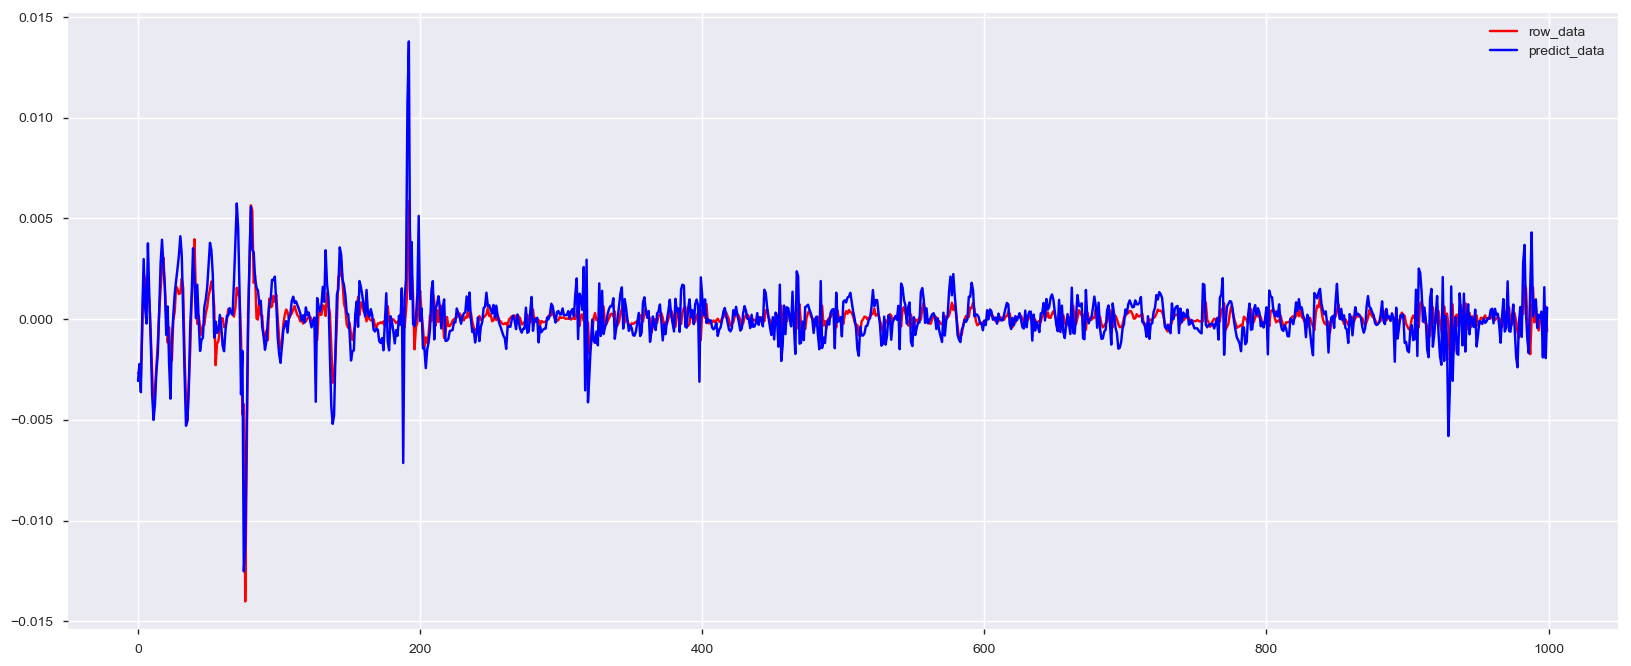

In [56]:
plt.figure(figsize=(20, 8))
plt.plot(range(len(y_train[:1000])), train_pred[:1000], color="r", label="row_data")
plt.plot(range(len(y_train[:1000])), y_train[:1000], color="b", label="predict_data")
plt.legend()
plt.show()
sum((train_pred - y_train)**2)

<Figure size 1440x576 with 0 Axes>

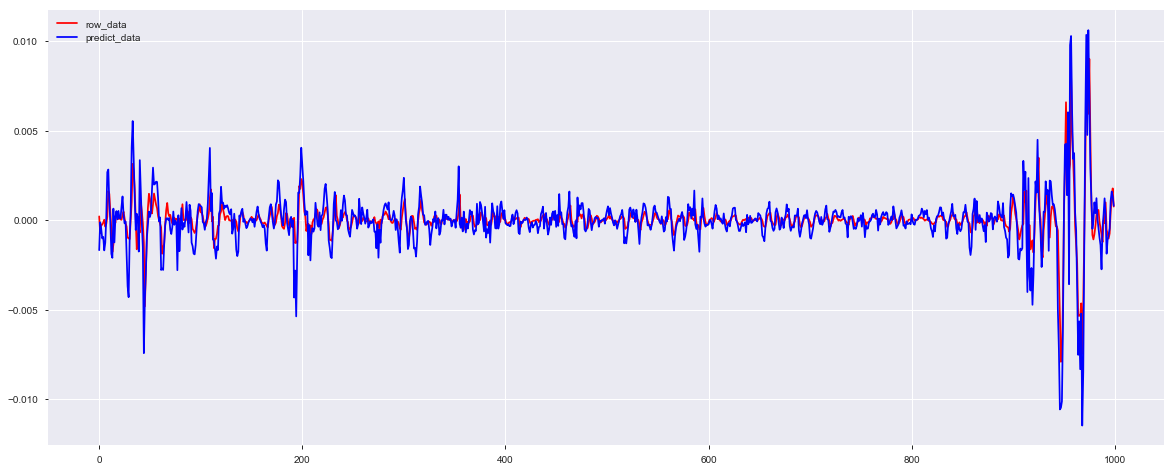

0.07696327511182662

In [59]:
plt.figure(figsize=(20, 8))
plt.plot(range(len(y_train[-1000:])), train_pred[-1000:], color="r", label="row_data")
plt.plot(range(len(y_train[-1000:])), y_train[-1000:], color="b", label="predict_data")
plt.legend()
plt.show()
sum((train_pred - y_train)**2)

<Figure size 1440x576 with 0 Axes>

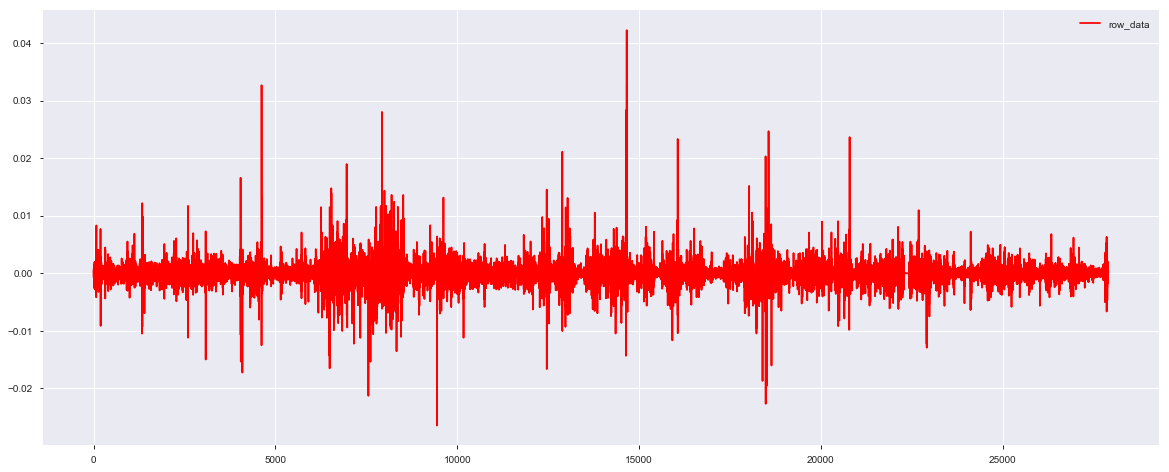

In [60]:
plt.figure(figsize=(20, 8))
plt.plot(range(len(y_train)), train_pred-y_train, color="r", label="row_data")
plt.legend()
plt.show()

In [61]:
summarys['D']

路線    キロ程        傾き      切片       分散比  測定回数  データ数
0      D  10000 -0.001744  -0.670  0.000006   211    54
1      D  10001  0.003181  -0.450  0.000019   211    44
2      D  10002  0.002455   0.340  0.000014   212    47
3      D  10003  0.001804   1.275  0.000016   213    36
4      D  10004  0.003191   1.510  0.000047   212    40
5      D  10005 -0.000062   0.730  0.000048   213    42
6      D  10006 -0.001089  -0.400  0.000057   213    34
7      D  10007  0.002328  -1.035  0.000024   213    41
8      D  10008  0.000415  -0.315  0.000044   214    43
9      D  10009 -0.001870   1.695  0.000030   213    70
10     D  10010  0.004654   3.480  0.000065   213    48
11     D  10011 -0.002140   3.525  0.000192   213    47
12     D  10012 -0.000276   0.960  0.000390   214    37
13     D  10013  0.003249  -3.230  0.000111   213    47
14     D  10014 -0.006221  -6.940  0.000074   213    40
15     D  10015  0.000096  -7.915  0.000165   214    34
16     D  10016  0.008002  -5.605  0.000178   214    59
17     D  10017 -0.009831  -1.400  0.000178   213    54
18     D  10018 -0.001773   2.390  0.000013   213    61
19     D  10019 -0.002384   3.780  0.000034   213    41
20     D  10020 -0.006779   2.760  0.000094   215    48
21     D  10021  0.004797   0.170  0.000097   214    56
22     D  10022  0.005244  -2.410  0.000043   214    47
23     D  10023  0.001993  -3.595  0.000009   215    41
24     D  10024 -0.000308  -3.500  0.000010   215    57
25     D  10025 -0.000859  -2.450  0.000013   213    53
26     D  10026 -0.001384  -1.030  0.000015   213    49
27     D  10027  0.000658   0.040  0.000005   215    47
28     D  10028 -0.000215   0.370  0.000009   215    48
29     D  10029 -0.000160  -0.060  0.000008   216    55
...   ..    ...       ...     ...       ...   ...   ...
15661  D  25661  0.004366  -0.310  0.000056   124    32
15662  D  25662  0.008265  -1.210  0.000209   125    36
15663  D  25663  0.004403  -1.725  0.000133   125    36
15664  D  25664  0.014045  -1.630  0.000328   124    33
15665  D  25665 -0.003199  -0.750  0.000103   125    38
15666  D  25666  0.002218   0.850  0.000091   124    41
15667  D  25667  0.003479   3.250  0.000075   123    43
15668  D  25668 -0.000245   3.940  0.000098   122    35
15669  D  25669  0.002025   4.420  0.000151   122    38
15670  D  25670  0.003968   3.960  0.000150   122    38
15671  D  25671  0.008763   2.430  0.000250   121    23
15672  D  25672 -0.001381  -0.825  0.000253   123    26
15673  D  25673 -0.006724  -4.785  0.001106   128    23
15674  D  25674 -0.009504  -7.185  0.000474   143    35
15675  D  25675 -0.010933  -7.095  0.000395   148    41
15676  D  25676  0.007698  -5.380  0.000407   148    37
15677  D  25677 -0.008475  -2.570  0.000322   157    30
15678  D  25678 -0.018013   0.805  0.000687   179    40
15679  D  25679  0.012209   3.950  0.000406   181    57
15680  D  25680  0.003455   6.990  0.000711   182    42
15681  D  25681  0.007854   7.490  0.000258   184    60
15682  D  25682  0.005319   6.285  0.000283   201    52
15683  D  25683  0.005233   3.330  0.000162   200    43
15684  D  25684  0.001904  -1.305  0.000360   184    47
15685  D  25685 -0.025063  -6.580  0.001409   182    37
15686  D  25686 -0.000594 -10.660  0.000176   182    67
15687  D  25687  0.009102  -9.470  0.000160   181    38
15688  D  25688  0.007423  -5.370  0.000290   170    43
15689  D  25689 -0.000547  -0.105  0.000144   166    47
15690  D  25690 -0.002646   3.655  0.000458   153    30

[15691 rows x 7 columns]

In [62]:
train = summarys['D']['傾き'].values
train = pd.DataFrame({'slope': train})
for i in range(30):
    train[f'lag{i+1}'] = train['slope'].shift(i+1)

In [63]:
train

slope      lag1      lag2      lag3      lag4      lag5      lag6  \
0     -0.001744       NaN       NaN       NaN       NaN       NaN       NaN   
1      0.003181 -0.001744       NaN       NaN       NaN       NaN       NaN   
2      0.002455  0.003181 -0.001744       NaN       NaN       NaN       NaN   
3      0.001804  0.002455  0.003181 -0.001744       NaN       NaN       NaN   
4      0.003191  0.001804  0.002455  0.003181 -0.001744       NaN       NaN   
5     -0.000062  0.003191  0.001804  0.002455  0.003181 -0.001744       NaN   
6     -0.001089 -0.000062  0.003191  0.001804  0.002455  0.003181 -0.001744   
7      0.002328 -0.001089 -0.000062  0.003191  0.001804  0.002455  0.003181   
8      0.000415  0.002328 -0.001089 -0.000062  0.003191  0.001804  0.002455   
9     -0.001870  0.000415  0.002328 -0.001089 -0.000062  0.003191  0.001804   
10     0.004654 -0.001870  0.000415  0.002328 -0.001089 -0.000062  0.003191   
11    -0.002140  0.004654 -0.001870  0.000415  0.002328 -0.001089 -0.000062   
12    -0.000276 -0.002140  0.004654 -0.001870  0.000415  0.002328 -0.001089   
13     0.003249 -0.000276 -0.002140  0.004654 -0.001870  0.000415  0.002328   
14    -0.006221  0.003249 -0.000276 -0.002140  0.004654 -0.001870  0.000415   
15     0.000096 -0.006221  0.003249 -0.000276 -0.002140  0.004654 -0.001870   
16     0.008002  0.000096 -0.006221  0.003249 -0.000276 -0.002140  0.004654   
17    -0.009831  0.008002  0.000096 -0.006221  0.003249 -0.000276 -0.002140   
18    -0.001773 -0.009831  0.008002  0.000096 -0.006221  0.003249 -0.000276   
19    -0.002384 -0.001773 -0.009831  0.008002  0.000096 -0.006221  0.003249   
20    -0.006779 -0.002384 -0.001773 -0.009831  0.008002  0.000096 -0.006221   
21     0.004797 -0.006779 -0.002384 -0.001773 -0.009831  0.008002  0.000096   
22     0.005244  0.004797 -0.006779 -0.002384 -0.001773 -0.009831  0.008002   
23     0.001993  0.005244  0.004797 -0.006779 -0.002384 -0.001773 -0.009831   
24    -0.000308  0.001993  0.005244  0.004797 -0.006779 -0.002384 -0.001773   
25    -0.000859 -0.000308  0.001993  0.005244  0.004797 -0.006779 -0.002384   
26    -0.001384 -0.000859 -0.000308  0.001993  0.005244  0.004797 -0.006779   
27     0.000658 -0.001384 -0.000859 -0.000308  0.001993  0.005244  0.004797   
28    -0.000215  0.000658 -0.001384 -0.000859 -0.000308  0.001993  0.005244   
29    -0.000160 -0.000215  0.000658 -0.001384 -0.000859 -0.000308  0.001993   
...         ...       ...       ...       ...       ...       ...       ...   
15661  0.004366  0.002431  0.001861 -0.000028 -0.000066  0.000929 -0.001783   
15662  0.008265  0.004366  0.002431  0.001861 -0.000028 -0.000066  0.000929   
15663  0.004403  0.008265  0.004366  0.002431  0.001861 -0.000028 -0.000066   
15664  0.014045  0.004403  0.008265  0.004366  0.002431  0.001861 -0.000028   
15665 -0.003199  0.014045  0.004403  0.008265  0.004366  0.002431  0.001861   
15666  0.002218 -0.003199  0.014045  0.004403  0.008265  0.004366  0.002431   
15667  0.003479  0.002218 -0.003199  0.014045  0.004403  0.008265  0.004366   
15668 -0.000245  0.003479  0.002218 -0.003199  0.014045  0.004403  0.008265   
15669  0.002025 -0.000245  0.003479  0.002218 -0.003199  0.014045  0.004403   
15670  0.003968  0.002025 -0.000245  0.003479  0.002218 -0.003199  0.014045   
15671  0.008763  0.003968  0.002025 -0.000245  0.003479  0.002218 -0.003199   
15672 -0.001381  0.008763  0.003968  0.002025 -0.000245  0.003479  0.002218   
15673 -0.006724 -0.001381  0.008763  0.003968  0.002025 -0.000245  0.003479   
15674 -0.009504 -0.006724 -0.001381  0.008763  0.003968  0.002025 -0.000245   
15675 -0.010933 -0.009504 -0.006724 -0.001381  0.008763  0.003968  0.002025   
15676  0.007698 -0.010933 -0.009504 -0.006724 -0.001381  0.008763  0.003968   
15677 -0.008475  0.007698 -0.010933 -0.009504 -0.006724 -0.001381  0.008763   
15678 -0.018013 -0.008475  0.007698 -0.010933 -0.009504 -0.006724 -0.001381   
15679  0.012209 -0.018013 -0.008475  0.007698 -0.010933 -0.0

In [64]:
X_train = train.drop(['slope'], axis=1).values
y_train = train['slope'].values
lgb.fit(X_train, y_train)
train_pred = lgb.predict(X_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

<Figure size 1440x576 with 0 Axes>

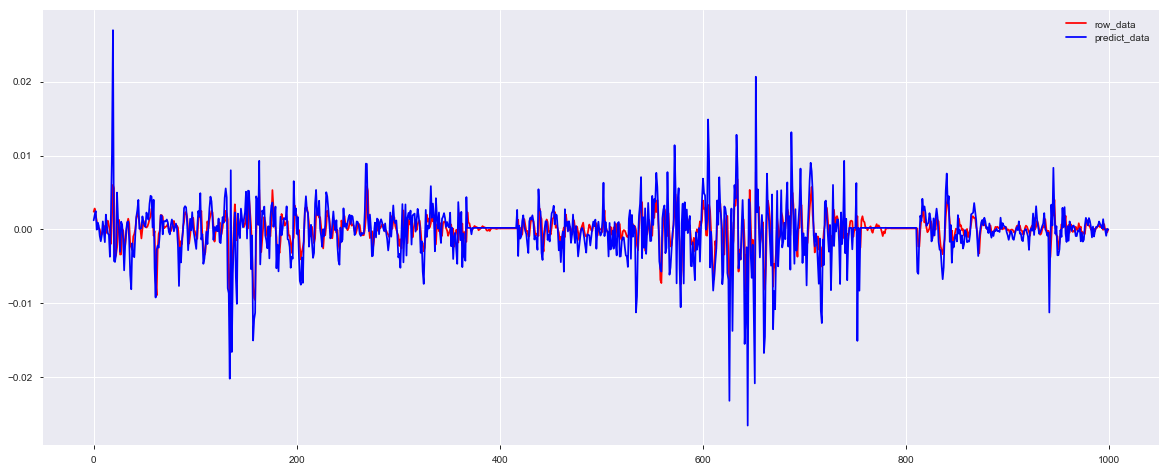

0.16541781384242685

In [65]:
plt.figure(figsize=(20, 8))
plt.plot(range(len(y_train[3000:4000])), train_pred[3000:4000], color="r", label="row_data")
plt.plot(range(len(y_train[3000:4000])), y_train[3000:4000], color="b", label="predict_data")
plt.legend()
plt.show()
sum((train_pred - y_train)**2)

In [70]:
for no in ['A', 'B', 'C', 'D']:
    train = pd.DataFrame(summarys[no]['傾き'].copy())
    for i in range(30):
        train[f'lag{i+1}'] = train['傾き'].shift(i+1)

    X_train = train.drop(['傾き'], axis=1).values
    y_train = train['傾き'].values
    lgb.fit(X_train, y_train)
    train_pred = lgb.predict(X_train)
    summarys[no]['傾き'] = train_pred

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [76]:
for no in ['A', 'B', 'C', 'D']:
    summarys[no].to_csv(f'summary12_refine_level_{no}_lgbm.csv')

summarys["A"]

%%time
submit = pd.DataFrame()
for no in ['A', 'B', 'C', 'D']:
    summary = summarys[no]
    submit = pd.concat([submit, summary[['路線', 'キロ程', '傾き', '切片']]], axis=0)
submit = submit.reset_index(drop=True)

pdp.ProfileReport(submit)

In [80]:
p = []
intercept_day = 15
for no in ['A', 'B', 'C', 'D']:
    summary = summarys[no]
    for i in range(91):
        day = summary['切片'].values + summary['傾き'].values*(i+intercept_day)
        p.extend(day)

submision = pd.DataFrame(p)
print(sum(submision.isnull()))
submision = submision.fillna(0)
submision = submision.apply(lambda x:x.round(2)) #サイズが大きいため予測値を桁落とし

0


In [81]:
submision.max()

0    18.45
dtype: float64

In [82]:
submision.min()

0   -18.13
dtype: float64

submision.loc[submision[0] > 16, 0] = 16
submision.loc[submision[0] < -16, 0] = -16

In [83]:
len(submision[submision[0] >= 16])
len(submision[submision[0] <= -16])

373

676

In [84]:
submision

0
0          0.33
1          2.64
2          4.96
3          5.95
4          5.03
5          1.67
6         -3.16
7         -7.12
8         -8.84
9         -7.42
10        -3.38
11         1.08
12         4.55
13         5.42
14         3.73
15         1.02
16        -2.76
17        -4.81
18        -4.98
19        -3.67
20        -1.91
21        -0.33
22         0.11
23         0.28
24         0.98
25         2.33
26         3.84
27         4.08
28         1.94
29        -1.99
...         ...
10993862  -0.12
10993863  -0.82
10993864  -1.47
10993865  -1.39
10993866  -1.00
10993867   0.68
10993868   3.17
10993869   3.95
10993870   4.41
10993871   4.10
10993872   2.64
10993873  -0.63
10993874  -5.05
10993875  -7.73
10993876  -7.80
10993877  -5.40
10993878  -3.07
10993879   0.30
10993880   4.31
10993881   7.43
10993882   7.70
10993883   6.75
10993884   3.70
10993885  -1.19
10993886  -7.34
10993887 -11.03
10993888  -9.08
10993889  -5.10
10993890   0.06
10993891   3.48

[10993892 rows x 1 columns]

Text(0.5, 1.0, 'kilo: 28723,  kilo_id: 18723')

Text(0.5, 1.0, 'kilo: 11067,  kilo_id: 1067')

Text(0.5, 1.0, 'kilo: 24053,  kilo_id: 14053')

Text(0.5, 1.0, 'kilo: 25812,  kilo_id: 15812')

Text(0.5, 1.0, 'kilo: 28942,  kilo_id: 18942')

Text(0.5, 1.0, 'kilo: 10486,  kilo_id: 486')

Text(0.5, 1.0, 'kilo: 16753,  kilo_id: 6753')

Text(0.5, 1.0, 'kilo: 25157,  kilo_id: 15157')

Text(0.5, 1.0, 'kilo: 36650,  kilo_id: 26650')

Text(0.5, 1.0, 'kilo: 26098,  kilo_id: 16098')

Text(0.5, 1.0, 'kilo: 36987,  kilo_id: 26987')

Text(0.5, 1.0, 'kilo: 19093,  kilo_id: 9093')

Text(0.5, 1.0, 'kilo: 31412,  kilo_id: 21412')

Text(0.5, 1.0, 'kilo: 36562,  kilo_id: 26562')

Text(0.5, 1.0, 'kilo: 15250,  kilo_id: 5250')

Text(0.5, 1.0, 'kilo: 11127,  kilo_id: 1127')

Text(0.5, 1.0, 'kilo: 27061,  kilo_id: 17061')

Text(0.5, 1.0, 'kilo: 26059,  kilo_id: 16059')

Text(0.5, 1.0, 'kilo: 20740,  kilo_id: 10740')

Text(0.5, 1.0, 'kilo: 12493,  kilo_id: 2493')

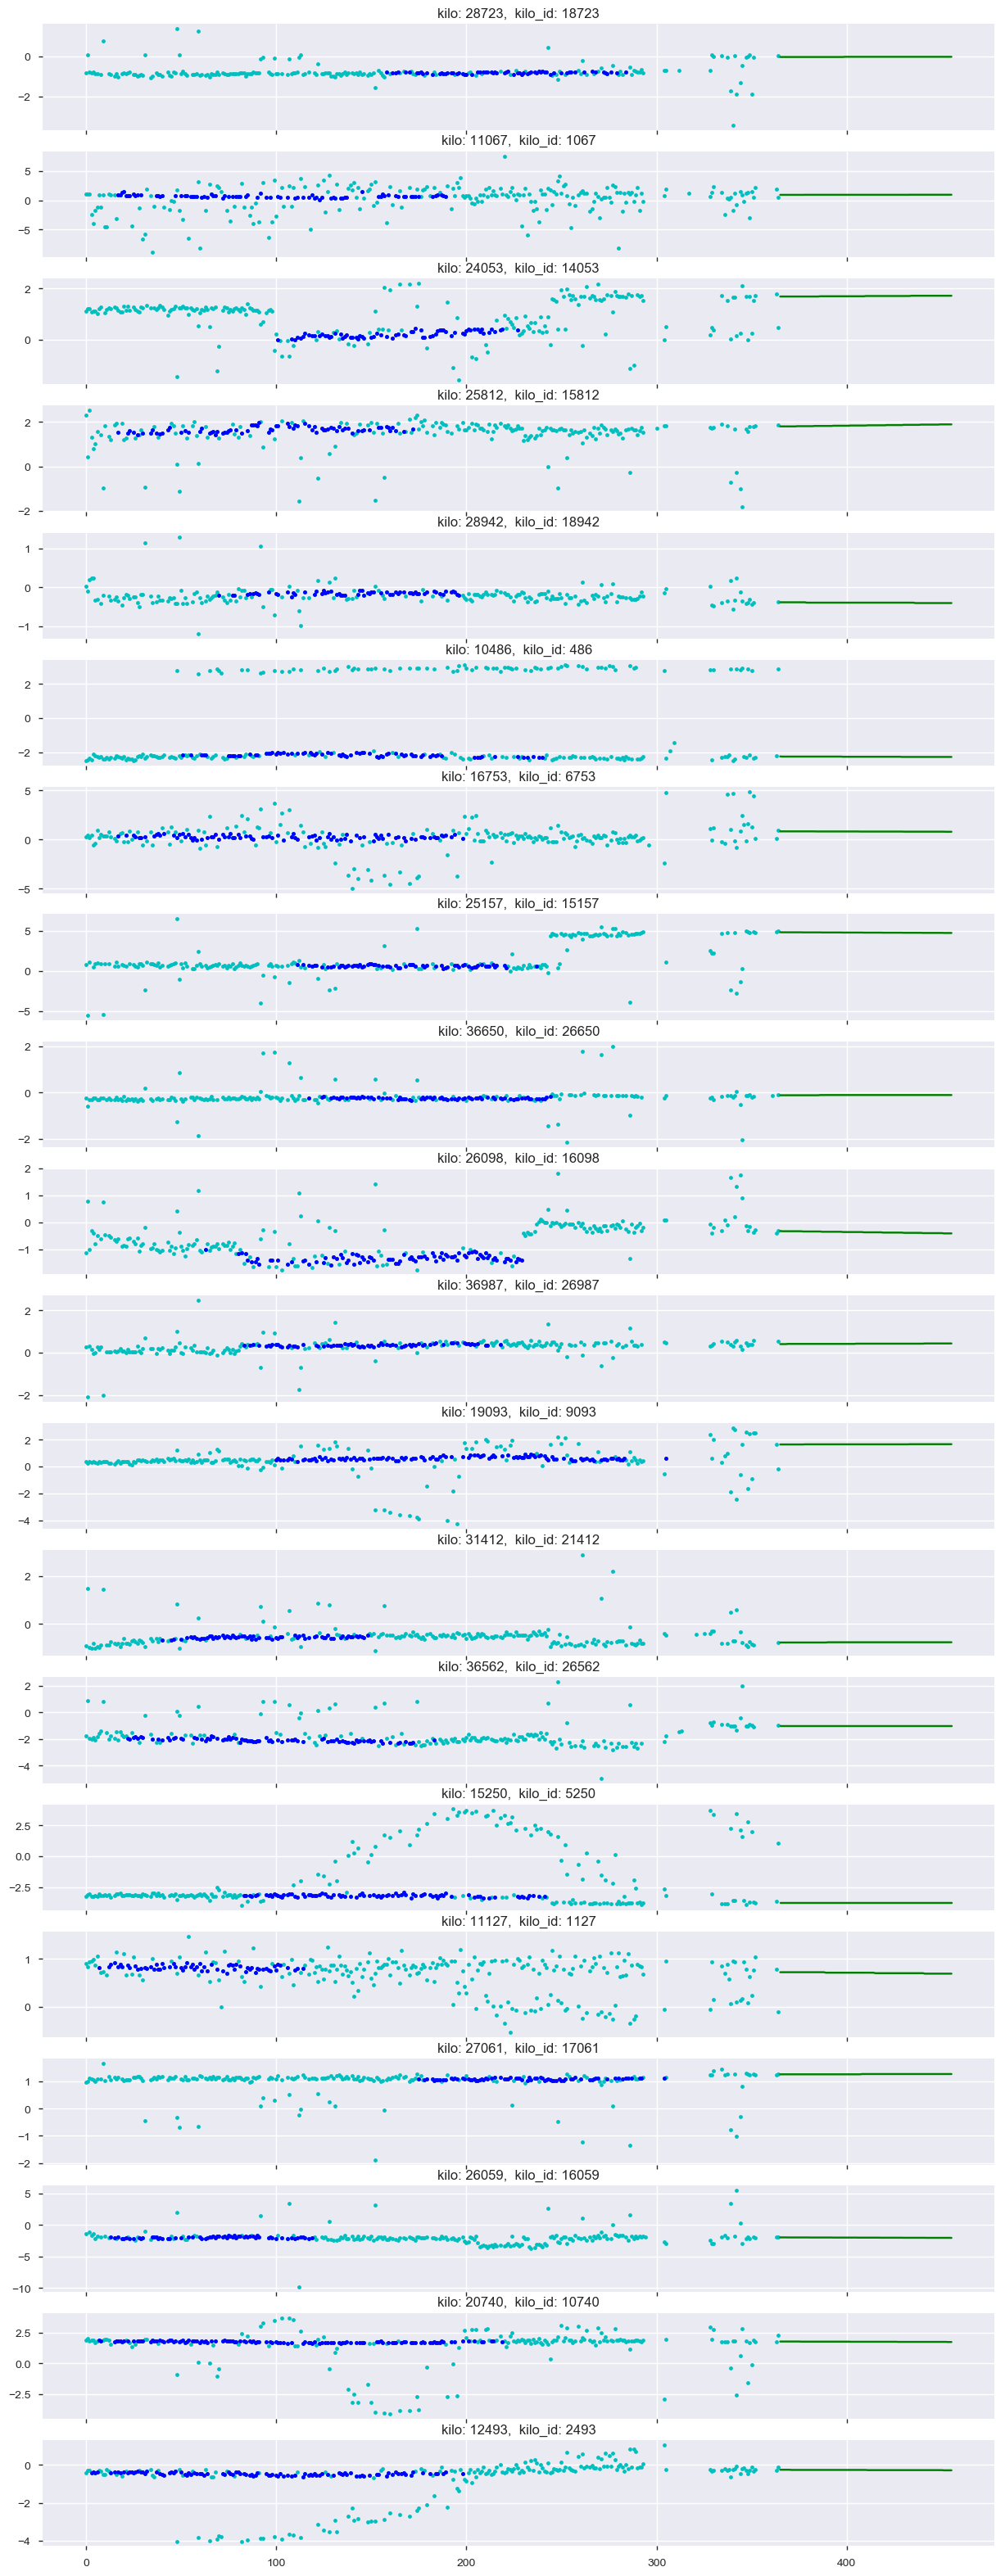

In [85]:
random.seed(10)

fig, axes = plt.subplots(20, 1, figsize=(15, 40), sharex=True)

track = tracks['A']
kilos = track['キロ程'].unique()
for i, kilo in enumerate(random.sample(list(kilos), 20)):
    data = track.loc[track['キロ程'] == kilo, ['date', '水準']]
    data = data.dropna(subset=['水準'])
    data = data.reset_index(drop=True)
    data['day'] = get_day(data['date'])
    data = data.drop(['date'], axis=1)
    axes[i].plot(data['day'], data['水準'], marker='.', linewidth=0, c='c')

    kilo_id = kilo - 10000
    hoge = [kilo_id + i*len(kilos) for i in range(91)]
    piyo = submision.loc[hoge, 0]
    axes[i].plot(range(365, 365 + 91), piyo, c='g')

    normal_id = remove_outliers(data)
    data = data.loc[normal_id]
    axes[i].plot(data['day'], data['水準'], marker='.', linewidth=0, c='b')

    axes[i].set_title(f'kilo: {kilo},  kilo_id: {kilo_id}')

Text(0.5, 1.0, 'kilo: 22623,  kilo_id: 12623')

Text(0.5, 1.0, 'kilo: 23781,  kilo_id: 13781')

Text(0.5, 1.0, 'kilo: 11326,  kilo_id: 1326')

Text(0.5, 1.0, 'kilo: 18484,  kilo_id: 8484')

Text(0.5, 1.0, 'kilo: 26753,  kilo_id: 16753')

Text(0.5, 1.0, 'kilo: 25922,  kilo_id: 15922')

Text(0.5, 1.0, 'kilo: 23268,  kilo_id: 13268')

Text(0.5, 1.0, 'kilo: 19938,  kilo_id: 9938')

Text(0.5, 1.0, 'kilo: 25617,  kilo_id: 15617')

Text(0.5, 1.0, 'kilo: 21732,  kilo_id: 11732')

Text(0.5, 1.0, 'kilo: 29116,  kilo_id: 19116')

Text(0.5, 1.0, 'kilo: 17157,  kilo_id: 7157')

Text(0.5, 1.0, 'kilo: 26537,  kilo_id: 16537')

Text(0.5, 1.0, 'kilo: 14563,  kilo_id: 4563')

Text(0.5, 1.0, 'kilo: 19235,  kilo_id: 9235')

Text(0.5, 1.0, 'kilo: 14579,  kilo_id: 4579')

Text(0.5, 1.0, 'kilo: 13107,  kilo_id: 3107')

Text(0.5, 1.0, 'kilo: 30262,  kilo_id: 20262')

Text(0.5, 1.0, 'kilo: 18208,  kilo_id: 8208')

Text(0.5, 1.0, 'kilo: 27451,  kilo_id: 17451')

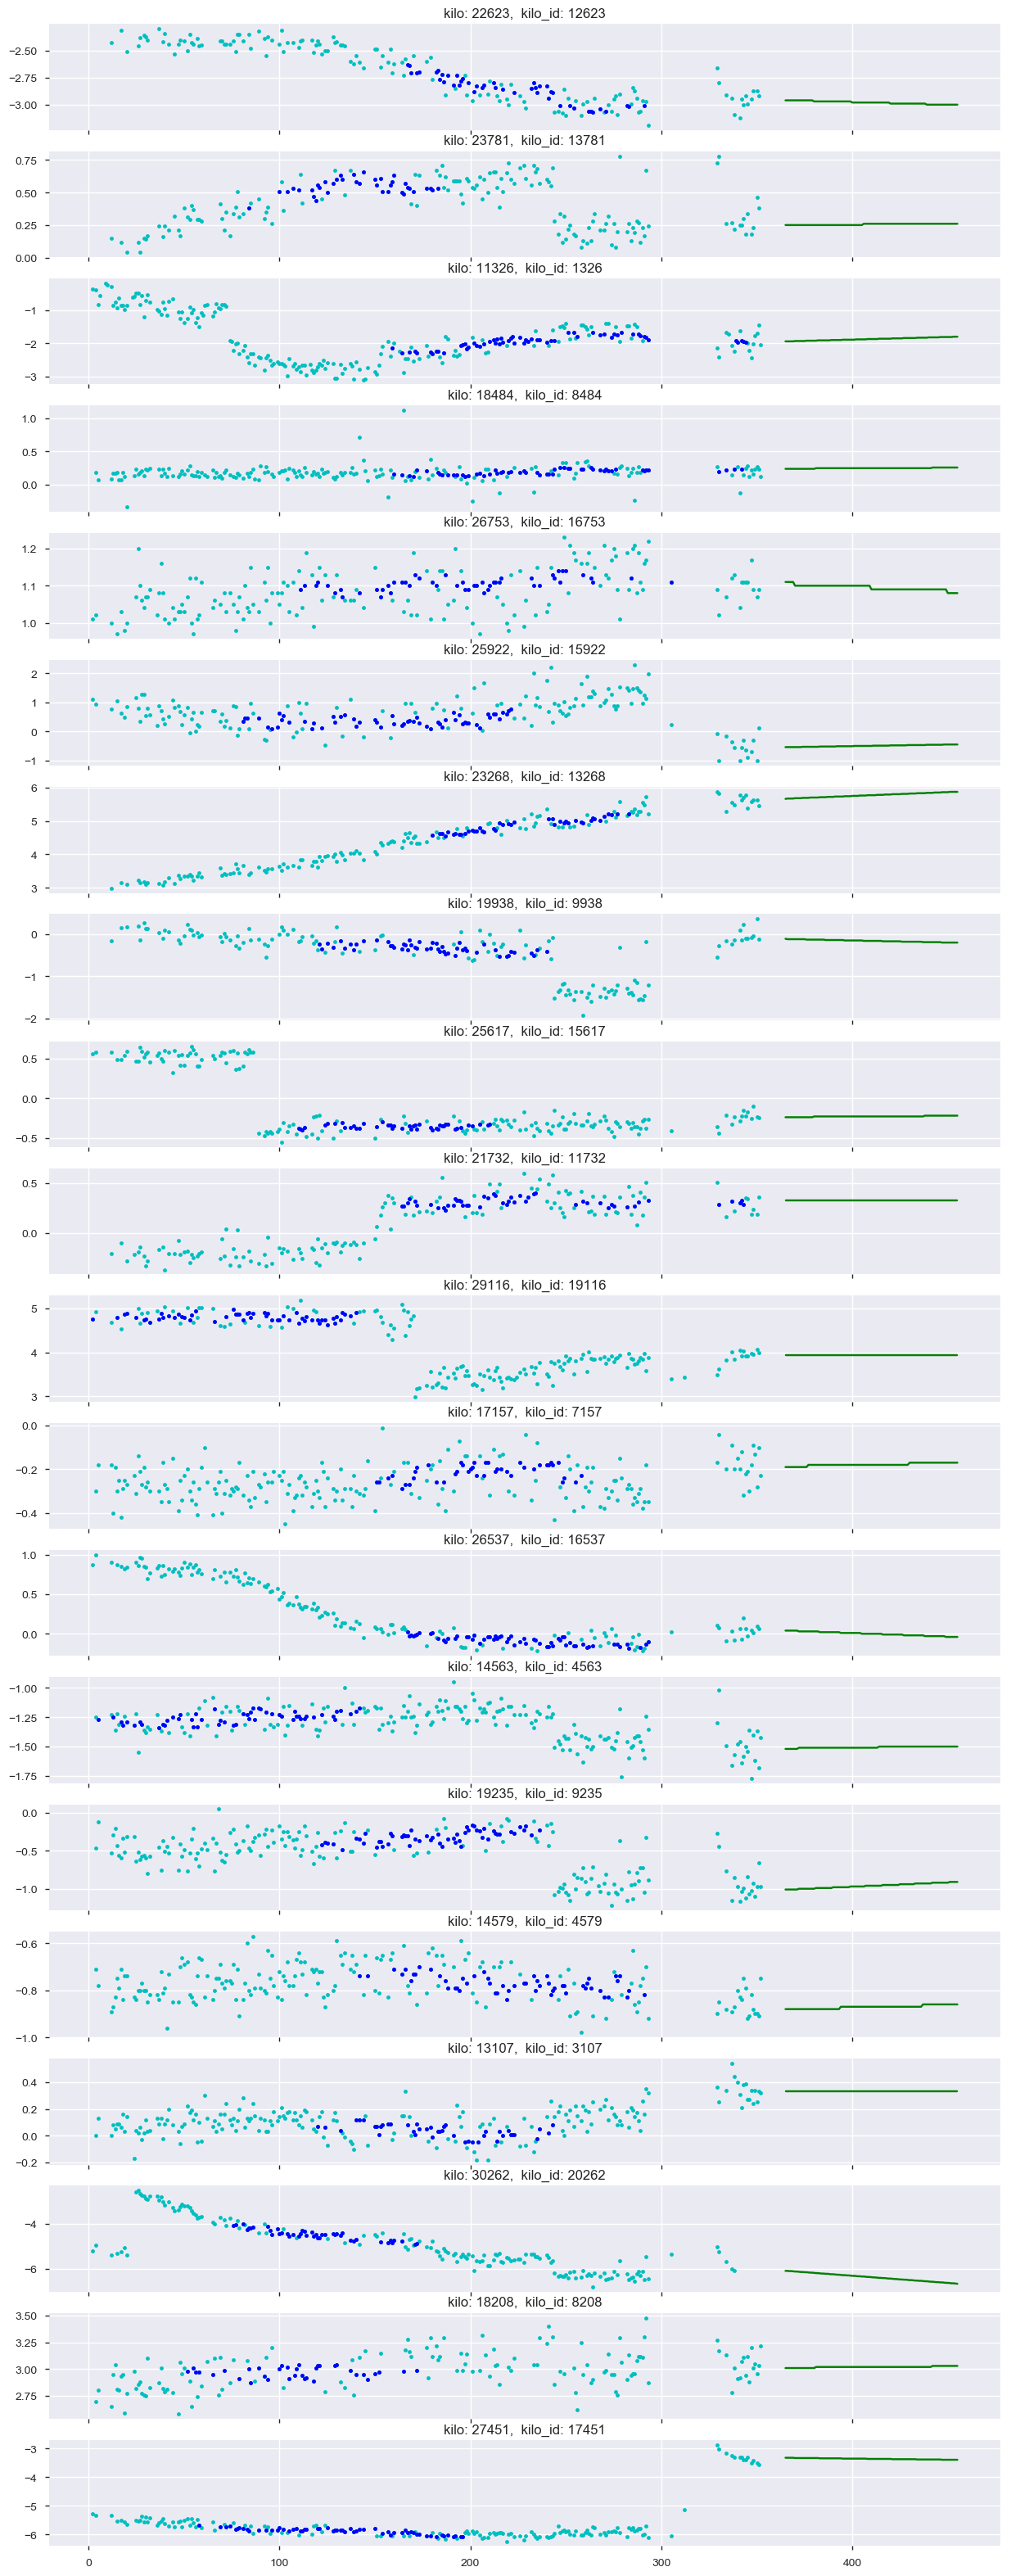

In [86]:
random.seed(0)

fig, axes = plt.subplots(20, 1, figsize=(15, 40), sharex=True)

track = tracks['B']
kilos = track['キロ程'].unique()
for i, kilo in enumerate(random.sample(list(kilos), 20)):
    data = track.loc[track['キロ程'] == kilo, ['date', '水準']]
    data = data.dropna(subset=['水準'])
    data = data.reset_index(drop=True)
    data['day'] = get_day(data['date'])
    data = data.drop(['date'], axis=1)
    axes[i].plot(data['day'], data['水準'], marker='.', linewidth=0, c='c')

    kilo_id = kilo - 10000
    hoge = [kilo_id + i*len(kilos) for i in range(91)]
    hoge = np.array(hoge) + len(tracks['A']['キロ程'].unique())*91
    piyo = submision.loc[hoge, 0]
    axes[i].plot(range(365, 365 + 91), piyo, c='g')

    normal_id = remove_outliers(data)
    data = data.loc[normal_id]
    axes[i].plot(data['day'], data['水準'], marker='.', linewidth=0, c='b')

    axes[i].set_title(f'kilo: {kilo},  kilo_id: {kilo_id}')

Text(0.5, 1.0, 'kilo: 65340,  kilo_id: 55340')

Text(0.5, 1.0, 'kilo: 35247,  kilo_id: 25247')

Text(0.5, 1.0, 'kilo: 59673,  kilo_id: 49673')

Text(0.5, 1.0, 'kilo: 37562,  kilo_id: 27562')

Text(0.5, 1.0, 'kilo: 12653,  kilo_id: 2653')

Text(0.5, 1.0, 'kilo: 26968,  kilo_id: 16968')

Text(0.5, 1.0, 'kilo: 43506,  kilo_id: 33506')

Text(0.5, 1.0, 'kilo: 41845,  kilo_id: 31845')

Text(0.5, 1.0, 'kilo: 36537,  kilo_id: 26537')

Text(0.5, 1.0, 'kilo: 61367,  kilo_id: 51367')

Text(0.5, 1.0, 'kilo: 64385,  kilo_id: 54385')

Text(0.5, 1.0, 'kilo: 29877,  kilo_id: 19877')

Text(0.5, 1.0, 'kilo: 41234,  kilo_id: 31234')

Text(0.5, 1.0, 'kilo: 33465,  kilo_id: 23465')

Text(0.5, 1.0, 'kilo: 48232,  kilo_id: 38232')

Text(0.5, 1.0, 'kilo: 24315,  kilo_id: 14315')

Text(0.5, 1.0, 'kilo: 43075,  kilo_id: 33075')

Text(0.5, 1.0, 'kilo: 19127,  kilo_id: 9127')

Text(0.5, 1.0, 'kilo: 28470,  kilo_id: 18470')

Text(0.5, 1.0, 'kilo: 19158,  kilo_id: 9158')

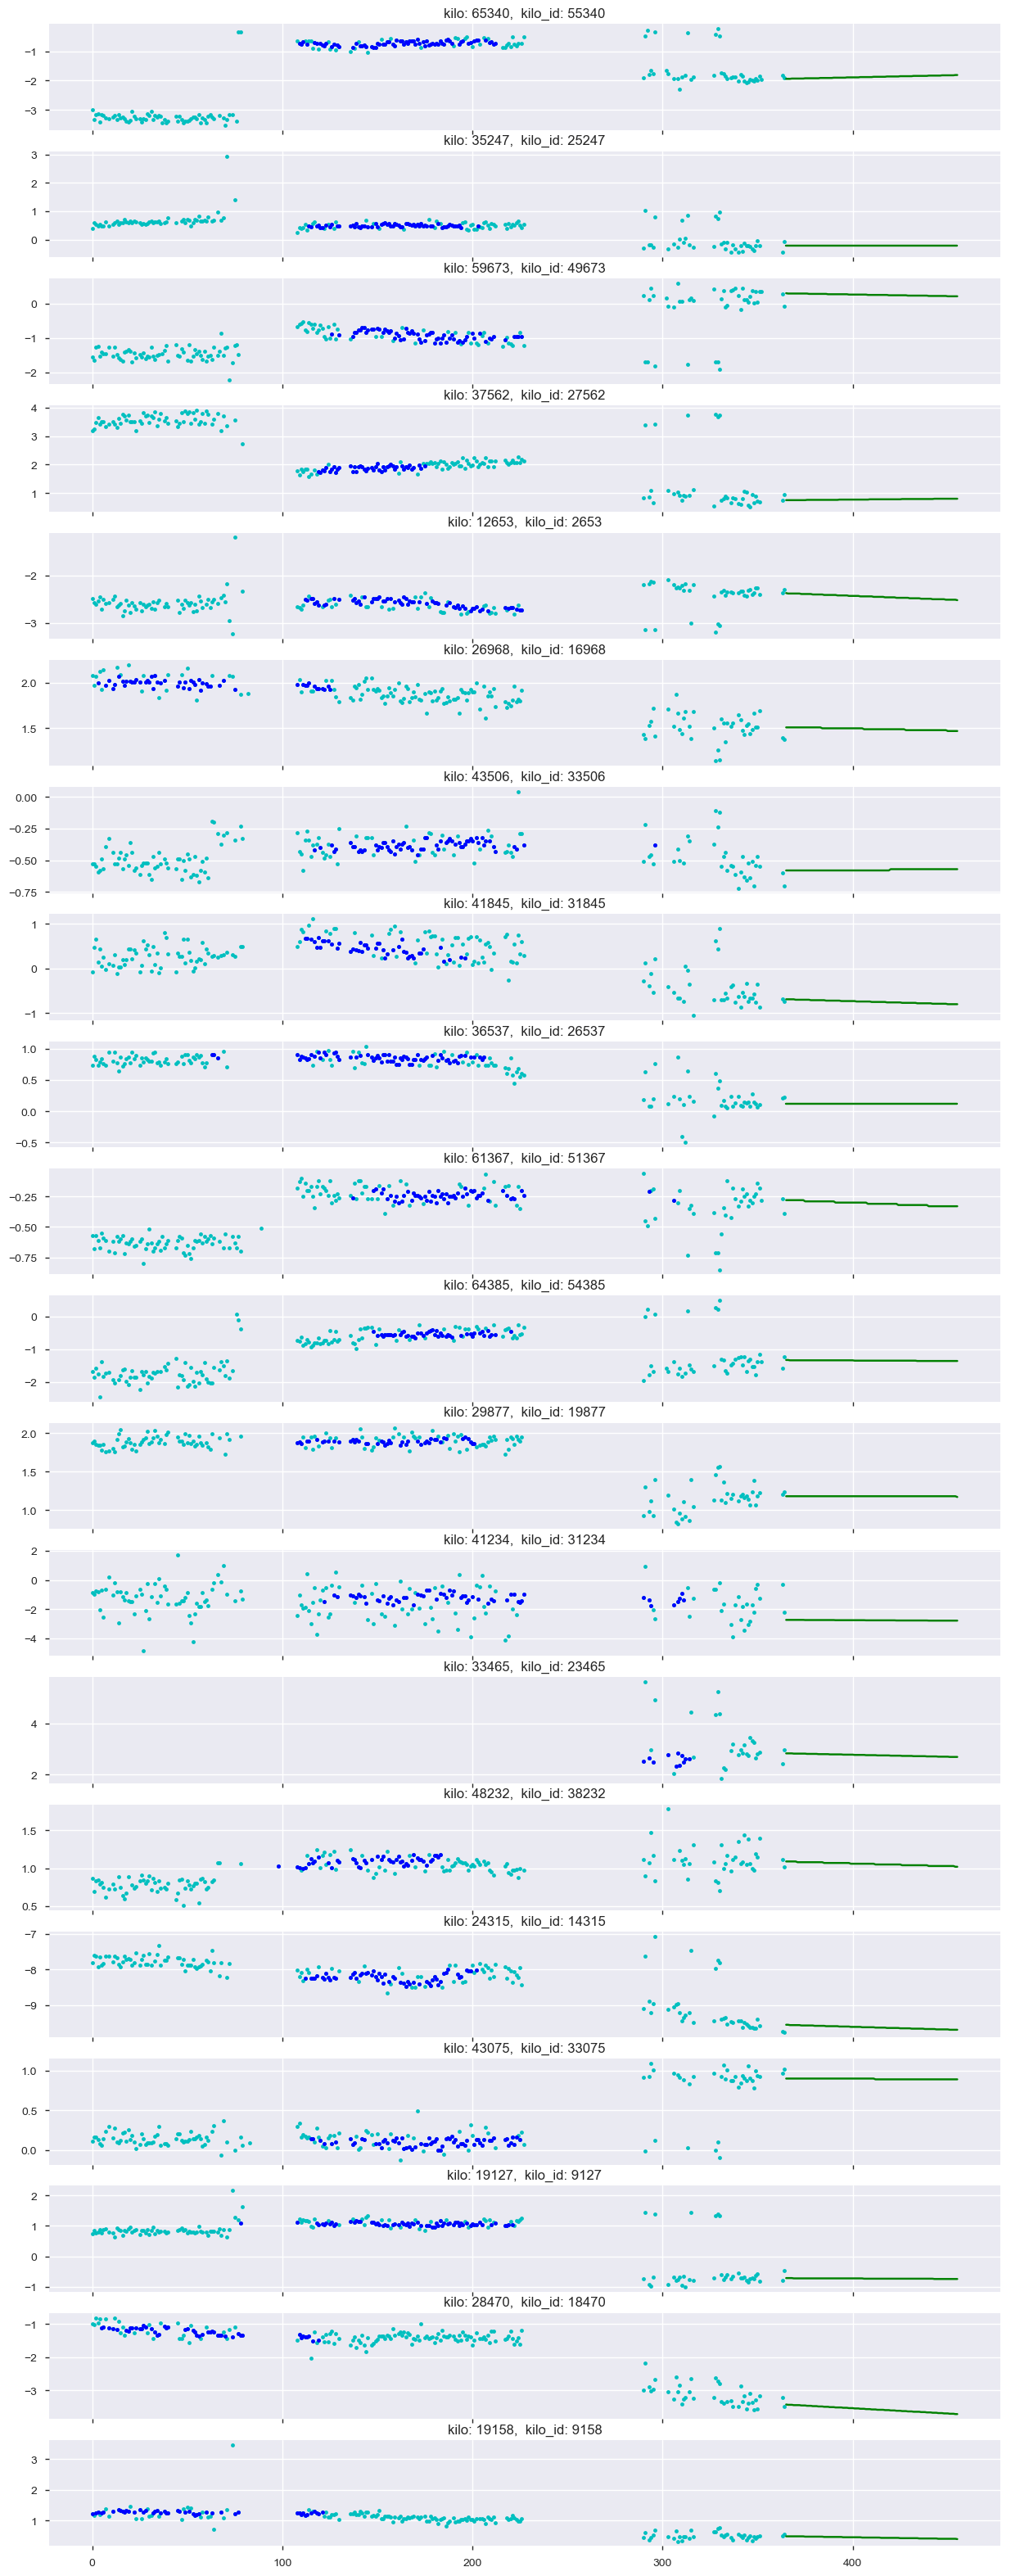

In [87]:
random.seed(0)

fig, axes = plt.subplots(20, 1, figsize=(15, 40), sharex=True)

track = tracks['C']
kilos = track['キロ程'].unique()
for i, kilo in enumerate(random.sample(list(kilos), 20)):
    data = track.loc[track['キロ程'] == kilo, ['date', '水準']]
    data = data.dropna(subset=['水準'])
    data = data.reset_index(drop=True)
    data['day'] = get_day(data['date'])
    data = data.drop(['date'], axis=1)
    axes[i].plot(data['day'], data['水準'], marker='.', linewidth=0, c='c')

    kilo_id = kilo - 10000
    hoge = [kilo_id + i*len(kilos) for i in range(91)]
    hoge = np.array(hoge) + len(tracks['A']['キロ程'].unique())*91 + len(tracks['B']['キロ程'].unique())*91
    piyo = submision.loc[hoge, 0]
    axes[i].plot(range(365, 365 + 91), piyo, c='g')

    normal_id = remove_outliers(data)
    data = data.loc[normal_id]
    axes[i].plot(data['day'], data['水準'], marker='.', linewidth=0, c='b')

    axes[i].set_title(f'kilo: {kilo},  kilo_id: {kilo_id}')

Text(0.5, 1.0, 'kilo: 23835,  kilo_id: 13835')

Text(0.5, 1.0, 'kilo: 16311,  kilo_id: 6311')

Text(0.5, 1.0, 'kilo: 22418,  kilo_id: 12418')

Text(0.5, 1.0, 'kilo: 24585,  kilo_id: 14585')

Text(0.5, 1.0, 'kilo: 16890,  kilo_id: 6890')

Text(0.5, 1.0, 'kilo: 10663,  kilo_id: 663')

Text(0.5, 1.0, 'kilo: 14242,  kilo_id: 4242')

Text(0.5, 1.0, 'kilo: 18376,  kilo_id: 8376')

Text(0.5, 1.0, 'kilo: 17961,  kilo_id: 7961')

Text(0.5, 1.0, 'kilo: 16634,  kilo_id: 6634')

Text(0.5, 1.0, 'kilo: 25044,  kilo_id: 15044')

Text(0.5, 1.0, 'kilo: 22841,  kilo_id: 12841')

Text(0.5, 1.0, 'kilo: 23596,  kilo_id: 13596')

Text(0.5, 1.0, 'kilo: 14969,  kilo_id: 4969')

Text(0.5, 1.0, 'kilo: 17808,  kilo_id: 7808')

Text(0.5, 1.0, 'kilo: 15866,  kilo_id: 5866')

Text(0.5, 1.0, 'kilo: 19558,  kilo_id: 9558')

Text(0.5, 1.0, 'kilo: 24608,  kilo_id: 14608')

Text(0.5, 1.0, 'kilo: 24878,  kilo_id: 14878')

Text(0.5, 1.0, 'kilo: 13578,  kilo_id: 3578')

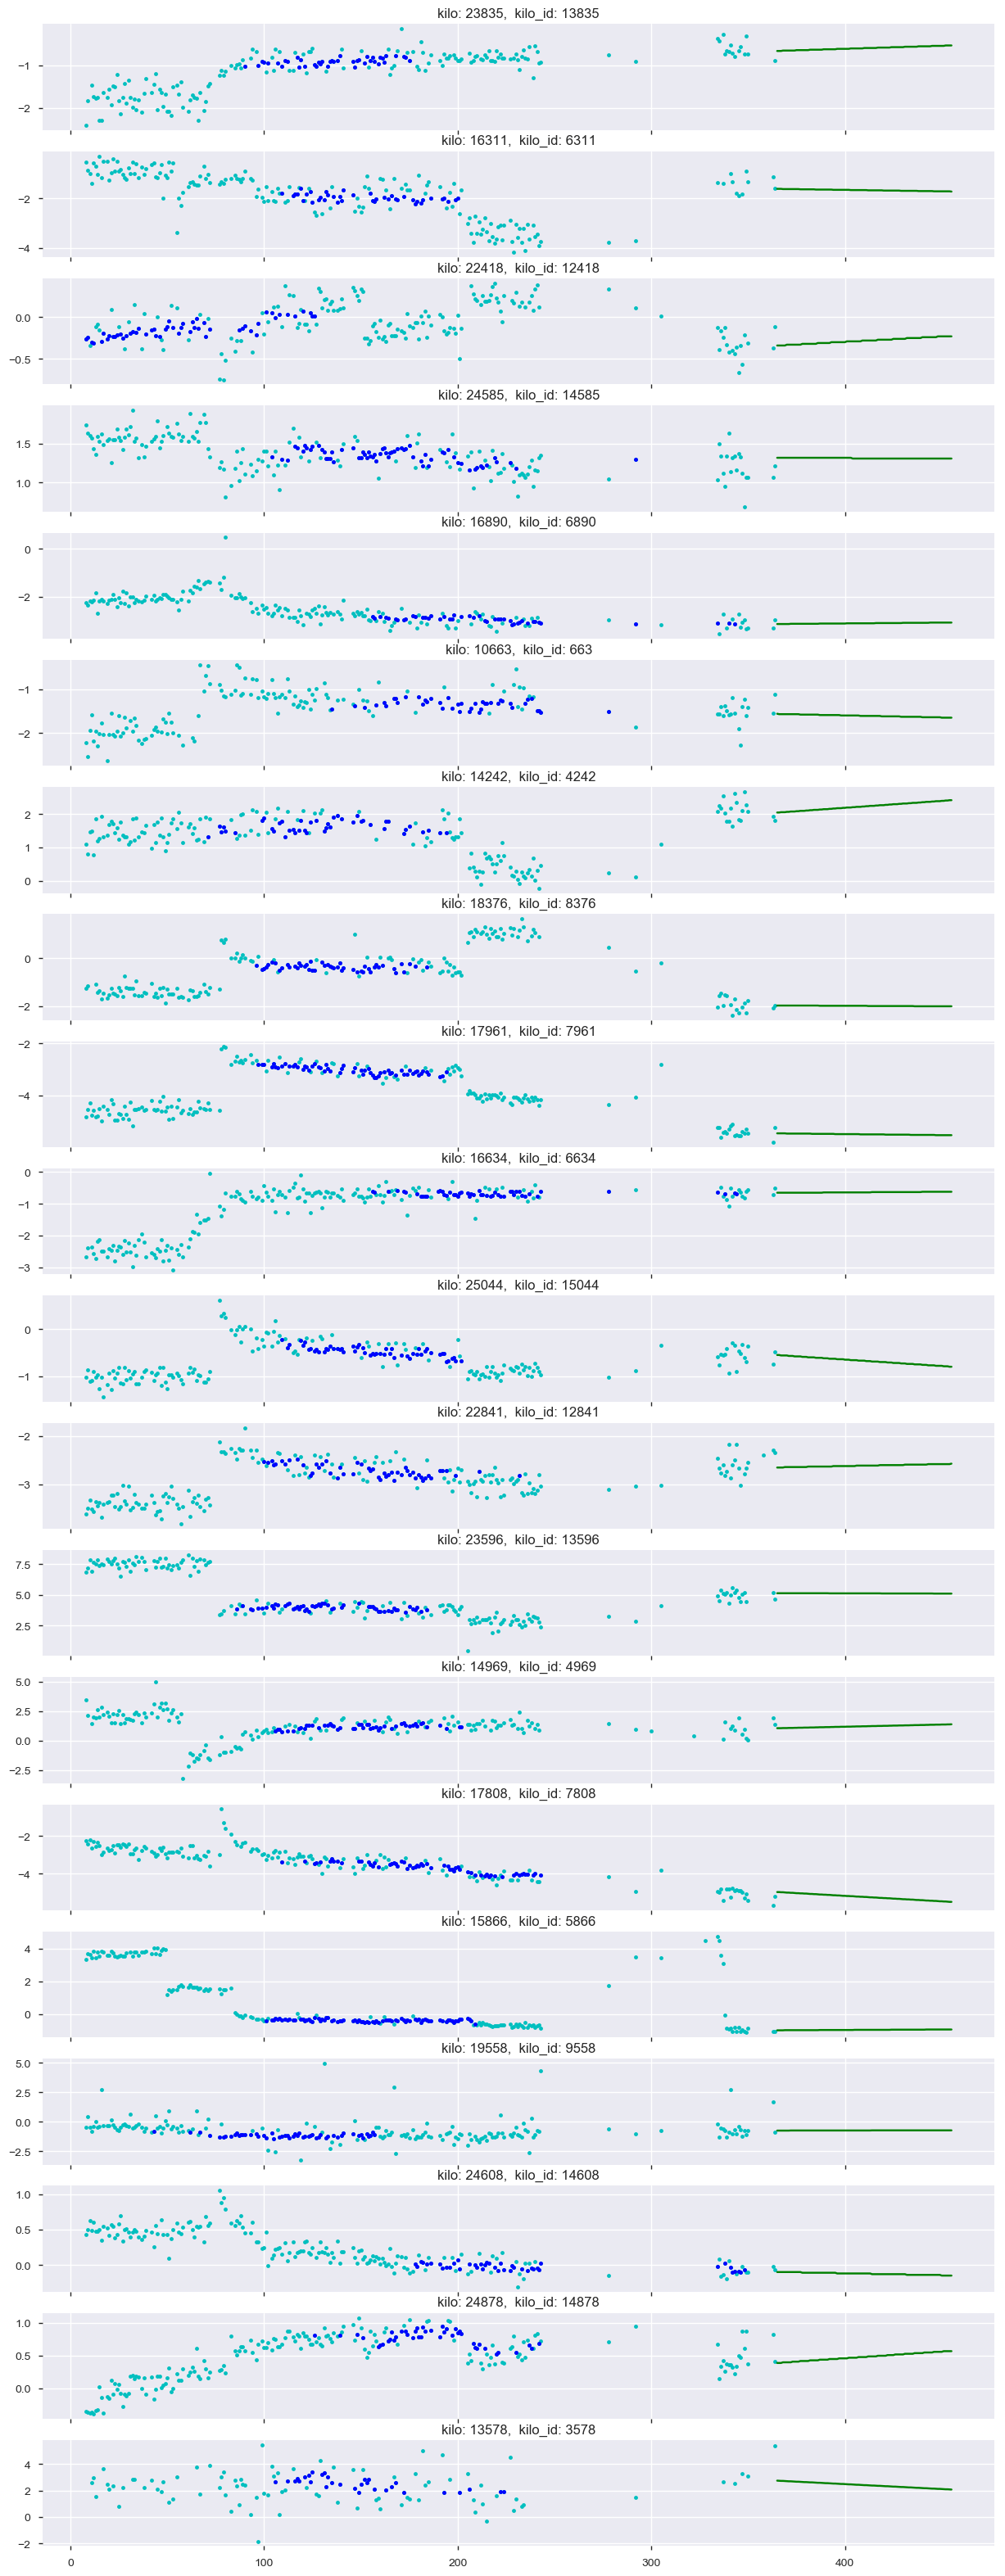

In [88]:
random.seed(0)

fig, axes = plt.subplots(20, 1, figsize=(15, 40), sharex=True)

track = tracks['D']
kilos = track['キロ程'].unique()
for i, kilo in enumerate(random.sample(list(kilos), 20)):
    data = track.loc[track['キロ程'] == kilo, ['date', '水準']]
    data = data.dropna(subset=['水準'])
    data = data.reset_index(drop=True)
    data['day'] = get_day(data['date'])
    data = data.drop(['date'], axis=1)
    axes[i].plot(data['day'], data['水準'], marker='.', linewidth=0, c='c')

    kilo_id = kilo - 10000
    hoge = [kilo_id + i*len(kilos) for i in range(91)]
    hoge = np.array(hoge) + len(tracks['A']['キロ程'].unique())*91 + len(tracks['B']['キロ程'].unique())*91 + len(tracks['C']['キロ程'].unique())*91
    piyo = submision.loc[hoge, 0]
    axes[i].plot(range(365, 365 + 91), piyo, c='g')

    normal_id = remove_outliers(data)
    data = data.loc[normal_id]
    axes[i].plot(data['day'], data['水準'], marker='.', linewidth=0, c='b')

    axes[i].set_title(f'kilo: {kilo},  kilo_id: {kilo_id}')

In [89]:
submision.to_csv("submit12_refine_level.csv", header=None)